<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/W2D1_anmol/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 2, Day 1, Tutorial 1
# Day 1: Parameter Sharing (CNNs and RNNs)

__Instructor__: Alona Fyshe 

__Content creators:__ Dawn McKnight, Richard Gerum, Cassidy Pirlot, Rohan Saha, Liam Peet-Pare, Saeed Najafi  

__Content reviewers:__ Saeed Salehi, Lily Cheng, Yu-Fang Yang, Polina Turishcheva,   

__Production editors:__ Yoni Friedman, Spiros Chavlis.  

__Based on material from:__ Konrad Kording, Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- define what convolution is
- implement convolution as an operation
- understand pooling
- code a simple cnn in pytorch
- understand the structure of an RNN
- build a simple RNN model

 

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML

HTML('<iframe src="https://docs.google.com/presentation/d/1jrKnXGoCXovB5pMGtnsF0ICxr1Cu_vDk/edit#slide=id.p1" frameborder="100" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

In [2]:
#@title Dependencies
!pip install livelossplot --quiet

In [3]:
# Imports

import os
import cv2
from PIL import Image
from tqdm.auto import tqdm

import time
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

!mkdir images
!wget "https://raw.githubusercontent.com/dem1995/generally_available_files/main/chicago_skyline_shrunk_v2.bmp"
!mv *.bmp images

--2021-06-18 19:29:04--  https://raw.githubusercontent.com/dem1995/generally_available_files/main/chicago_skyline_shrunk_v2.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 808090 (789K) [image/bmp]
Saving to: ‘chicago_skyline_shrunk_v2.bmp’

chicago_skyline_shr 100%[===================>] 789.15K  --.-KB/s    in 0.02s   

2021-06-18 19:29:04 (38.7 MB/s) - ‘chicago_skyline_shrunk_v2.bmp’ saved [808090/808090]



In [4]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [5]:
# @title Set seed for reproducibility
seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

print ('Seed has been set.')

Seed has been set.


---
# Section 0: Recap the Experience from Last Week

Last week you learned a lot!  Recall that overparametrized ANNs are efficient universal approximators, but also that ANNs can memorize our data.  However, regularization can help ANNs to better generalize. You were introduced to several regularization techniques such as *L1*, *L2*, *Data Augmentation*, and *Dropout*. 

Today we'll be talking about other ways to simplify ANNs, by making smart changes to their architecture. 

*Estimated Completion Time: 5 minutes from start of the tutorial*



Video available at https://youtube.com/watch?v=85w6udyYo40


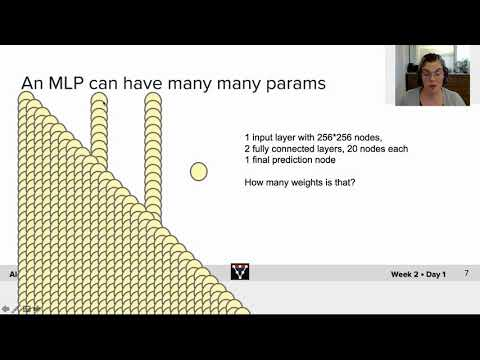

In [6]:
#@title Video 1: Introduction
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="85w6udyYo40", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

##Think! 0.1: Regularization & effective number of params
Let's think back to last week, when you learned about regularization.  Recall that regularization comes in several forms.  For example, L1 regularization adds a term to the loss function that penalizes based on the sum of the _absolute_ magnitude of the weights. Below are the results from training a simple multilayer perceptron with one hidden layer (b) on a simple toy dataset (a).

Below that are two graphics that show the effect of regularization on both the number of non-zero weights (d), and on the network's accuracy (c).
What do you notice?




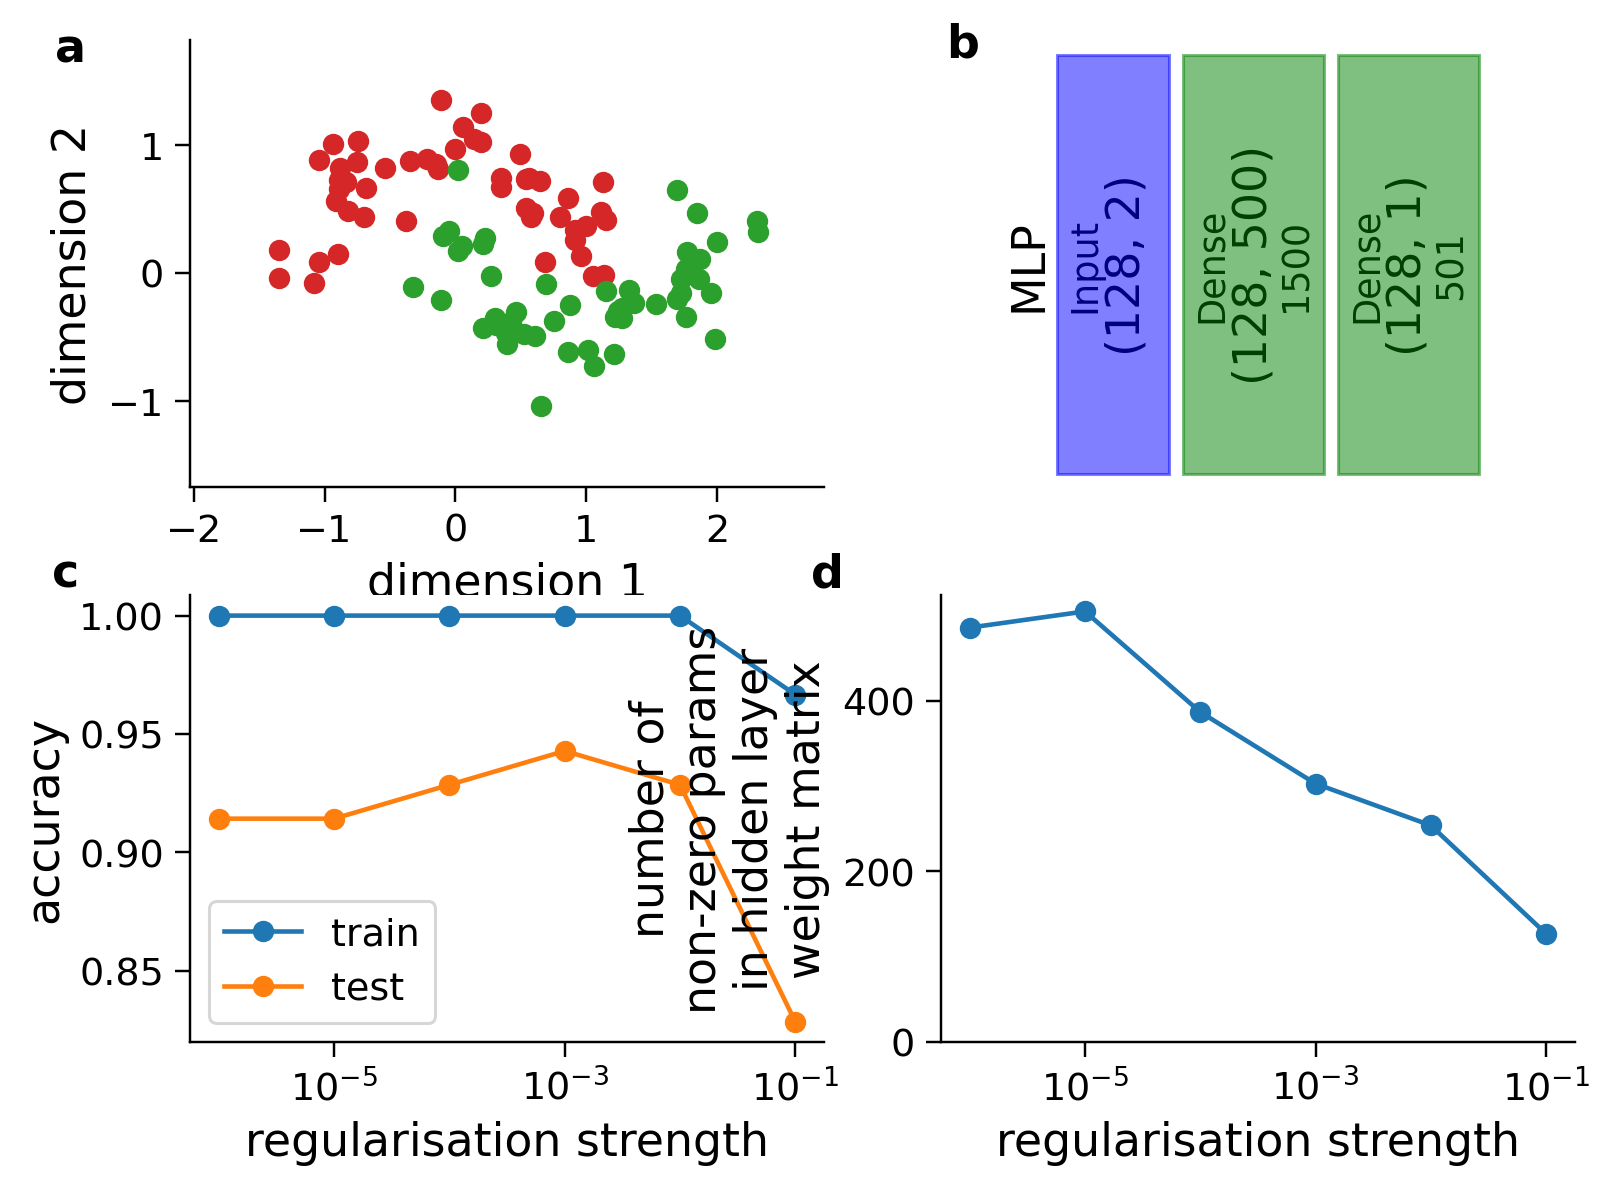

In [7]:
#@markdown L1 Regularisation
# grid search regularization values for moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
plt.figure(dpi=110)
plt.subplot(221)
plt.plot(X[y==0, 0], X[y==0, 1], "oC3")
plt.plot(X[y==1, 0], X[y==1, 1], "oC2")

ax = plt.subplot(222)
def addBox(x, y, w, h, color, text1, text2, text3):
    ax.add_patch(plt.Rectangle((x,y),w,h,
                                    fill=True, color=color, alpha=0.5, zorder=1000, clip_on=False
                                    ))
    plt.text(x + 0.02, y+h/2, text1, rotation=90, va="center", ha="center", size=12)
    plt.text(x + 0.05, y+h/2, text2, rotation=90, va="center", ha="center")
    plt.text(x + 0.08, y+h/2, text3, rotation=90, va="center", ha="center", size=12)

xx = 0.25
yy = 0.3
#sample_image = nn.tensor(np.zeros([28, 28]))
batch_size = 128
#sample_image=torch.rand(batch_size,28,28)

plt.text(0.23,yy+0.35/2, "MLP", rotation=90, color='k', ha="center", va="center")
if 1:
    addBox(xx,yy, 0.08, 0.35, "b",
           "Input",
           (batch_size, 2),
           ""
           )
    xx += 0.08+0.01
    addBox(xx, yy, 0.1, 0.35, "g",
           "Dense",
           (batch_size, 500),
           1500
           )
    xx += 0.11

    addBox(xx, yy, 0.1, 0.35, "g",
           "Dense",
           (batch_size, 1),
            501
           )
    xx += 0.11

# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# grid search values
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())
if 0:
    params = []
    all_data = []
    all_train, all_test = list(), list()
    for param in values:
        # define model
        model = Sequential()
        model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(param)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        # fit model
        model.fit(trainX, trainy, epochs=4000, verbose=0)
        # evaluate the model
        _, train_acc = model.evaluate(trainX, trainy, verbose=0)
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        print(model.layers[0])
        non_zero = np.sum(model.layers[0].weights[0]>0.01)
        print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc), non_zero, np.sum(model.layers[0].weights[0]>0.1), np.sum(model.layers[0].weights[0]>0.01), np.sum(model.layers[0].weights[0]>0.001), np.sum(model.layers[0].weights[0]>0.0001))
        params.append(non_zero)
        all_train.append(train_acc)
        all_test.append(test_acc)
        all_data.append([non_zero, train_acc, test_acc])
    np.savetxt(__file__[:-3]+"_alldata.text", all_data)
#all_data = np.loadtxt(__file__[:-3]+"_alldata.text")
all_data = np.array(
      [[127.        ,   0.96666664,   0.82857144],
       [254.        ,   1.        ,   0.9285714 ],
       [303.        ,   1.        ,   0.94285715],
       [387.        ,   1.        ,   0.9285714 ],
       [505.        ,   1.        ,   0.91428572],
       [486.        ,   1.        ,   0.91428572]])
params, all_train, all_test = all_data.T
# plot train and test means
plt.subplot(223)
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
plt.xlabel("regularisation strength")
plt.ylabel("accuracy")
plt.subplot(224)
plt.ylabel("number of parameters")
pyplot.semilogx(values, params, label='test', marker='o')
plt.xlabel("regularisation strength")

#% start: automatic generated code from pylustrator
plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
import matplotlib as mpl
plt.figure(1).axes[0].set_xlim(-2.027905671168, 2.8175961065615)
plt.figure(1).axes[0].set_ylim(-1.669149407152741, 1.8186736650690714)
plt.figure(1).axes[0].set_position([0.156250, 0.607083, 0.262672, 0.350230])
plt.figure(1).axes[0].spines['right'].set_visible(False)
plt.figure(1).axes[0].spines['top'].set_visible(False)
plt.figure(1).axes[0].text(0.5, 0.5, 'New Text', transform=plt.figure(1).axes[0].transAxes)  # id=plt.figure(1).axes[0].texts[0].new
plt.figure(1).axes[0].texts[0].set_position([-0.213819, 0.952084])
plt.figure(1).axes[0].texts[0].set_text("a")
plt.figure(1).axes[0].texts[0].set_weight("bold")
plt.figure(1).axes[0].get_xaxis().get_label().set_text("dimension 1")
plt.figure(1).axes[0].get_yaxis().get_label().set_text("dimension 2")
plt.figure(1).axes[1].set_xlim(0.1674801030101526, 0.6183302940798664)
plt.figure(1).axes[1].set_ylim(0.28932188140128723, 0.6620812534327816)
plt.figure(1).axes[1].set_xticks([np.nan])
plt.figure(1).axes[1].set_yticks([np.nan])
plt.figure(1).axes[1].set_xticklabels([""], fontsize=10.0, fontweight="normal", color="black", fontstyle="normal", fontname="DejaVu Sans", horizontalalignment="center")
plt.figure(1).axes[1].set_yticklabels([""], fontsize=10.0, fontweight="normal", color="black", fontstyle="normal", fontname="DejaVu Sans", horizontalalignment="right")
plt.figure(1).axes[1].set_position([0.544602, 0.580000, 0.352273, 0.350000])
plt.figure(1).axes[1].spines['bottom'].set_visible(False)
plt.figure(1).axes[1].spines['left'].set_visible(False)
plt.figure(1).axes[1].spines['right'].set_visible(False)
plt.figure(1).axes[1].spines['top'].set_visible(False)
plt.figure(1).axes[1].text(0.5, 0.5, 'New Text', transform=plt.figure(1).axes[1].transAxes)  # id=plt.figure(1).axes[1].texts[10].new
plt.figure(1).axes[1].texts[10].set_position([0.007662, 0.964286])
plt.figure(1).axes[1].texts[10].set_text("b")
plt.figure(1).axes[1].texts[10].set_weight("bold")
plt.figure(1).axes[2].set_position([0.103125, 0.139167, 0.312273, 0.320833])
plt.figure(1).axes[2].spines['right'].set_visible(False)
plt.figure(1).axes[2].spines['top'].set_visible(False)
plt.figure(1).axes[2].text(0.5, 0.5, 'New Text', transform=plt.figure(1).axes[2].transAxes)  # id=plt.figure(1).axes[2].texts[0].new
plt.figure(1).axes[2].texts[0].set_position([-0.218548, 1.019481])
plt.figure(1).axes[2].texts[0].set_text("c")
plt.figure(1).axes[2].texts[0].set_weight("bold")
plt.figure(1).axes[3].set_ylim(0.0, 523.9)
plt.figure(1).axes[3].set_position([0.635602, 0.139167, 0.292273, 0.320833])
plt.figure(1).axes[3].spines['right'].set_visible(False)
plt.figure(1).axes[3].spines['top'].set_visible(False)
plt.figure(1).axes[3].text(0.5, 0.5, 'New Text', transform=plt.figure(1).axes[3].transAxes)  # id=plt.figure(1).axes[3].texts[0].new
plt.figure(1).axes[3].texts[0].set_position([-0.205241, 1.019481])
plt.figure(1).axes[3].texts[0].set_text("d")
plt.figure(1).axes[3].texts[0].set_weight("bold")
plt.figure(1).axes[3].get_yaxis().get_label().set_text("number of\nnon-zero params\nin hidden layer\nweight matrix")
#% end: automatic generated code from pylustrator
pyplot.show()

##### Solution



Answer: When you increase the regularization strength you can see that the test accuracy improves (orange line in (c)) while the effective number of parameters goes down (d).  At a certain point, however, the regularization is too strong, and the accuracy declines ($10^{-1}$).

##### Coming Up

The rest of these lectures focus on another way to reduce parameters: weight-sharing.  Weight sharing is based on the idea that some sets of weights can be used at multiple points in a network.  We will focus mostly on CNNs today, where the weight sharing is across the 2D space of an image.  At the end we will touch briefly on Recurrent Neural Networks (RNNs), which share parameters across time.  Both of these weight sharing techniques (across space and time) can reduce the number of parameters and increase a network's ability to generalize.

# Section 1 Neuroscience motivation, General CNN structure

Video available at https://youtube.com/watch?v=atax83vMzPw


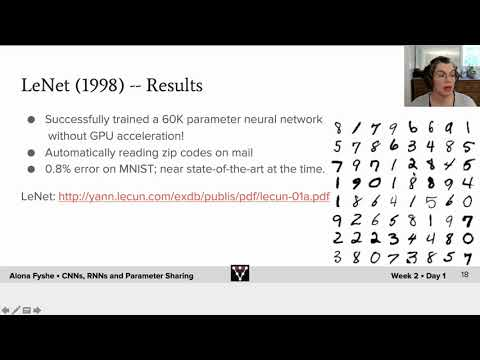

In [8]:
#@title Video 2: Representations & Visual processing in the brain
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="atax83vMzPw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Think! 1.1 What makes a representation good?
Representations have a long and storied history, having been studied by the likes of Aristotle back in 300 BC!!  Representations are not a new idea, and they certainly don't exist just in neural networks.

Take a moment with your pod to discuss what would make a good representation, and how that might differ depending on the task you train your CNN to do.

If there's time, you can also consider how the brain's representations might differ from a *learned* representation inside a NN.



# Section 2: Convolutions and Edge Detection

Fundamental to CNNs are convolutions. After all, that _is_ what the C in CNN stands for! Let's take a moment to define what a convolution is, practice performing a convolution, and implement it in code.  

Video available at https://youtube.com/watch?v=gw7Ezi12VFI


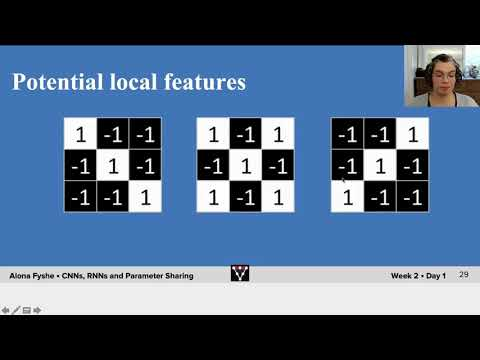

In [9]:
#@title Video 3: What is a Convolution?
import time 
try: t3; 
except NameError: t3=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="gw7Ezi12VFI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Before we jump into coding exercises, let's take a moment to look at this animation that steps through the process of convolution.  

Recall from the video that convolution involves sliding the kernel across the image, taking the element-wise product, and adding those products together.

![Our "convolution", or more precisely cross-correlation](http://d2l.ai/_images/correlation.svg)  
Source A. Zhang, Z. C. Lipton, M. Li and A. J. Smola,  _[Dive into Deep Learning](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)_

**Note:** You need to run the cell to activate the sliders, and again to run once changing the sliders.

**Tip:** In this animation, and all the ones that follow, you can hover over the parts of the code underlined in red to change them.

**Tip:** Below, the function is called `Conv2d` because the convolutional filter is a matrix with two dimensions (2D).  There are also 3D convolutions, but we won't talk about them today.

In [10]:
#@markdown ## Visualization of Convolution
%%html
<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">)<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=1<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="hidden" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="hidden" min="1" max="2" value="1">)</span></span>,
        padding=0<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="hidden" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="hidden" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="1">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->

 <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool" href="#">MaxPool2d</a>
    <a class="select_avgpool" href="#">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = undefined;
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length)
    if(last_pos != pos) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    for (var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ")");
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}
    <!--
dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}
-->
})();
</script>

### Definitional note ###


If you have a background in signal processing or math, you may have already heard of convolution. However, the definitions in signal/image processing and the one we use here are slightly different.  The former involves flipping the kernel horizontally and vertically before sliding.

**For our purposes, no flipping is needed. If you are familiar with the flipping method, just assume the kernel is pre-flipped.**

## Coding Exercise 2.1: Convolution of a Simple Kernel
At its core, convolution is just repeatedly multiplying a matrix, known as a _kernel_ or _filter_, with some other, larger matrix (in our case the pixels of an image). Consider the below image and kernel:

$$ \textbf{Image} = 
\begin{bmatrix}0 &252 &252 \\0 &0 &252 \\ 0 &0 &0  
\end{bmatrix} 
$$

$$ \textbf{Kernel} = 
\begin{bmatrix} \frac{1}{4} &\frac{1}{4} \\\frac{1}{4} & \frac{1}{4}
\end{bmatrix} 
$$

Perform (by hand) the operations needed to convolve the kernel and image above. Afterwards enter your results in the "solution" section in the code below. Discuss how the size of the output changes.


Original image:


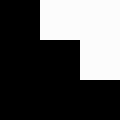

In [11]:
import numpy as np
original = np.array([
                     [0, 252, 252], 
                     [0,   0, 252], 
                     [0,   0,   0]]).astype(np.uint8)
#region collapse
# w, h = 512, 512
# data = np.zeros((h, w, 3), dtype=np.uint8)
# data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
#endregion

img_original = Image.fromarray(original, 'L')
print("Original image:")
display(img_original.resize((120,120), Image.NEAREST))

solution = np.array([
########### YOUR SOLUTION HERE #############
                    #  [x, x],
                    #  [x, x],
########### END OF SOLUTION #################
                    ]).astype(np.uint8)
if solution.shape[0] > 1:
  img_solution = Image.fromarray(solution, 'L')
  print("Convolution result:")
  display(img_solution.resize((80, 80), Image.NEAREST))

Original image:


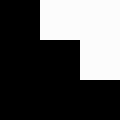

Convolution result:


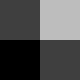

In [12]:
# to_remove solution
import numpy as np
original = np.array([
                     [0, 252, 252], 
                     [0,   0, 252], 
                     [0,   0,   0]]).astype(np.uint8)
#region collapse
# w, h = 512, 512
# data = np.zeros((h, w, 3), dtype=np.uint8)
# data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
#endregion

img_original = Image.fromarray(original, 'L')
print("Original image:")
display(img_original.resize((120,120), Image.NEAREST))

solution = np.array([
########### YOUR SOLUTION HERE #############
                      [63, 63*3],
                      [0,  63],
########### END OF SOLUTION #################
                    ]).astype(np.uint8)
if solution.shape[0] > 1:
  img_solution = Image.fromarray(solution, 'L')
  print("Convolution result:")
  display(img_solution.resize((80, 80), Image.NEAREST))

## Coding Exercise 2.2: Coding a Convolution
Here, we have the skeleton of a function that performs convolution using the provided kernel and image matrices. 

*Exercise:* Fill in the missing lines of code. You can test your function by uncommenting the sections beneath it.

Note: in general, you would use functions already available in `pytorch`/`numpy` to do convolutions.  We're coding it up here for practice.

In [13]:
def convolution2d(image, kernel):
    """
    Convolves the provided image (a greyscale image with each entry ranging from 0 to 255)
    with the provided kernel.

    arguments:
      image: A numpy matrix, which is (a list (column) of lists (rows) of pixels)
      kernel: A numpy matrix, which is (a list (column) of lists (rows) of pixels)
    outputs: A numpy matrix, the result of convolving the kernel over the image
    """
    im_y, im_x = image.shape
    ker_y, ker_x = kernel.shape
 
    # We assume we're working with a square kernel for simplicity.
    assert ker_y == ker_x, "Please use a square kernel"
 
    ######### YOUR SOLUTION HERE ##########
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define height and width of your output")
    ####################################################################
    out_y = ... # TODO: this will be the height of your output
    out_x = ... # TODO: this will be the width of your output
 
    convolved_image = np.zeros((out_y, out_x))

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Perform the actual convolution.")
    ####################################################################
    for i in range(out_y):
        for j in range(out_x):
            convolved_image[i][j] = ... # TODO now perform the actual convolution
 
    #########   END OF SOLUTION  ##########
    return convolved_image
 
### Uncomment below to test your function
# image = np.arange(9).reshape(3, 3)
# print("Image:\n",image)
# kernel = np.arange(4).reshape(2, 2)
# print("Kernel:\n",kernel)
# print("Convolved output:\n",convolution2d(image, kernel))
 
### Uncomment below to test your function on an image
# with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
#     img_skyline_orig = Image.open(skyline_image_file)
#     img_skyline_mat = np.asarray(img_skyline_orig)
#     kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
#     kernel2 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
#     img_processed_mat = convolution2d(img_skyline_mat, kernel)
#     img_processed_mat2 = convolution2d(img_skyline_mat, kernel2)
#     img_processed_mat = np.sqrt(np.multiply(img_processed_mat, img_processed_mat) + np.multiply(img_processed_mat2, img_processed_mat2))
 
#     img_processed_mat *= 255.0/img_processed_mat.max()
#     img_processed_mat = img_processed_mat.astype(np.uint8)
#     img_processed = Image.fromarray(img_processed_mat, 'L')
#     display(img_skyline_orig)
#     display(img_processed)

In [14]:
# to_remove solution
def convolution2d(image, kernel):
    """
    Convolves the provided image (a greyscale image with each entry ranging from 0 to 255)
    with the provided kernel.

    arguments:
      image: A numpy matrix, which is (a list (column) of lists (rows) of pixels)
      kernel: A numpy matrix, which is (a list (column) of lists (rows) of pixels)
    outputs: A numpy matrix, the result of convolving the kernel over the image
    """
    im_y, im_x = image.shape
    ker_y, ker_x = kernel.shape
 
    # We assume we're working with a square kernel for simplicity.
    assert ker_y == ker_x, "Please use a square kernel"
 
    ######### YOUR SOLUTION HERE ##########

    out_y = im_y - ker_y + 1 # TODO: this will be the height of your output
    out_x = im_x - ker_x + 1 # TODO: this will be the width of your output
 
    convolved_image = np.zeros((out_y, out_x))
    for i in range(out_y):
        for j in range(out_x):
            convolved_image[i][j] = np.sum(image[i:i+ker_y, j:j+ker_x]*kernel) # TODO now perform the actual convolution
 
    #########   END OF SOLUTION  ##########
    return convolved_image
 
### Uncomment below to test your function
# image = np.arange(9).reshape(3, 3)
# print("Image:\n",image)
# kernel = np.arange(4).reshape(2, 2)
# print("Kernel:\n",kernel)
# print("Convolved output:\n",convolution2d(image, kernel))
 
### Uncomment below to test your function on an image
# with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
#     img_skyline_orig = Image.open(skyline_image_file)
#     img_skyline_mat = np.asarray(img_skyline_orig)
#     kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
#     kernel2 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
#     img_processed_mat = convolution2d(img_skyline_mat, kernel)
#     img_processed_mat2 = convolution2d(img_skyline_mat, kernel2)
#     img_processed_mat = np.sqrt(np.multiply(img_processed_mat, img_processed_mat) + np.multiply(img_processed_mat2, img_processed_mat2))
 
#     img_processed_mat *= 255.0/img_processed_mat.max()
#     img_processed_mat = img_processed_mat.astype(np.uint8)
#     img_processed = Image.fromarray(img_processed_mat, 'L')
#     display(img_skyline_orig)
#     display(img_processed)

Great!

## Wrap-up: Demonstration of a CNN in PyTorch
At this point, you should have a fair idea of how to perform a convolution on an image given a kernel. In the following cell, we provide a code snippet that demonstrates setting up a convolutional network using PyTorch.

Next, we will look at the **nn** module in PyTorch. The **nn** module contains a plethora of functions that will make implementing a neural network easier. In particular we will look at the **nn.Conv2d()** function that creates the convolution layer. 

The Conv2d function makes things easier and simpler because PyTorch takes care all the operations for us and we don't need to code the convolution operation from scratch. Given the parameters such as the number of input and output channels, kernel_size, and padding, we will have a convolution operation ready for use.

See the code below, where we define the convolution layer by calling **nn.Conv2d()**.

In [15]:
import torch
import torch.nn as nn

class Net(nn.Module):
  """
  A convolutional neural network.
  Applies a convolution to a provided matrix when constructed and an associated 
  method is produced with to()      i.e. Net(...).to(...)(image)
  """
  def __init__(self, kernel=None, padding=0):
    super(Net, self).__init__()
    # Summary of the nn.conv2d parameters (you can also get this by hovering over the method):
    # in_channels (int): Number of channels in the input image
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=padding)
      
    # set up a default kernel if a default one isn't provided
    if kernel is not None:
      dim1, dim2 = kernel.shape[0], kernel.shape[1]
      kernel = kernel.reshape(1, 1, dim1, dim2)
  
      self.conv1.weight = torch.nn.Parameter(kernel)
      self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
            
  def forward(self, x):
    x = self.conv1(x)
    return x


In [16]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))
# Prepare the network with that default kernel
net = Net(kernel=kernel, padding=0).to(device)

# set up a 3x3 image matrix of numbers from 0 through 8 
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(device) # BatchSize X Channels X Height X Width

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image) # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], device='cuda:0', grad_fn=<AddBackward0>)


As a quick aside, notice the difference in the input and output size. The input had a size of 3×3, and the output is of size 2×2. This is because of the fact that kernel can't produce values for the edges of the image - when it slides to an end of the image and is centered on a border pixel, it overlaps space outside of the image that is undefined. If we don't want to lose that information, we will have to pad the image with some defaults (such as 0s) on the border. This process is, somewhat predictably, called *padding*.

In [17]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))
# Prepare the network with the aforementioned default kernel, but this time with padding
net = Net(kernel=kernel, padding=1).to(device)
output = net(image) # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], device='cuda:0', grad_fn=<AddBackward0>)


Video available at https://youtube.com/watch?v=ZjI2r2A8CcU


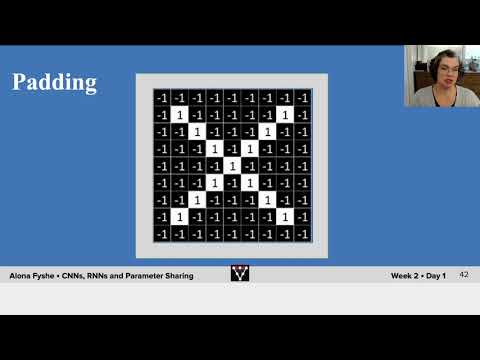

In [18]:
#@title Video 4: Padding and Edge Detection

import time
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="ZjI2r2A8CcU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Before we start in on the exercises, here's visualization to help you think about padding.

In [19]:
#@markdown ## Visualization of Convolution with Padding and Strides
#@markdown Recall that padding adds rows and columns of zeros to the outside edge of an image, and stride length adjusts the distance by which a filter is shifted after each convolution.  Change the padding and strides and see how this affects the shape of the output. How does the filter size and the padding need to be configured to keep the shape of the input?
%%html
<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_padding" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!-- default -- >
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=1<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="hidden" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="hidden" min="1" max="2" value="1">)</span></span>,
        padding=0<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="hidden" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="hidden" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->
        <!-- padding -->
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="3">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="1"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="1">)</span></span>)<br>
        result = conv(input)


 <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool" href="#">MaxPool2d</a>
    <a class="select_avgpool" href="#">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_padding")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = undefined;
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length)
    if(last_pos != pos) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    for (var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ")");
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}
    <!--
dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}
-->
})();
</script>

## Think! 2.3: Edge Detection

One of the simpler tasks performed by a convolutional layer is edge detection, that is, finding a place in the image where there is a large and abrupt change in color. Edge-detecting filters are usually learned by the first layers in a CNN. Observe the following simple kernel and discuss whether this will detect vertical edges (where the trace of the edge is vertical; i.e. there is a boundary between left and right), or whether it will detect horizontal edges (where the trace of the edge is horizontal; i.e. there is a boundary between top and bottom).

$$ \textbf{Kernel} = 
\begin{bmatrix} 1 & -1 \\ 1 & -1
\end{bmatrix} 
$$

In [20]:
#@title 2.3.1: Kernel Intuition
answer = "" #@param {type:"string"}

In [21]:
# to_remove explanation

"""
It will detect vertical edges.

Consider a part of the image where values on the left are high and values on the
right are low. In this case, applying the kernel, the high values will be 
maintained and the low values will be inverted, yielding a very-positive sum.

Now reverse the situation - values on the left are low and values on the right 
are high. In this case, applying the kernel, the low values will be maintained
and the high values will be inverted, yielding a very-negative sum.

In any situation on the image where the left and right sides of a 2x2 block 
/aren't/ much different, applying the kernel will result in decent degree of 
cancellation - i.e. if it's all, say, 5, (5 + -5 + 5 + -5) = 0.

In other words, the only situations where you'll have an extremely positive or
extremely negative score are when you have a high value on either the left/right
and a low value on the other side.
"""

"\nIt will detect vertical edges.\n\nConsider a part of the image where values on the left are high and values on the\nright are low. In this case, applying the kernel, the high values will be \nmaintained and the low values will be inverted, yielding a very-positive sum.\n\nNow reverse the situation - values on the left are low and values on the right \nare high. In this case, applying the kernel, the low values will be maintained\nand the high values will be inverted, yielding a very-negative sum.\n\nIn any situation on the image where the left and right sides of a 2x2 block \n/aren't/ much different, applying the kernel will result in decent degree of \ncancellation - i.e. if it's all, say, 5, (5 + -5 + 5 + -5) = 0.\n\nIn other words, the only situations where you'll have an extremely positive or\nextremely negative score are when you have a high value on either the left/right\nand a low value on the other side.\n"

Consider the image below, which has three vertical stripes: black in the middle, flanked by white. This is like a very zoomed-in vertical edge within an image!

[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]


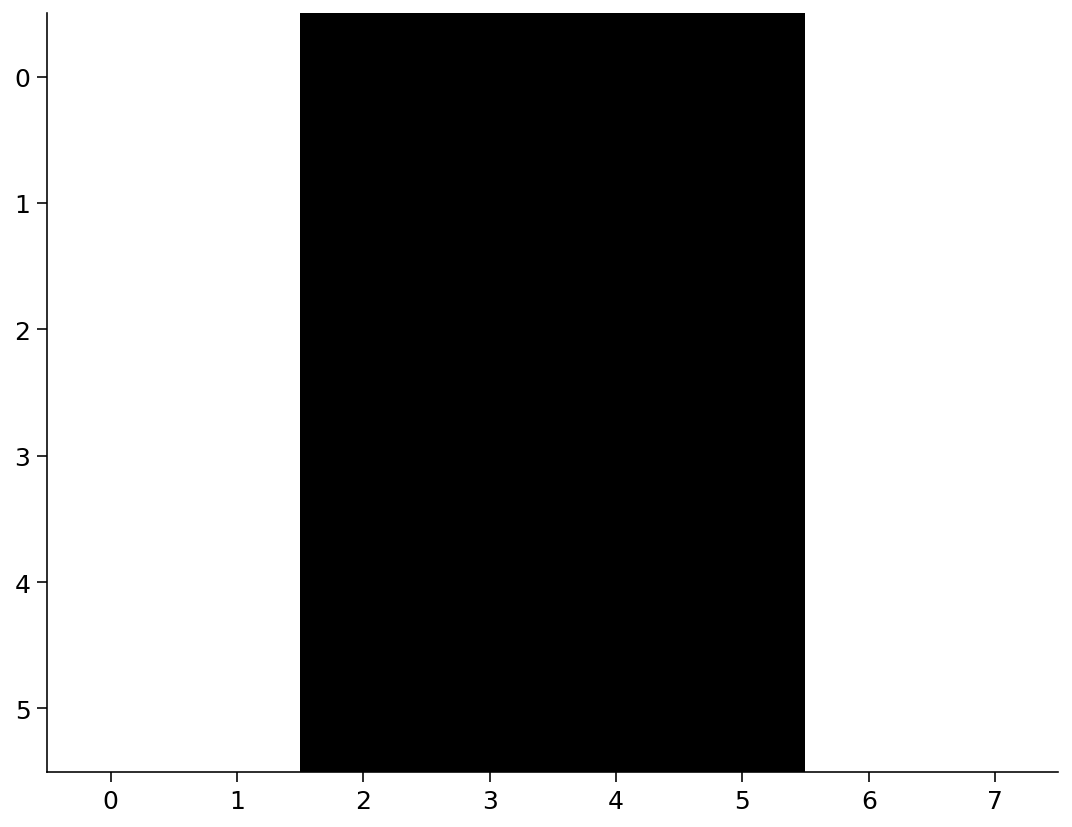

In [22]:
# Prepare an image that's basically just a vertical black stripe
X = np.ones((6, 8))
X[:, 2:6] = 0
print(X)
plt.imshow(X, cmap=plt.get_cmap('gray'))
plt.show()

[[ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]]


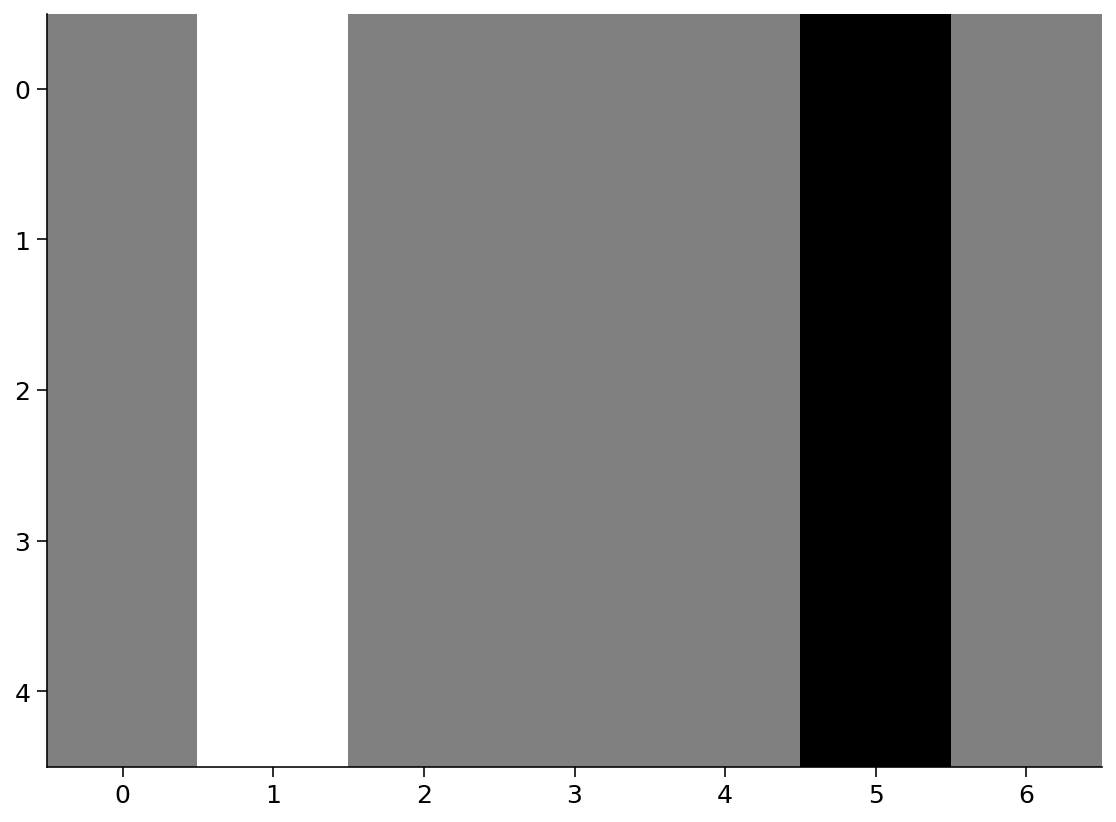

In [23]:
# Format the image that's basically just a vertical stripe
image = torch.from_numpy(X)
image = image.reshape(1, 1, 6, 8) # BatchSize X Channels X Height X Width

# Prepare a 2x2 kernel with 1s in the first column and -1s in the 
# This exact kernel was discussed above!
kernel = torch.Tensor([[1.0, -1.0],[1.0, -1.0]])
net = Net(kernel=kernel)

# Apply the kernel to the image and prepare for display
processed_image = net(image.float())
processed_image = processed_image.reshape(5, 7).detach().numpy()
print(processed_image)
plt.imshow(processed_image, cmap=plt.get_cmap('gray'))
plt.show()

As you can see, this kernel detects vertical edges (the black stripe corresponds to a highly positive result, while the white stripe corresponds to a highly negative result. However, to display the image, all the pixels are normalized between 0=black and 1=white).

If the kernel were transposed (i.e. the columns become rows and the rows become columns), what would the kernel detect? What would be produced by running this kernel on the vertical edge image above?

In [24]:
#@title 2.3.2 Kernel Transposition
answer = '' #@param {type:"string"}

In [25]:
# to_remove explanation

"""
If the kernel were transposed, it would detect horizontal edges. 

Running it on the vertical edge would result in 0s - you'd have no change going from
top to bottom, so you'd be adding and subtracting the same value.

(If you're confused as to why this shows up as black, rather than gray, it's because
of how the image is normalized)
"""

"\nIf the kernel were transposed, it would detect horizontal edges. \n\nRunning it on the vertical edge would result in 0s - you'd have no change going from\ntop to bottom, so you'd be adding and subtracting the same value.\n\n(If you're confused as to why this shows up as black, rather than gray, it's because\nof how the image is normalized)\n"

---
# Section 3: Pooling and Subsampling

*Estimated Completion Time: 110 minutes from start of the tutorial*

To visualize the various components of a CNN, we will build a simple CNN step by step. Recall that the MNIST dataset consists of binarized images of handwritten digits. This time we will be using the EMNIST letters dataset, which consists of binarized images of handwritten characters ($A ... Z$).

We will simplify the problem further by only keeping the images that correspond to $X$ (labeled as 24 in the dataset) and $O$ (labeled as 15 in the dataset).  Then we will train a CNN to classify an image either an $X$ or an $O$.

In [26]:
#@title Dataset/DataLoader Functions
#@markdown Run this cell

# loading the dataset 
def get_Xvs0_dataset():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    emnist_train = datasets.EMNIST(root='./data', split='letters', download=True, train=True, transform=transform)
    emnist_test = datasets.EMNIST(root='./data', split='letters', download=True, train=False, transform=transform)

    # only want O (15) and X (24) labels 
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]  

    # convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test

def get_data_loaders(train_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    
    return train_loader, test_loader

In [27]:
emnist_train, emnist_test = get_Xvs0_dataset()
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test)

# index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's view a couple samples from the dataset.

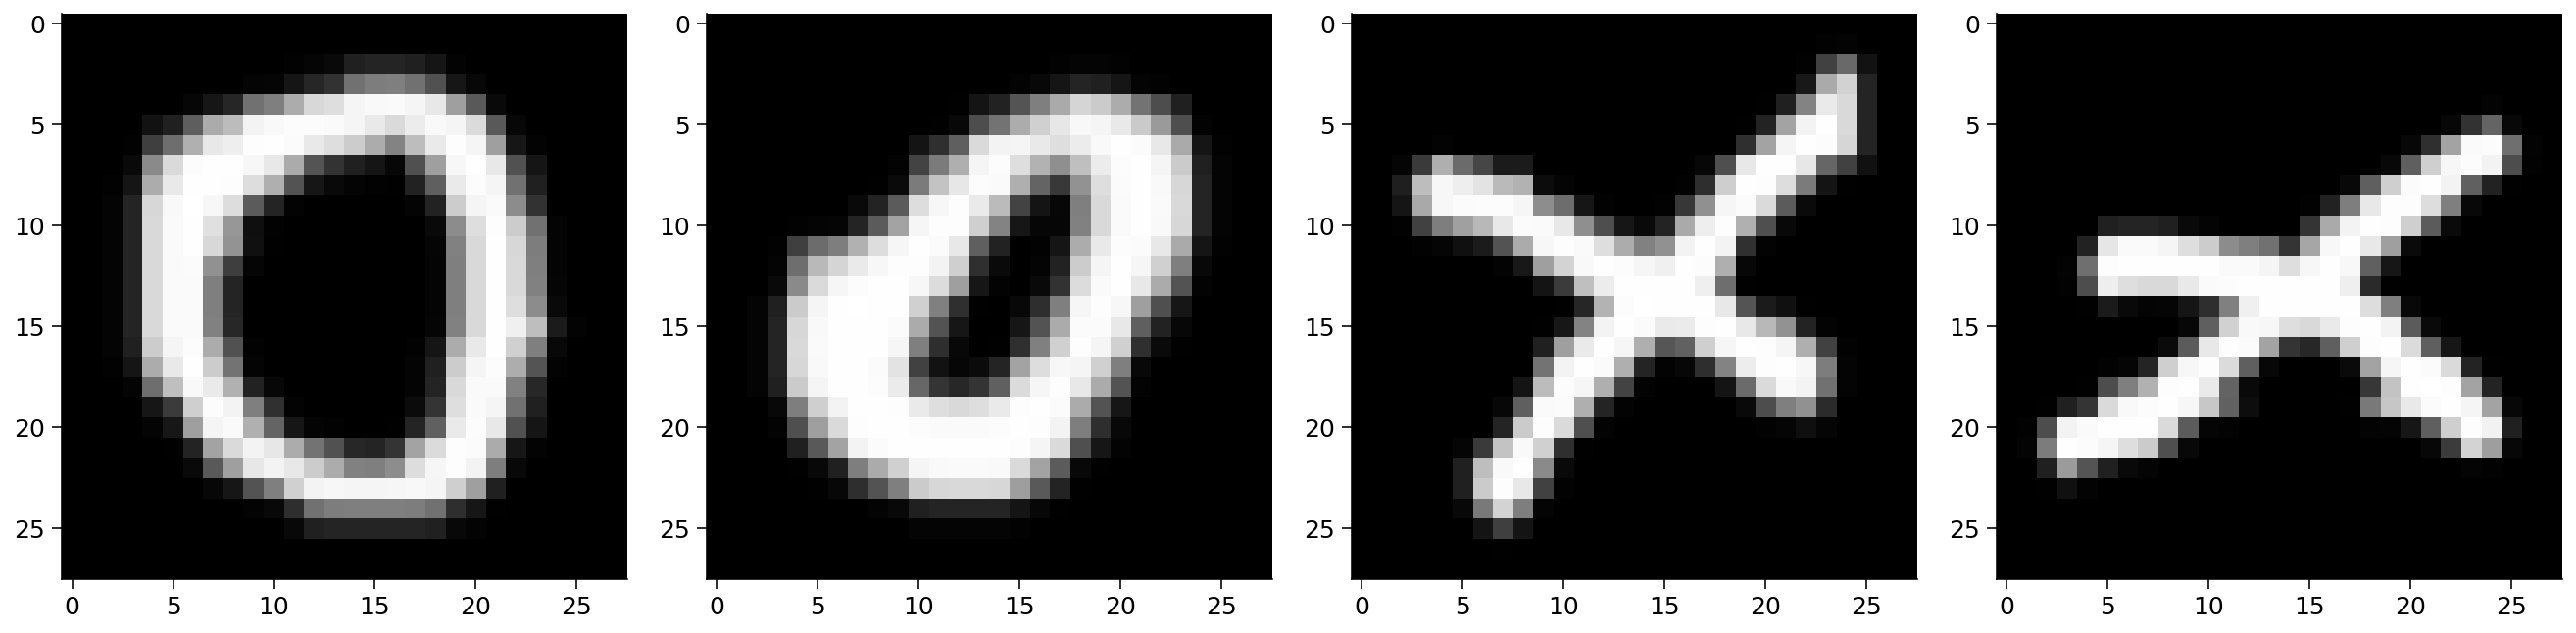

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Great! Now, it's time to watch a video explaining the different components of a CNN.

Video available at https://youtube.com/watch?v=Z3_0QVGTyOA


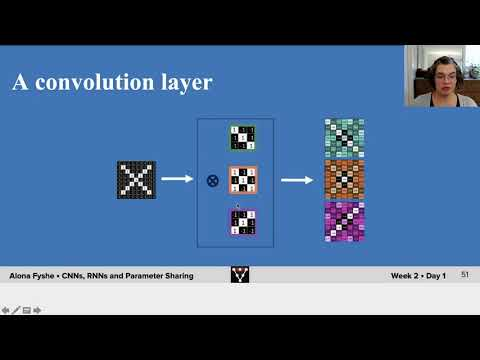

In [29]:
#@title Video 5: Multiple Filters, ReLU and Max Pool
import time
try: t5;
except NameError: t5=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="Z3_0QVGTyOA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [30]:
#@markdown ## Visualization of Convolution with Multiple Filters
#@markdown Change the number of input channels (e.g. the color channels of an image or the output channels of a previous layer) and the output channels (number of different filters to apply).
%%html
<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_filters" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!-- default -- >
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=1<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="hidden" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="hidden" min="1" max="2" value="1">)</span></span>,
        padding=0<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="hidden" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="hidden" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->
        <!-- padding
        import torch<br><br>
        input = torch.rand(1, 1<input class="input_matrixz" type="hidden" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.Conv2d(in_channels=1<input class="input_matrixzB" type="hidden" min="1" max="3" value="1">, out_channels=1<input class="input_filterz" type="hidden" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="3">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="1"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="1">)</span></span>)<br>
        result = conv(input)
-->
    <!-- filters -->
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="3">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="3">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="2">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)

 <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">))<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool" href="#">MaxPool2d</a>
    <a class="select_avgpool" href="#">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
-->
    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_filters")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = undefined;
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? (filter.length != 1? `Filter ${zz}` : `Filter`) : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length * filter[0].length)
    var [i2, z2] = divmod(i2, filter[0].length)
    subpos = Math.floor(subpos/filter[0].length)
    console.log(zz, i, j, j2, i2, z2)
    if(last_pos != pos || 1) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    let max_z = (ii == j2 && jj == i2) ? z2+1 : filter[0].length
                    for (var z = 0; z < max_z; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                        console.log(z, z2, text)
                    }
                    console.log("----------")
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ((filter[0].length==max_z)?")":""));
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        if(last_pos != pos)
            c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    let matrixpos = (i + j2) * matrix[0][0].length + (j + i2)
    m.g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"))
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == matrixpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
    })
    f[zz].g.selectAll(".matrix_layer").each(function(p, j){
        console.log(d3.select(this).select("highlight2"), subpos, i2, j2, z2)
        d3.select(this).selectAll(".cell").attr("opacity", (d,i) => (i == subpos && j > z2 && subpos < filter[0][0].length * filter[0][0][0].length) ? 0 : 1 );
        d3.select(this).select(".highlight2").style("stroke", (d,i) => (j != z2) ? "transparent" : "rgb(229, 132, 66)");
        //d3.select(this).select(".highlight1").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
        //d3.select(this).select(".highlight3").style("stroke", (d,i) => (j == z2) ? "visible" : "hidden");
    })

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length * filter[0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}

//dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
//dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}

})();
</script>

### Multiple Filters

The following network sets up 3 filters and runs them on an image of the dataset from the $X$ class.  Note that we are using the filters from the videos! 

In [31]:
class Net2(nn.Module):
  def __init__(self, kernel=None, padding=0):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                           padding=padding)

    # first kernel - leading diagonal
    kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1],
                                             [-1, 1, -1],
                                             [-1, -1, 1]]), 0)

    # second kernel -checkerboard pattern
    kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, 1]]), 0)

    # third kernel - other diagonal
    kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, -1]]), 0)

    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

  def forward(self, x):
    x = self.conv1(x)
    return x

In [32]:
net2 = Net2().to(device)

In [33]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of $X$ and $O$ that we want to run the filters on.

ORIGINAL IMAGES


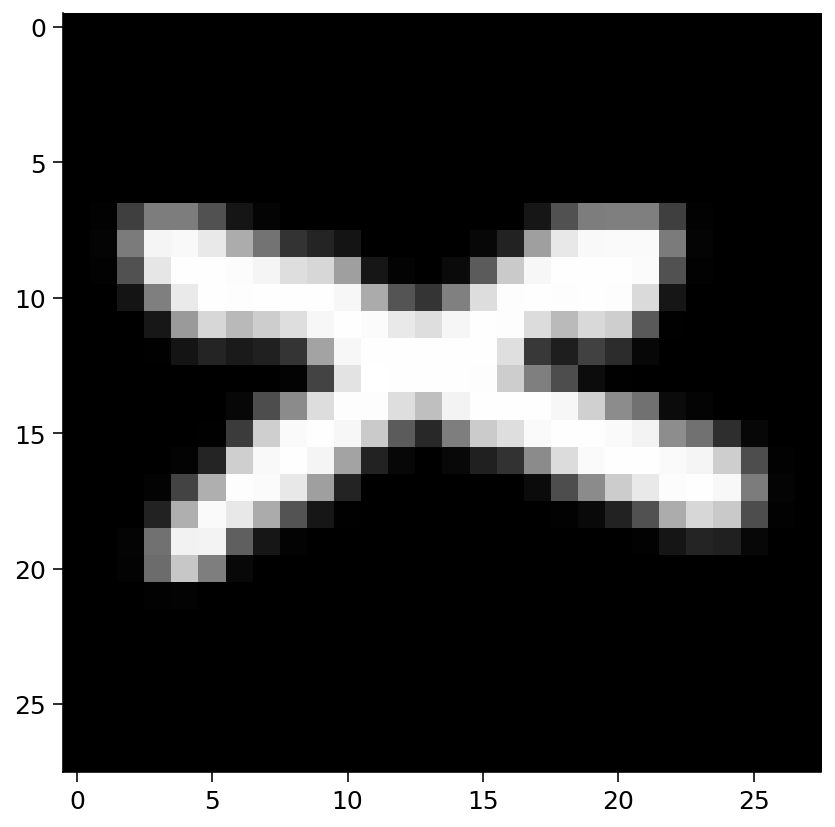

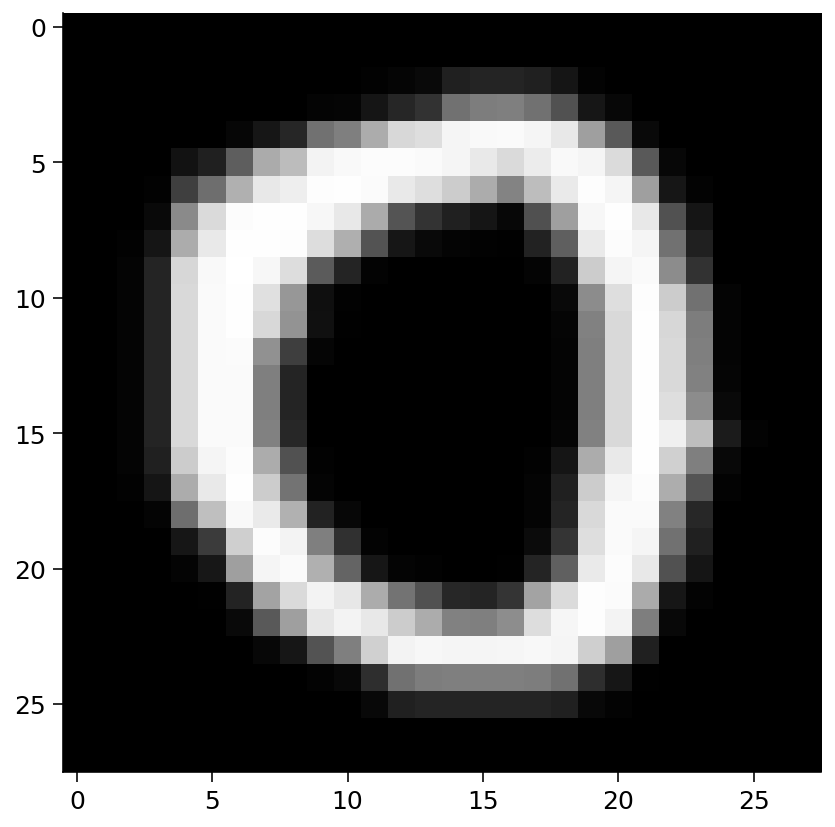

In [34]:
print("ORIGINAL IMAGES")
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()

CONVOLVED IMAGES


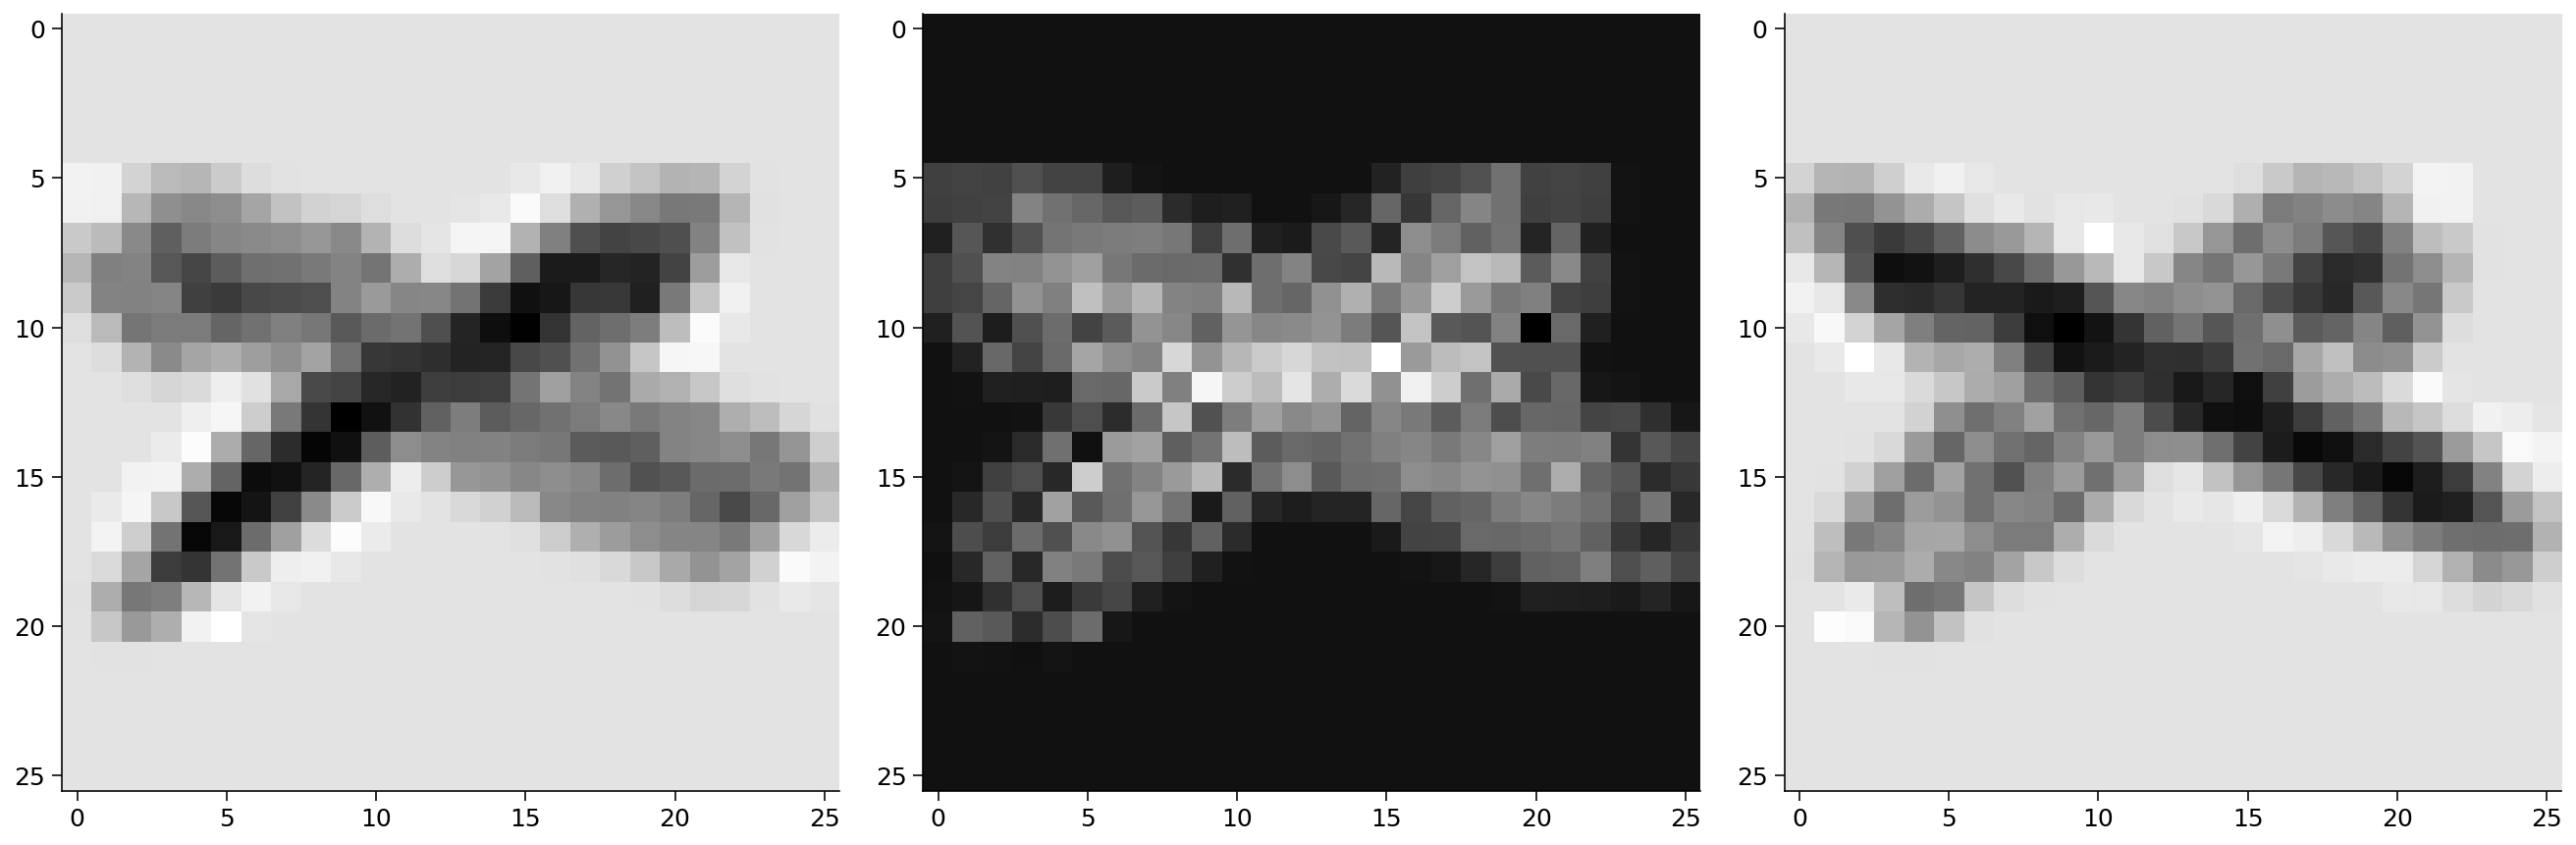

In [35]:
print("CONVOLVED IMAGES")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

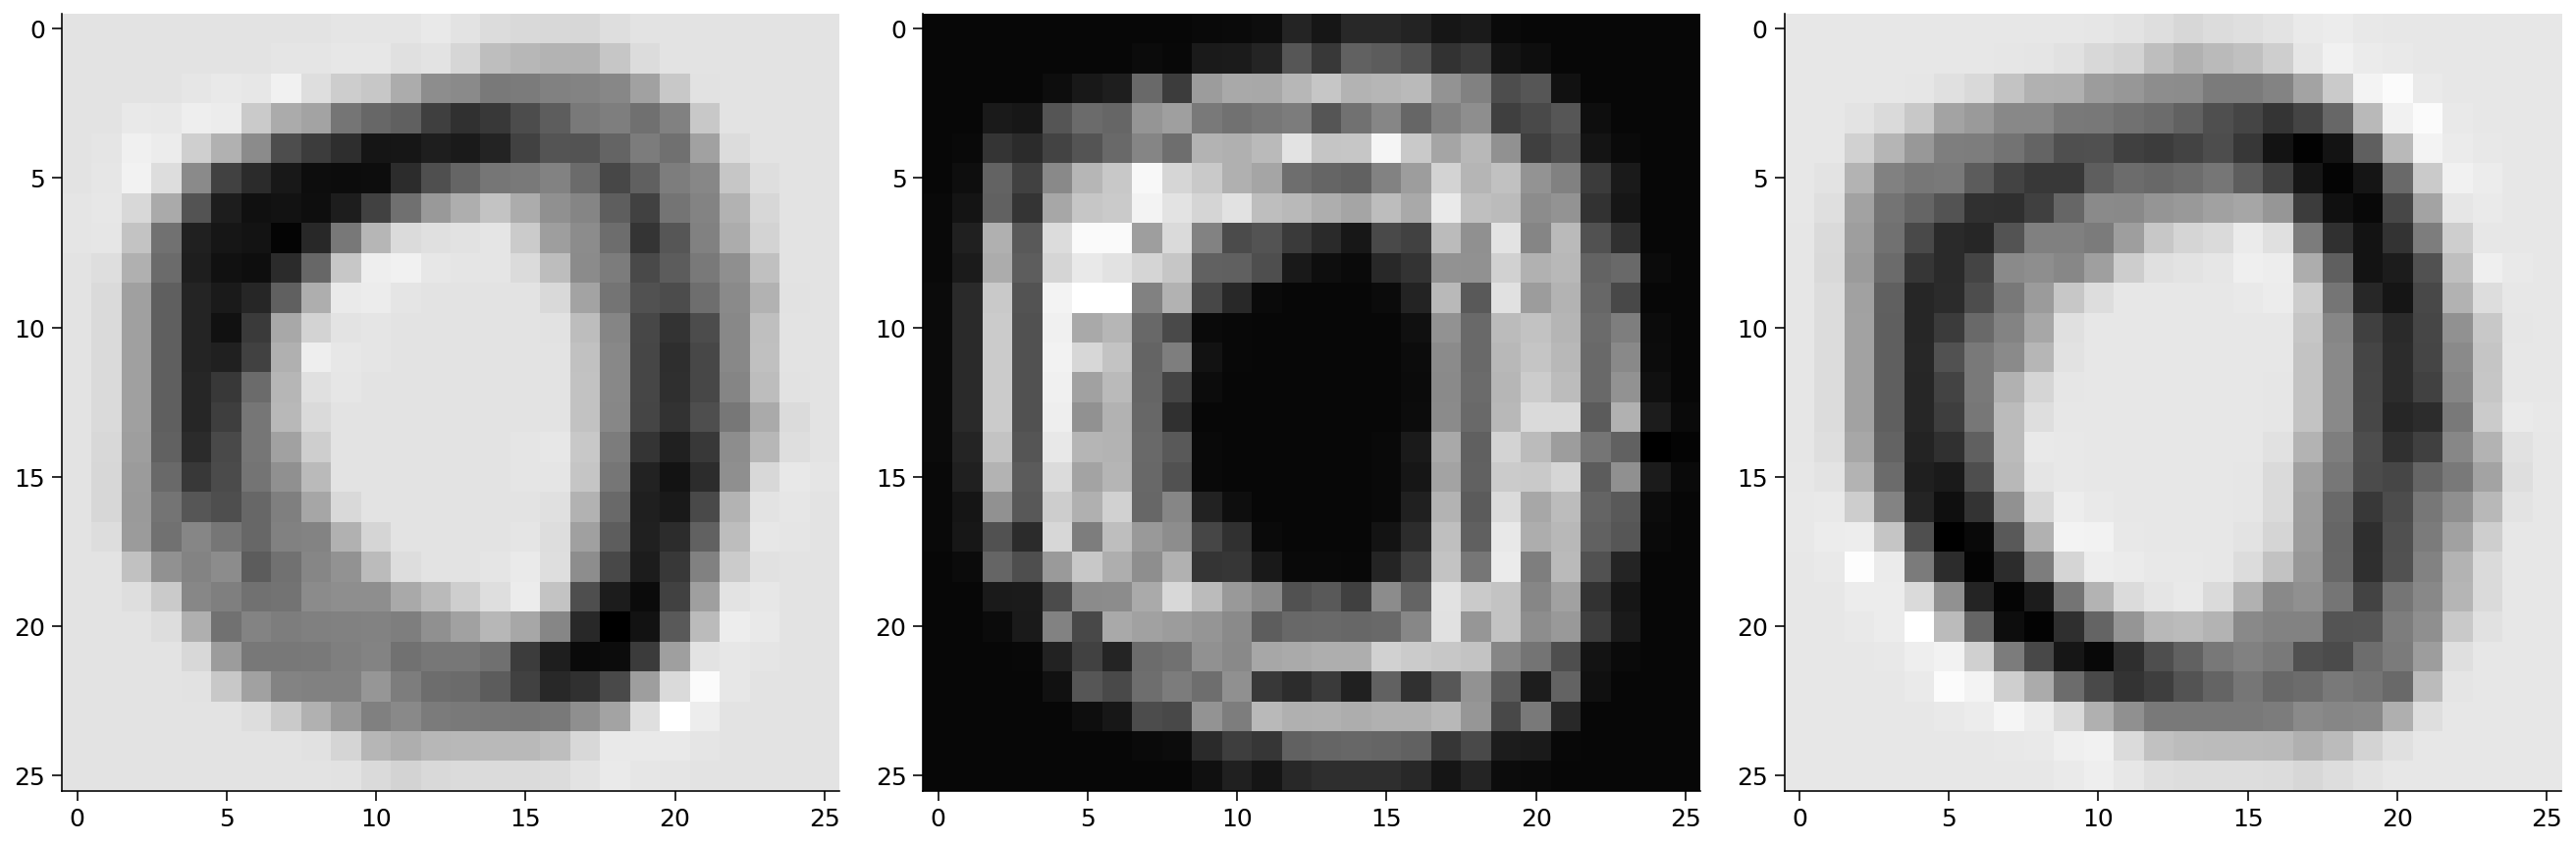

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

In [37]:
#@markdown ## Think! 
#@markdown Do you see how these filters would help recognize an X?
multiple_filters = 'multiple filters sample response, 95 mins elapsed' #@param {type:"string"}

### RELU after convolutions

Up until now we've talked about the convolution operation, which is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex. 

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

The ReLU function is shown below.




<figure>
    <center><img src=https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png width=400px>
    <figcaption>The Rectified Linear Unit (ReLU) Activation Function</figcaption>
    </center>
</figure>

Now let us incorporate ReLU into our previous model and visualize the output.

In [38]:
class Net3(nn.Module):
  def __init__(self, kernel=None, padding=0):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                           padding=padding)
    
    # first kernel - leading diagonal
    kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1],
                                             [-1, 1, -1],
                                             [-1, -1, 1]]), 0)

    # second kernel - checkerboard pattern
    kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, 1]]), 0)

    # third kernel - other diagonal
    kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, -1]]), 0)

    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    return x

In [39]:
net3 = Net3().to(device)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net3(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net3(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

RECTIFIED OUTPUTS


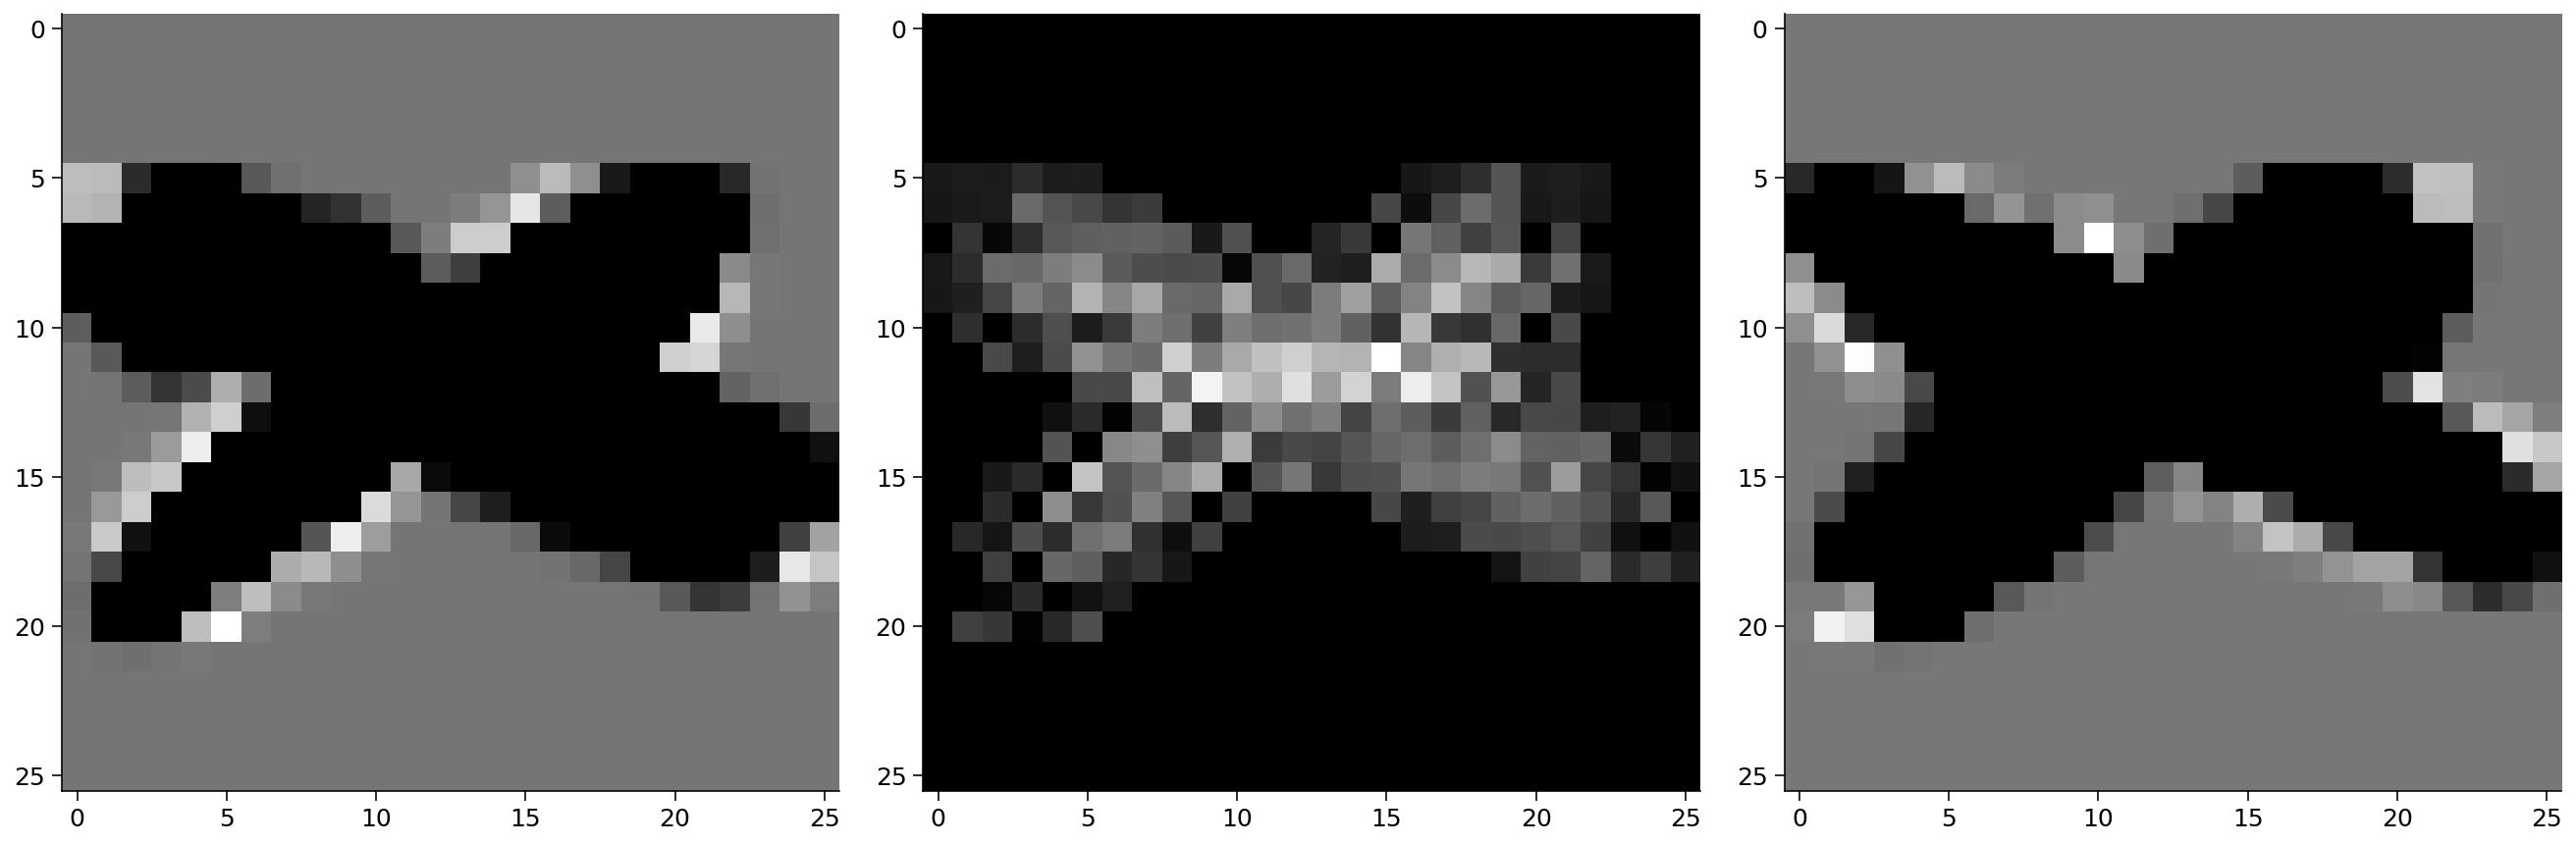

In [40]:
print("RECTIFIED OUTPUTS")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

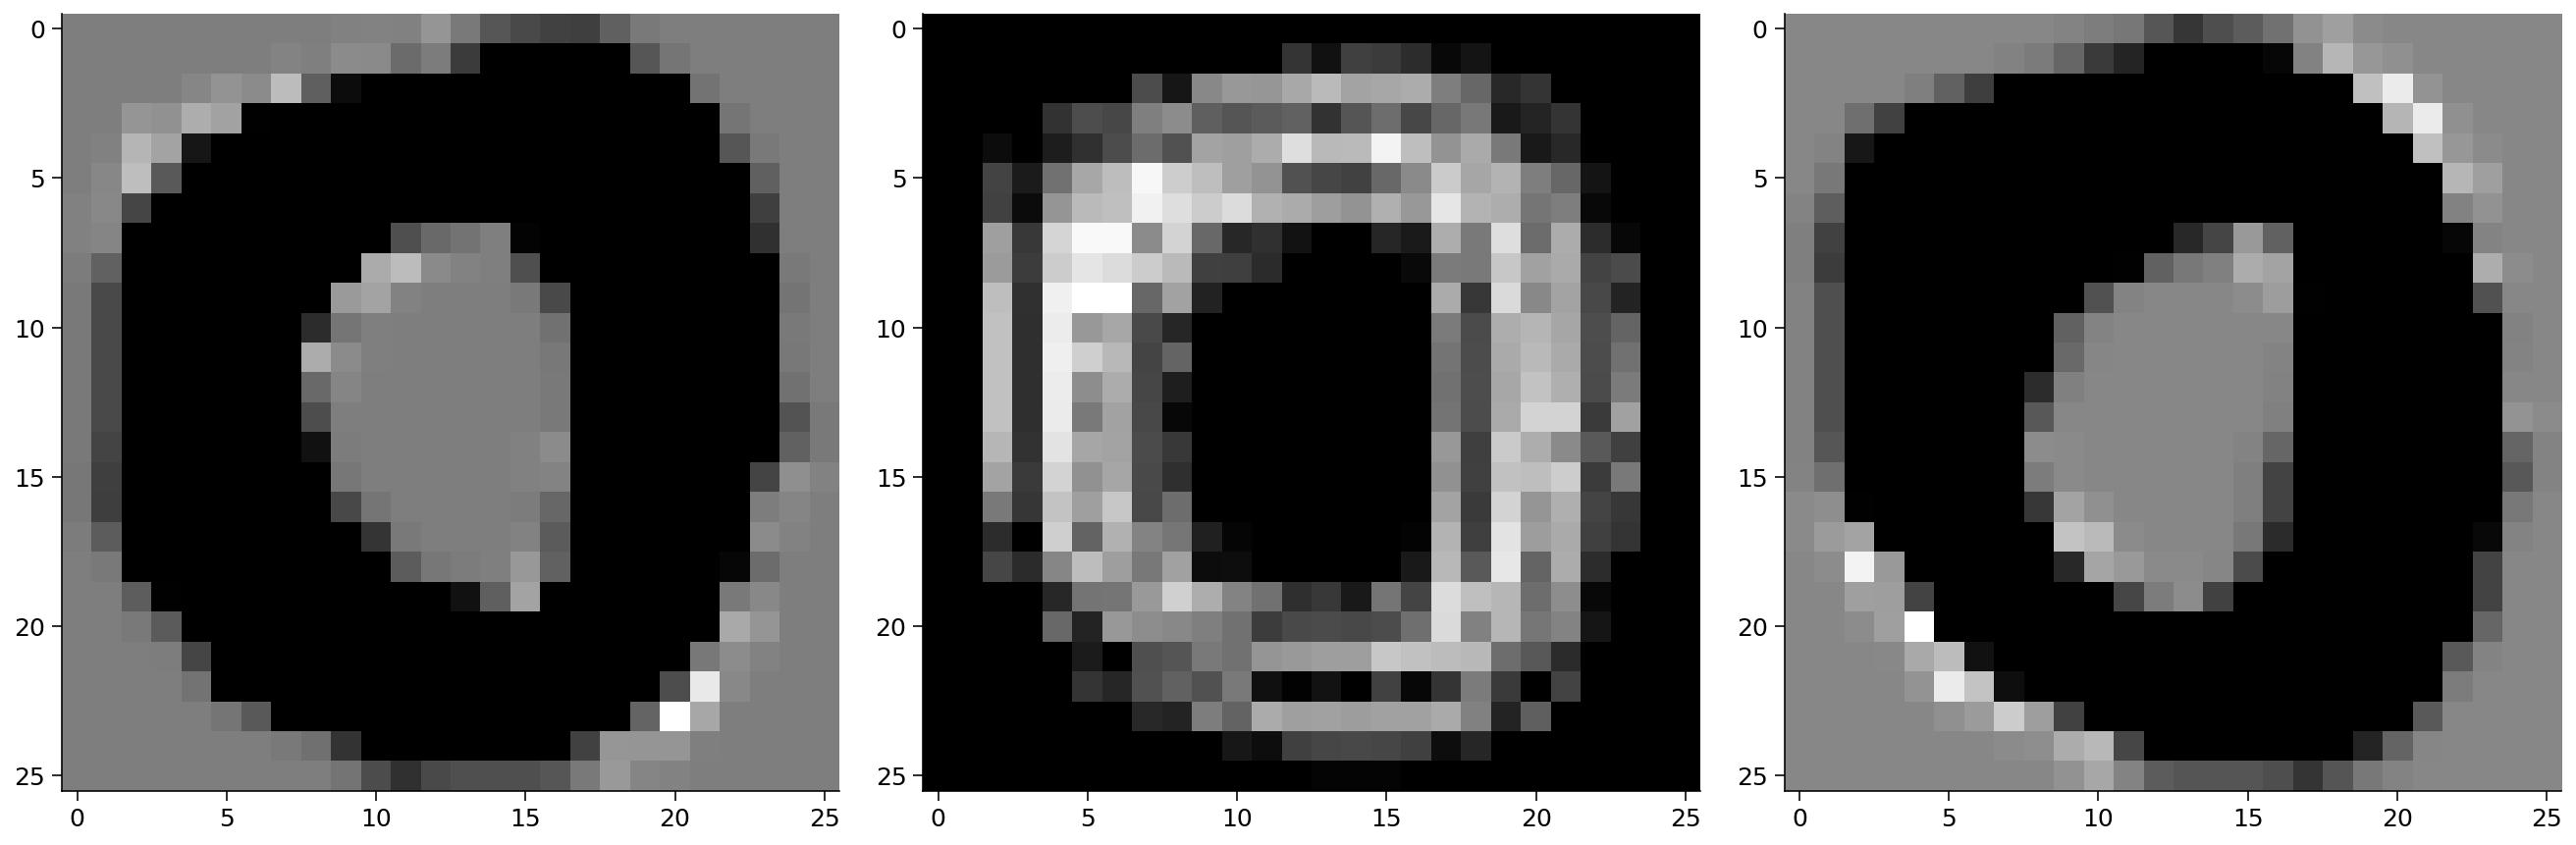

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Discuss with your pod how the ReLU activations help strengthen the features necessary to detect an $X$.

[Here's](https://stats.stackexchange.com/a/226927) an discussion which talks about how relu is useful as an activation funciton. 

Here's another excellent [discussion](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks?sfb=2) on the advantages of using ReLU

Video available at https://youtu.be/Hb85FcPdL0U


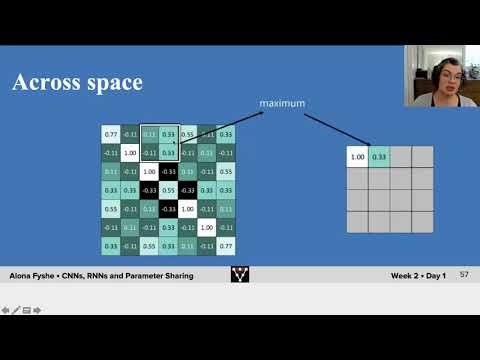

In [42]:
#@title Video 6: Pooling

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Hb85FcPdL0U", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video



## Pooling

Convolutional layers create feature maps that summarize the presence of particular features (e.g. edges) in the input. However, these feature maps record the _precise_ position of features in the input. That means that small changes to the position of an object in an image can result in a very different feature map. But a cup is a cup (and an $X$ is an $X$) no matter where it appears in the image!  We need to incorporate _translational invariance_.

A common approach to this problem is called downsampling. Downsampling creates a lower resolution version of an image, retaining the large structural elements and removing some of the fine detail that may be less relevant to the task. In CNNs, Max Pooling and Average Pooling are used to downsample.  These operations shrink the size of the hidden layers, and produce features that are more translationally invariant, which can be better leveraged by subsequent layers.

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input.  As with filters, we can change the shape of the window and the size of the stride.  And, just like with filters, every time we apply a pooling operation, we produce a single output. 

Pooling performs a kind of information compression that provides summary statistics for a _neighborhood_ of the input.
- In Maxpooling, we compute the maximum value of all pixels in the pooling window.
- In Avgpooling, we compute the average value of all pixels in the pooling window.

The example below shows the result of Maxpooling within the yellow pooling windows to create the red pooling output matrix.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, A small change in the features of the underlying image won't make a huge difference to the output.

Note that, unlike a convolutional layer, the pooling layer contains no learned parameters! Pooling just computes a pre-determined summary of the input and passes that along.  Compare that to the convolutional layer, where there are filters to be learned. 


In [43]:
#@markdown The following animation depicts how changing the stride changes the output. The stride defines how much the pooling region is moved over the input matrix to produce the next output (red arrows in the animation).  Give it a try! Change the stride and see how it affects the output shape.  You can also try MaxPool or AvgPool.
%%html
<style>
    svg {
        #border: 1px solid black;
    }
.matrix {
    font-family: sans-serif;
    transition: all 700ms ease-in-out;
}
.cell rect {
    fill:white;stroke-width:1;stroke:rgb(0,0,0)
}
.padding rect {
    stroke: rgba(0, 0, 0, 0.25);
}
.padding text {
    fill: lightgray;
}
.highlight1 {
    fill:none;stroke-width:4;stroke: rgb(236, 58, 58);stroke-dasharray:10,5;
}
.highlight2 {
    fill:rgba(229, 132, 66, 0.25);stroke-width:5;stroke: rgb(229, 132, 66);
}
.highlight3 {
    fill:rgba(236, 58, 58, 0.25);stroke-width:2;stroke: rgb(236, 58, 58);;
}
.title {
    text-anchor: middle;
}
.button_play {
    display: inline-block;
    background: none;
    border: none;
    position: relative;
    top: -3px;
}
.button_play path {
    fill: darkgray;
}
.button_play:hover path {
    fill: rgb(236, 58, 58);
}
.display_vis_input input:not(:hover)::-webkit-outer-spin-button,
.display_vis_input input:not(:hover)::-webkit-inner-spin-button {
    /* display: none; <- Crashes Chrome on hover */
    -webkit-appearance: none;
    margin: 0; /* <-- Apparently some margin are still there even though it's hidden */
}

.display_vis_input input:not(:hover)[type=number] {
    -moz-appearance:textfield; /* Firefox */
    width: 1ch;
    margin-right: 0px;
    z-index: 0;
}
.display_vis_input input[type=number] {
    width: 4ch;
    border: 0px;
    margin-right: -3ch;
    z-index: 6;
    display: inline-block;
    position: relative;
    padding: 0;
    border-bottom: 2px solid red;
    background: white;
    color: black
}
.display_vis_input .pair {
    display: inline-block;
    white-space:nowrap;
        position: relative;
}
.display_vis_input .pair .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
    display: inline-block;
    overflow: hidden;
    position: relative;
    top: 5px;
}
.pair:not(:hover) .pair_hide {
    max-width: 0;
}
.pairX .pair_hide {
    max-width: 4em;
    transition: max-width 1s ease-in;
}

/* Dropdown Button */
.dropbtn {
  border-bottom: 2px solid red;
}

/* The container <div> - needed to position the dropdown content */
.dropdown {
  position: relative;
  display: inline-block;
}

/* Dropdown Content (Hidden by Default) */
.dropdown-content {
  display: none;
  position: absolute;
  background-color: #f1f1f1;
  min-width: 160px;
  box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
  z-index: 1;
}

/* Links inside the dropdown */
.dropdown-content a {
  color: black;
  padding: 5px 2px;
  text-decoration: none;
  display: block;
}

/* Change color of dropdown links on hover */
.dropdown-content a:hover {background-color: #ddd;}

/* Show the dropdown menu on hover */
.dropdown:hover .dropdown-content {display: block;}

</style>
<script src="https://d3js.org/d3.v3.min.js" charset="utf-8" > </script>


<div id="animation_conv_pool" style="background: white">
    <div class="display_vis_input language-python" style="font-family: monospace; color: black; padding: 10px;">
        <!--
        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="number" min="1" max="3" value="1">, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="3">))<br>
        conv = torch.nn.Conv2d(in_channels=<input class="input_matrixzB" type="number" min="1" max="3" value="1">, out_channels=<input class="input_filterz" type="number" min="1" max="3" value="1">,
        kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="3"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="1"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="1">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)
        -->

        import torch<br><br>
        input = torch.rand(1, <input class="input_matrixz" type="hidden" min="1" max="3" value="1">1, <input class="input_matrixx" type="number" min="3" max="5" value="4">, <input class="input_matrixy" type="number" min="3" max="5" value="4">)<br>
        conv = torch.nn.<div class="dropdown">
  <div class="dropbtn">MaxPool2d</div>
  <div class="dropdown-content">
    <a class="select_maxpool">MaxPool2d</a>
    <a class="select_avgpool">AvgPool2d</a>
  </div>
</div>(<input class="input_matrixzB" type="hidden" min="1" max="3" value="1"><input class="input_filterz" type="hidden" min="1" max="3" value="1">kernel_size=<span class="pair"><span class="pair_hide">(</span><input class="input_filterx" type="number" min="2" max="4" value="2"><span class="pair_hide">,
                                                                       <input class="input_filtery" type="number" min="2" max="4" value="2">)</span></span>,
        stride=<span class="pair"><span class="pair_hide">(</span><input class="input_stridex" type="number" min="1" max="2" value="2"><span class="pair_hide">,
                                                                  <input class="input_stridey" type="number" min="1" max="2" value="2">)</span></span>,
        padding=<span class="pair"><span class="pair_hide">(</span><input class="input_paddingx" type="number" min="0" max="4" value="0"><span class="pair_hide">,
                                                                   <input class="input_paddingy" type="number" min="0" max="4" value="0">)</span></span>)<br>
        result = conv(input)

    </div>
        <button class="button_play play"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 1.5,0 9.5,5 1.5,10 z"/></svg></button>
    <button class="button_play pause" style="display: none"><svg width="15" height="15" viewbox="0 0 10 10"><path d="M 0,0 4,0 4,10, 0,10 z"/><path d="M 6,0 10,0 10,10, 6,10 z"/></svg></button>
    <input type="range" min="1" max="100" value="50" class="slider" style="width: 300px; display: inline-block">
    <button class="button_play left"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,5 4,0 4,10 z"/></svg></button>
    <button class="button_play right"><svg width="7" height="15" viewbox="0 0 4 10"><path d="M 0,0 4,5 0,10 z"/></svg></button>
    <input type="checkbox" class="play_fast">fast play mode
    <br/>
    <svg height="0" width="0">
        <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7"
    refX="0" refY="1.5" orient="auto" fill="rgb(236, 58, 58)">
      <polygon points="0 0, 4 1.5, 0 3" />
    </marker>
  </defs>
    </svg>
    <svg class="image" height="460" width="600">

    </svg>
</div>
<script>
(function() {
var dom_target = document.getElementById("animation_conv_pool")
const divmod = (x, y) => [Math.floor(x / y), x % y];
var svg = d3.select(dom_target).select(".image")

var box_s = 50;
var box_z = 10;
var show_single_elements = true;
var group_func = "max";
function mulberry32(a) {
    return function() {
      var t = a += 0x6D2B79F5;
      t = Math.imul(t ^ t >>> 15, t | 1);
      t ^= t + Math.imul(t ^ t >>> 7, t | 61);
      return ((t ^ t >>> 14) >>> 0) / 4294967296;
    }
}

function numberGenerator(seed, max, digits) {
    var random = mulberry32(seed)
    return () => parseFloat((random() * max).toFixed(digits));
}
window.numberGenerator = numberGenerator
window.mulberry32 = mulberry32
function generateMatrix2(number, dims) {
    var res = [];
    for (var i = 0; i < dims[0]; i++) {
        if(dims.length == 1)
            res.push(number())
        else
            res.push(generateMatrix2(number, dims.slice(1)));
    }
    return res
}
window.generateMatrix2 = generateMatrix2

function addPadding(matrix, paddingx, paddingy) {
    matrix = JSON.parse(JSON.stringify(matrix));
    var ly = matrix.length; var lx = matrix[0].length;
    for (var i = 0; i < ly; i++) {
        for(var p = 0; p < paddingx; p++) {
            matrix[i].splice(0, 0, 0);
            matrix[i].splice(matrix[i].length, 0, 0);
        }
    }
    for(var p = 0; p < paddingy; p++) {
        matrix.splice(0, 0, []);
        matrix.splice(matrix.length, 0, []);
        for (var i = 0; i < lx + paddingx * 2; i++) {
            matrix[0].push(0);
            matrix[matrix.length - 1].push(0);
        }
    }
    matrix.paddingx = paddingx;
    matrix.paddingy = paddingy;
    return matrix;
}

var stride_x = 1;
var stride_y = 1;
function convolve(matrix, filter) {
    var ress = [];
    for(var zz = 0; zz < filter.length; zz++) {
        var res = [];
        for (var i = 0; i < parseInt((matrix[0].length - filter[0][0].length + stride_y) / stride_y); i++) {
            res.push([]);
            for (var j = 0; j < parseInt((matrix[0][0].length - filter[0][0][0].length + stride_x) / stride_x); j++) {
                var answer = 0;
                var text = "";
                for (var ii = 0; ii < filter[0][0].length; ii++) {
                    for (var jj = 0; jj < filter[0][0][0].length; jj++) {
                        for (var z = 0; z < matrix.length; z++) {
                            answer += matrix[z][i * stride_y + ii][j * stride_x + jj] * filter[zz][z][ii][jj];
                            text +=matrix[z][i * stride_y + ii][j * stride_x + jj] + "*" + filter[zz][z][ii][jj]+"+";
                        }
                    }
                }
                console.log(i, j, text, "=", answer)
                res[res.length - 1].push(answer.toFixed(1))
            }
        }
        ress.push(res)
    }
    return ress;
}
function pool(matrix, filter, func) {
    var res = [];
    for (var i = 0; i < parseInt((matrix.length - filter.length + stride_y) / stride_y); i++) {
        res.push([]);
        for (var j = 0; j < parseInt((matrix[0].length - filter[0].length + stride_x) / stride_x); j++) {
            var answer = [];
            for(var ii = 0; ii < filter.length; ii++) {
                for(var jj = 0; jj < filter[0].length; jj++) {
                    answer.push(matrix[i* stride_y + ii][j* stride_x + jj]);
                }
            }
            if(func == "max")
                res[res.length-1].push(Math.max(...answer))
            else {
                var sum = 0;
                for( var ii = 0; ii < answer.length; ii++)
                    sum += answer[ii]; //don't forget to add the base
                var avg = sum/answer.length;
                res[res.length-1].push(parseFloat(avg.toFixed(1)));
            }

        }
    }
    return res;
}

class Matrix {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`);
        for(var z = 0; z < matrix.length; z++) {
            var gg = this.g.append("g").attr("class", "matrix_layer").attr("transform", `translate(${- z*box_z}, ${+ z*box_z})`);
            for (var j = 0; j < matrix[0].length; j++) {
                for (var i = 0; i < matrix[0][0].length; i++) {
                    var element = gg.append("g").attr("class", "cell").attr("transform", `translate(${i * box_s}, ${j * box_s})`);
                    var rect = element.append("rect")
                        .attr("class", "number")
                        .attr("x", -box_s / 2 + "px")
                        .attr("y", -box_s / 2 + "px")
                        .attr("width", box_s + "px")
                        .attr("height", box_s + "px")
                    if (i < matrix.paddingx || j < matrix.paddingy || i > matrix[0][0].length - matrix.paddingx - 1 || j > matrix[0].length - matrix.paddingy - 1)
                        element.attr("class", "cell padding")
                    element.append("text").text(matrix[z][j][i]).attr("text-anchor", "middle").attr("alignment-baseline", "center").attr("dy", "0.3em")
                }
            }
            gg.append("rect").attr("class", "highlight3")
            gg.append("rect").attr("class", "highlight1")
            gg.append("rect").attr("class", "highlight2")
        }
        //<line x1="0" y1="50" x2="250" y2="50" stroke="#000" stroke-width="8" marker-end="url(#arrowhead)" />
        this.arrow = gg.append("line").attr("transform", `translate(${(-0.5)*box_s}, ${(-0.5+filter.length/2)*box_s})`).attr("marker-end", "url(#arrowhead)").attr("x1", 0).attr("y1", 0).attr("x2", 50).attr("y2", 0)
            .attr("stroke", "#000").attr("stroke-width", 8).attr("stroke", "rgb(236, 58, 58)").style("opacity", 0)


        gg.append("text").attr("class", "title").text(title)
            .attr("x", (matrix[0][0].length/2-0.5)*box_s+"px")
            .attr("y", (matrix[0].length)*box_s+"px")
            .attr("dy", "0em")
        this.highlight2_hidden = true
    }

    setHighlight1(i, j, w, h) {
        if(this.old_i == i && this.old_j == j && this.old_w == w)
            return
        if(i == this.old_i+stride_x || j == this.old_j+stride_y) {
            if (this.old_j == j)
                this.arrow.attr("x1", this.old_i * box_s).attr("y1", j * box_s)
                    .attr("x2", i * box_s - 30).attr("y2", j * box_s).attr("transform", `translate(${(-0.5) * box_s}, ${(-0.5 + h / 2) * box_s})`)
            else
                this.arrow.attr("x1", i * box_s).attr("y1", this.old_j * box_s)
                    .attr("x2", i * box_s).attr("y2", j * box_s - 30).attr("transform", `translate(${(-0.5 + w / 2) * box_s}, ${(-0.5) * box_s})`)
            this.arrow.transition().style("opacity", 1)
                .transition()
                .duration(1000)
                .style("opacity", 0)
        }
        this.old_i = i; this.old_j = j; this.old_w = w;
        this.g.selectAll(".highlight1")
            .style("fill", "rgba(236, 58, 58, 0)")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .style("fill", "rgba(236, 58, 58, 0.25)")
        this.g.selectAll(".highlight3")
            .style("opacity", 1)
            .transition()
            .duration(1000)
            .style("opacity", 0)
        this.g.selectAll(".highlight3")
            .transition()
            .delay(900)
            .duration(0)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
//            .style("opacity", 1)
    }

    setHighlight2(i, j, w, h) {
        if(this.highlight2_hidden == true) {
            this.g.selectAll(".highlight2")
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px")
            .transition()
            .duration(1000)
            .style("opacity", 1)
            this.highlight2_hidden = false
            return
        }
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .attr("x", (-box_s/2+i*box_s)+"px").attr("y", (-box_s/2+j*box_s)+"px")
            .attr("width", box_s*w+"px")
            .attr("height", box_s*h+"px");
    }
    hideHighlight2() {
        this.highlight2_hidden = true
        this.g.selectAll(".highlight2")
            .transition()
            .duration(1000)
            .style("opacity", 0)
    }
    //m.g.selectAll(".cell text").style("opacity", (d, i)=>{console.log(i>4); return 1*(i>5)})
}

class Calculation {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-1.5em").attr("dx", "2em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text(i+"·"+j)
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0)
                    .text(" = 12 ")
                }
                else {
                    a = element.append("tspan")
                        .text(" + ")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

class CalculationPool {
    constructor(x, y, matrix, title) {
        this.g = svg.append("g").attr("class", "matrix").attr("transform", `translate(${x}, ${y})`)
        this.g.append("text").text(title).attr("dy", "-3em").attr("dx", "-2em")
        this.g.append("text").text(group_func+"([").attr("dy", "-1.5em").attr("dx", "-0.5em")
        this.g = this.g.append("text")
        for (var j in matrix) {
            for (var i in matrix[j]) {
                var element = this.g;
                var a = element.append("tspan")
                    .text("")
                if(i == 0 && j > 0)
                    a.attr("dy", "1.5em").attr("x", 0)
                if(i == matrix[0].length - 1 && j == matrix.length - 1) {
                    a = element.append("tspan")
                    .attr("dy", "1.5em").attr("x", 0).attr("dx", "-0.5em")
                    .text("")
                }
                else {
                    a = element.append("tspan")
                        .text("")
                }
            }
        }
    }
    setText(i, text) {
        d3.select(this.g.selectAll("tspan")[0][i*2]).text(text)
    }
    hideAll() {
        this.g.selectAll("tspan")
            .attr("fill", "white")
    }
    setHighlight1(i) {
        this.g.selectAll("tspan")
            .transition()
            .duration(1000)
            .attr("fill",
            (d, ii) => ii==i*2 ? "rgb(229, 132, 66)" : ii> i*2 ? "white" : "black")

    }
}

var matrix, res, m, f, r, c, last_pos, index_max;
function init() {
    show_single_elements = dom_target.querySelector(".play_fast").checked == false
    /*
    tuple_or_single = (x, y) => x == y ? x : `(${x}, ${y})`
    if(group_func == "max")
        dom_target.querySelector(".torch_name").innerText = `torch.nn.MaxPool2d(kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else if(group_func == "mean")
            dom_target.querySelector(".torch_name").innerHTML = `torch.nn.AvgPool2d(x=<input class="input_filterx" type="number" min="2" max="4" value="3">, kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`
    else
        dom_target.querySelector(".torch_name").innerText = `torch.nn.Conv2d(in_channels=1, out_channels=1,  kernel_size=${tuple_or_single(dom_target.querySelector(".input_filterx").value, dom_target.querySelector(".input_filtery").value)}, stride=${tuple_or_single(dom_target.querySelector(".input_stridex").value, dom_target.querySelector(".input_stridey").value)}, padding=${tuple_or_single(dom_target.querySelector(".input_paddingx").value, dom_target.querySelector(".input_paddingy").value)})`

    if(window.hljs != undefined)
        hljs.highlightElement(dom_target.querySelector(".torch_name"))
    */
    svg.selectAll("*").remove();

    dom_target.querySelector(".input_matrixzB").value = dom_target.querySelector(".input_matrixz").value

    console.log("dom_target", dom_target)
    console.log("dom_target.querySelector(\".input_filterx\").value)", dom_target.querySelector(".input_filterx").value)
    filter = generateMatrix2(numberGenerator(17, 0.9, 1), [parseInt(dom_target.querySelector(".input_filterz").value), parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_filtery").value), parseInt(dom_target.querySelector(".input_filterx").value)]);
    if(dom_target.querySelector(".input_filterx").value == dom_target.querySelector(".input_filtery").value)
        dom_target.querySelector(".input_filterx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_filterx").parentElement.className = "pairX"
    matrix_raw = generateMatrix2(numberGenerator(4, 9, 0), [parseInt(dom_target.querySelector(".input_matrixz").value), parseInt(dom_target.querySelector(".input_matrixy").value), parseInt(dom_target.querySelector(".input_matrixx").value)]);

    matrix = JSON.parse(JSON.stringify(matrix_raw));
    for(var z = 0; z < matrix.length; z++)
        matrix[z] = addPadding(matrix_raw[z], parseInt(dom_target.querySelector(".input_paddingx").value), parseInt(dom_target.querySelector(".input_paddingy").value));
    matrix.paddingx = matrix[0].paddingx
    matrix.paddingy = matrix[0].paddingy
    stride_x = parseInt(dom_target.querySelector(".input_stridex").value)
    stride_y = parseInt(dom_target.querySelector(".input_stridey").value)

    if(dom_target.querySelector(".input_stridex").value == dom_target.querySelector(".input_stridey").value)
        dom_target.querySelector(".input_stridex").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_stridex").parentElement.className = "pairX"
        if(dom_target.querySelector(".input_paddingx").value == dom_target.querySelector(".input_paddingy").value)
        dom_target.querySelector(".input_paddingx").parentElement.className = "pair"
    else
        dom_target.querySelector(".input_paddingx").parentElement.className = "pairX"

    res = convolve(matrix, filter);
        window.matrix = matrix
        window.filter = filter
        window.res = res
    if(group_func != undefined)
        res = [pool(matrix[0], filter[0][0], group_func)]

    m = new Matrix(1*box_s, (1+filter[0][0].length+1.5)*box_s, matrix, "Matrix");

    f = []
    for(var zz = 0; zz < filter.length; zz++)
        f.push(new Matrix((1+(matrix[0][0].length-filter[zz][0][0].length)/2 + zz*(1+filter[zz][0][0].length))*box_s, 1*box_s, filter[zz], group_func == undefined ? `Filter ${zz}` : "Pooling"));
    if(group_func != undefined)
        f[0].g.selectAll(".cell text").attr("fill", "white")

    console.log("res", res)
    r = new Matrix((2+(matrix[0][0].length)+1)*box_s, (1+filter[0][0].length+1.5)*box_s, res, "Result");

    var c_x = Math.max((1+(matrix[0][0].length))*box_s, (3+filter.length*(1+(filter[0][0].length)))*box_s)
    console.log("m,ax", (1+(matrix[0][0].length)), filter.length*(1+(filter[0][0].length)))
    if(group_func != undefined)
        c = new CalculationPool(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");
    else
        c = new Calculation(c_x, (1+0.5)*box_s, filter[0][0], "Calculation");

    last_pos = undefined;
    if(show_single_elements)
        index_max = filter.length*res[0].length*res[0][0].length*(filter[0][0].length * filter[0][0][0].length + 2)
    else
        index_max = filter.length*res[0].length*res[0][0].length
    window.index_max = index_max
    window.filter = filter
    setHighlights(0, 0)
    svg.attr("width", box_s*(matrix[0][0].length+res[0][0].length+4)+(c.g.node().getBoundingClientRect().width)+"px");
    svg.attr("height", box_s*(matrix[0].length+filter[0][0].length+3.0)+"px");
}
init()

function setHighlights(pos_zz, subpos) {
    var [zz, pos] = divmod(pos_zz, res[0].length*res[0][0].length)
    var [i, j] = divmod(pos, res[0][0].length)
    i *= stride_y;
    j *= stride_x;
    var [j2, i2] = divmod(subpos, filter[0][0][0].length)
    if(last_pos != pos) {
        var answer = 0;
        for(var ii = 0; ii < filter[0][0].length; ii++) {
            for(var jj = 0; jj < filter[0][0][0].length; jj++) {
                var text = []
                if(filter[0].length == 1) {
                    for(var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + " · " + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, text.join("+"));
                }
                else {
                    for (var z = 0; z < filter[0].length; z++) {
                        if (group_func != undefined)
                            text.push(matrix[0][i + ii][j + jj] + ", ");
                        else
                            text.push(matrix[z][i + ii][j + jj] + "·" + filter[zz][z][ii][jj]);
                    }
                    if (group_func != undefined)
                        c.setText(ii * filter[0][0][0].length + jj, text.join(", "));
                    else
                        c.setText(ii * filter[0][0][0].length + jj, "(" + text.join("+") + ")");
                }
            }
        }
        if(group_func != undefined)
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   ]) = "+res[zz][i/stride_y][j/stride_x])
        else
            c.setText(filter[0][0].length * filter[0][0][0].length - 0.5, "   = "+res[zz][i/stride_y][j/stride_x])
        c.hideAll();
        last_pos = pos;
    }
    m.setHighlight1(j, i, filter[0][0][0].length, filter[0][0].length)
    for(var zzz = 0; zzz < filter.length; zzz++) {
        console.log(zzz, zz, zzz == zz)
        if (zzz == zz)
            f[zzz].setHighlight1(0, 0, filter[0][0][0].length, filter[0][0].length)
        else
            f[zzz].setHighlight1(0, 0, 0, 0)
    }
    window.f = f

    r.setHighlight1(j/stride_x, i/stride_y, 1, 1)
    r.g.selectAll(".matrix_layer").attr("opacity", (d,i) => i > zz ? 0.2 : 1 )
    r.g.selectAll(".matrix_layer .highlight1").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    r.g.selectAll(".matrix_layer .highlight3").attr("visibility", (d,i)=>i==zz ? "visible" : "hidden")
    window.r = r

    if(subpos < filter[0][0].length * filter[0][0][0].length) {
        m.setHighlight2(j + i2, i + j2, 1, 1)
        if(group_func == undefined)
            for(var zzz = 0; zzz < filter.length; zzz++) {
                if (zzz == zz)
                    f[zzz].setHighlight2(i2, j2, 1, 1)
                else
                    f[zzz].hideHighlight2()
            }
        r.g.selectAll(".cell text").attr("fill", (d, i) => i >= pos_zz ? "white" : "black")
        c.setHighlight1(subpos);
    }
    else {
        m.hideHighlight2()
        for(var zzz = 0; zzz < filter.length; zzz++)
            f[zzz].hideHighlight2()
        r.g.selectAll(".cell text").attr("fill", (d, i) => i > pos_zz ? "white" : "black")
        if(subpos > filter[0][0].length * filter[0][0][0].length) {
            c.hideAll()
        }
        else
            c.setHighlight1(subpos);
    }

    function p(x) { console.log(x); return x}
}
function animate(frame) {
    dom_target.querySelector("input[type=range]").value = index;
    dom_target.querySelector("input[type=range]").max = index_max - 1;
    dom_target.querySelector("input[type=range]").min = 0;
    if(show_single_elements) {
        var [pos, subpos] = divmod(frame, filter[0][0].length * filter[0][0][0].length + 2)
        setHighlights(pos, subpos);
    }
    else
        setHighlights(frame, filter[0][0].length * filter[0][0][0].length);
}
var index = -1
animate(0)
var interval = undefined;

function PlayStep() {
    index += 1;
    if(index >= index_max)
        index = 0;
    animate(index);
}

function playPause() {
    if(interval === undefined) {
        dom_target.querySelector(".play").style.display = "none"
        dom_target.querySelector(".pause").style.display = "inline-block"
        interval = window.setInterval(PlayStep, 1000);
        PlayStep();
    }
    else {
        dom_target.querySelector(".play").style.display = "inline-block"
        dom_target.querySelector(".pause").style.display = "none"
        window.clearInterval(interval);
        interval = undefined;
    }
}
dom_target.querySelector("input[type=range]").value = 0;
dom_target.querySelector("input[type=range]").max = index_max;
dom_target.querySelector("input[type=range]").onchange = (i)=>{var v = parseInt(i.target.value); index = v; animate(v);};
dom_target.querySelector(".play").onclick = playPause;
dom_target.querySelector(".pause").onclick = playPause;
dom_target.querySelector(".left").onclick = ()=>{index > 0 ? index -= 1 : index = index_max-1; animate(index);};
dom_target.querySelector(".right").onclick = ()=>{index < index_max-1 ? index += 1 : index = 0; animate(index);};

dom_target.querySelector(".input_filterx").onchange = ()=>{init()}
dom_target.querySelector(".input_filtery").onchange = ()=>{init()}
dom_target.querySelector(".input_filterz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixx").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixy").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixz").onchange = ()=>{init()}
dom_target.querySelector(".input_matrixzB").onchange = (i)=>{dom_target.querySelector(".input_matrixz").value = parseInt(i.target.value); init();};
dom_target.querySelector(".input_paddingx").onchange = ()=>{init()}
dom_target.querySelector(".input_paddingy").onchange = ()=>{init()}
dom_target.querySelector(".input_stridex").onchange = ()=>{init()}
dom_target.querySelector(".input_stridey").onchange = ()=>{init()}
dom_target.querySelector(".play_fast").onchange = ()=>{init()}
dom_target.querySelector(".select_maxpool").onclick = ()=>{group_func="max"; dom_target.querySelector(".dropbtn").innerText = "MaxPool2d"; init()}
dom_target.querySelector(".select_avgpool").onclick = ()=>{group_func="avg"; dom_target.querySelector(".dropbtn").innerText = "AvgPool2d"; init()}

})();
</script>

## Coding Exercise 3.1: Implement MaxPooling 

Let us now implement MaxPooling in PyTorch and observe the effects of Pooling on the dimension of the input image. Use a kernel of size 3 and stride of 2.

In [44]:
class Net3(nn.Module):
  def __init__(self, kernel=None, padding=0, stride=2):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                           padding=padding)
  
    # first kernel 
    kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1],
                                             [-1, 1, -1],
                                             [-1, -1, 1]]), 0)

    # second kernel 
    kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, 1]]), 0)

    # third kernel 
    kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1],
                                             [-1, 1, -1],
                                             [1, -1, -1]]), 0)

    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=..., stride=...)
            
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = ...
    return x


### Uncomment the lines below to run the network and then run the next cell
### to plot the images  
# net = Net3().to(device)
# x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
# output = net(x_img)
# output = output.squeeze(dim=0).detach().cpu().numpy()

In [45]:
# to_remove solution
class Net3(nn.Module):
  def __init__(self, kernel=None, padding=0, stride=2):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                            padding=padding)

    # first kernel 
    kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1],
                                              [-1, 1, -1],
                                              [-1, -1, 1]]), 0)

    # second kernel 
    kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1],
                                              [-1, 1, -1],
                                              [1, -1, 1]]), 0)

    # third kernel 
    kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1],
                                              [-1, 1, -1],
                                              [1, -1, -1]]), 0)

    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)
    self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)
            
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    return x


net = Net3().to(device)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


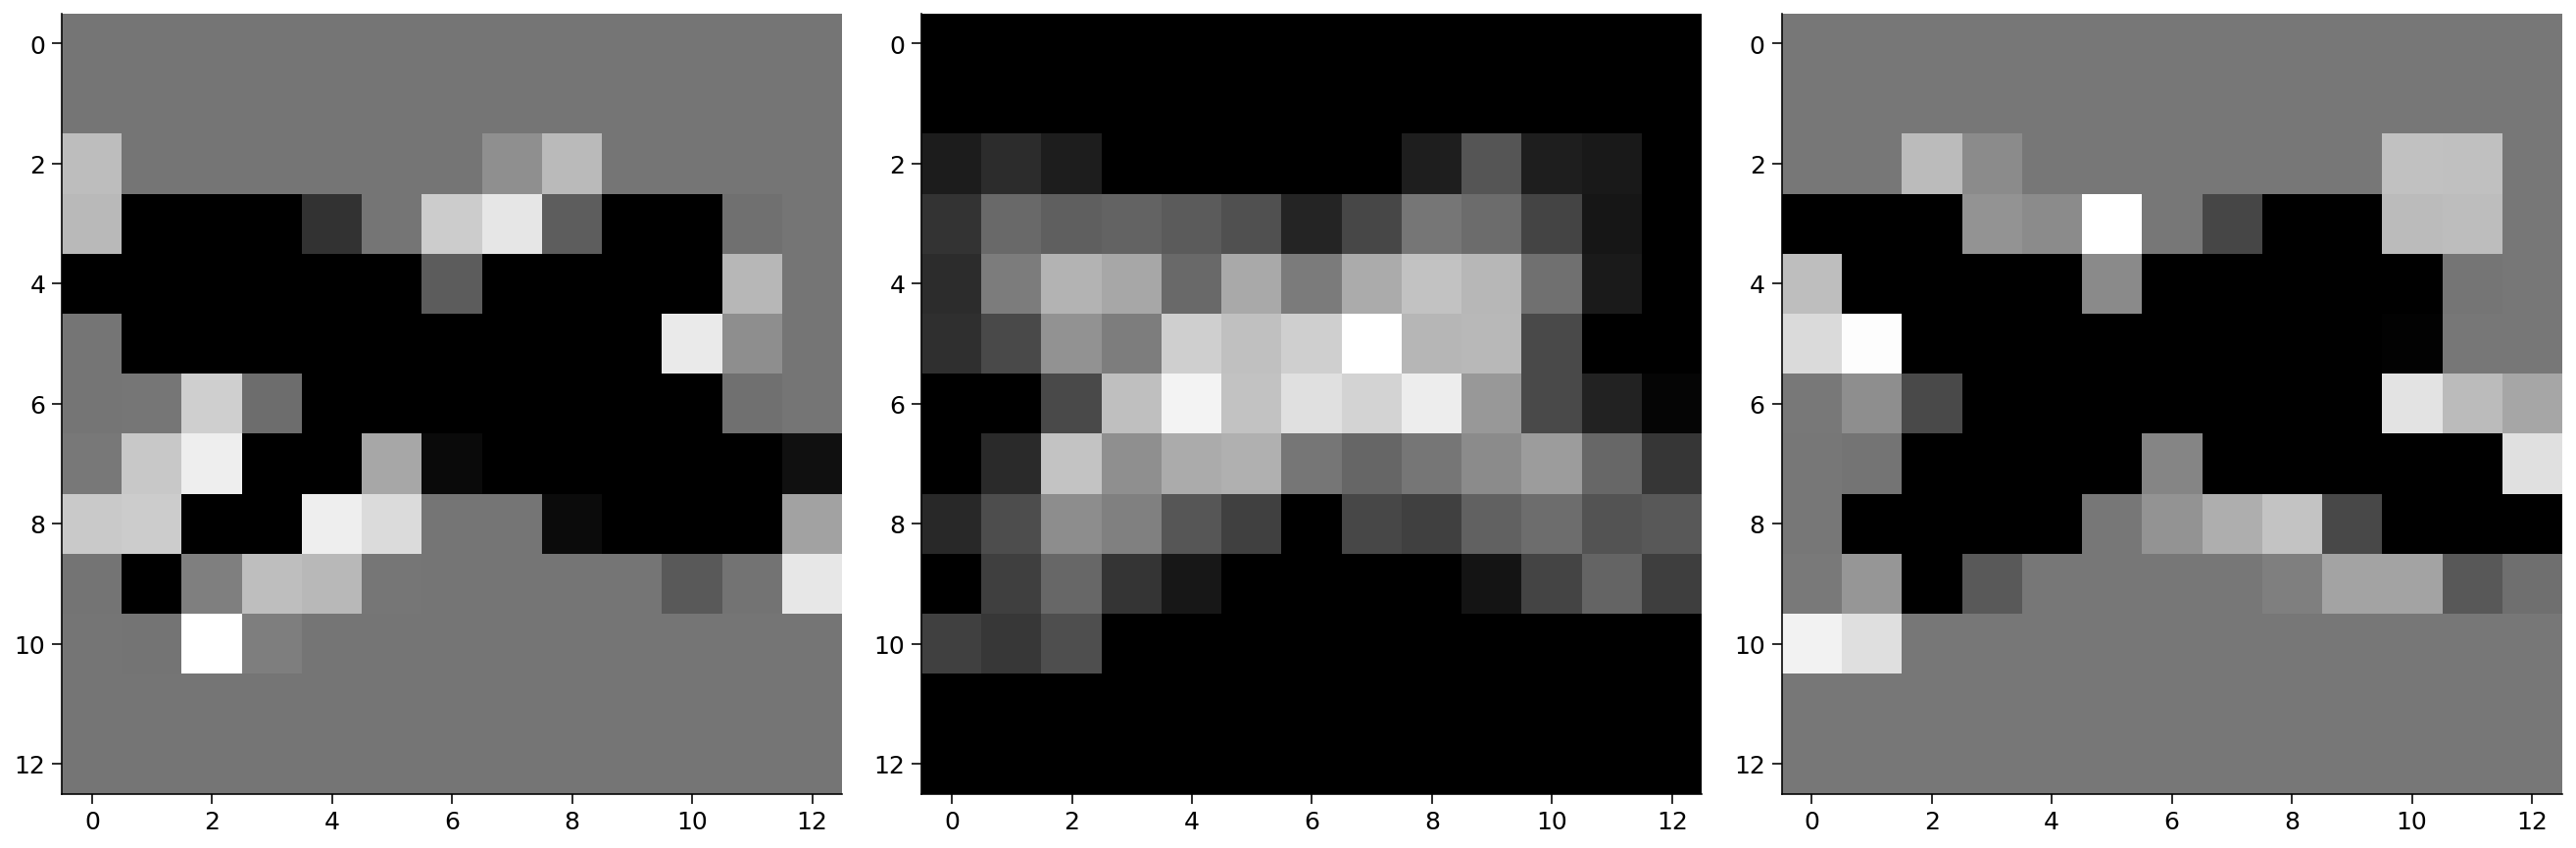

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

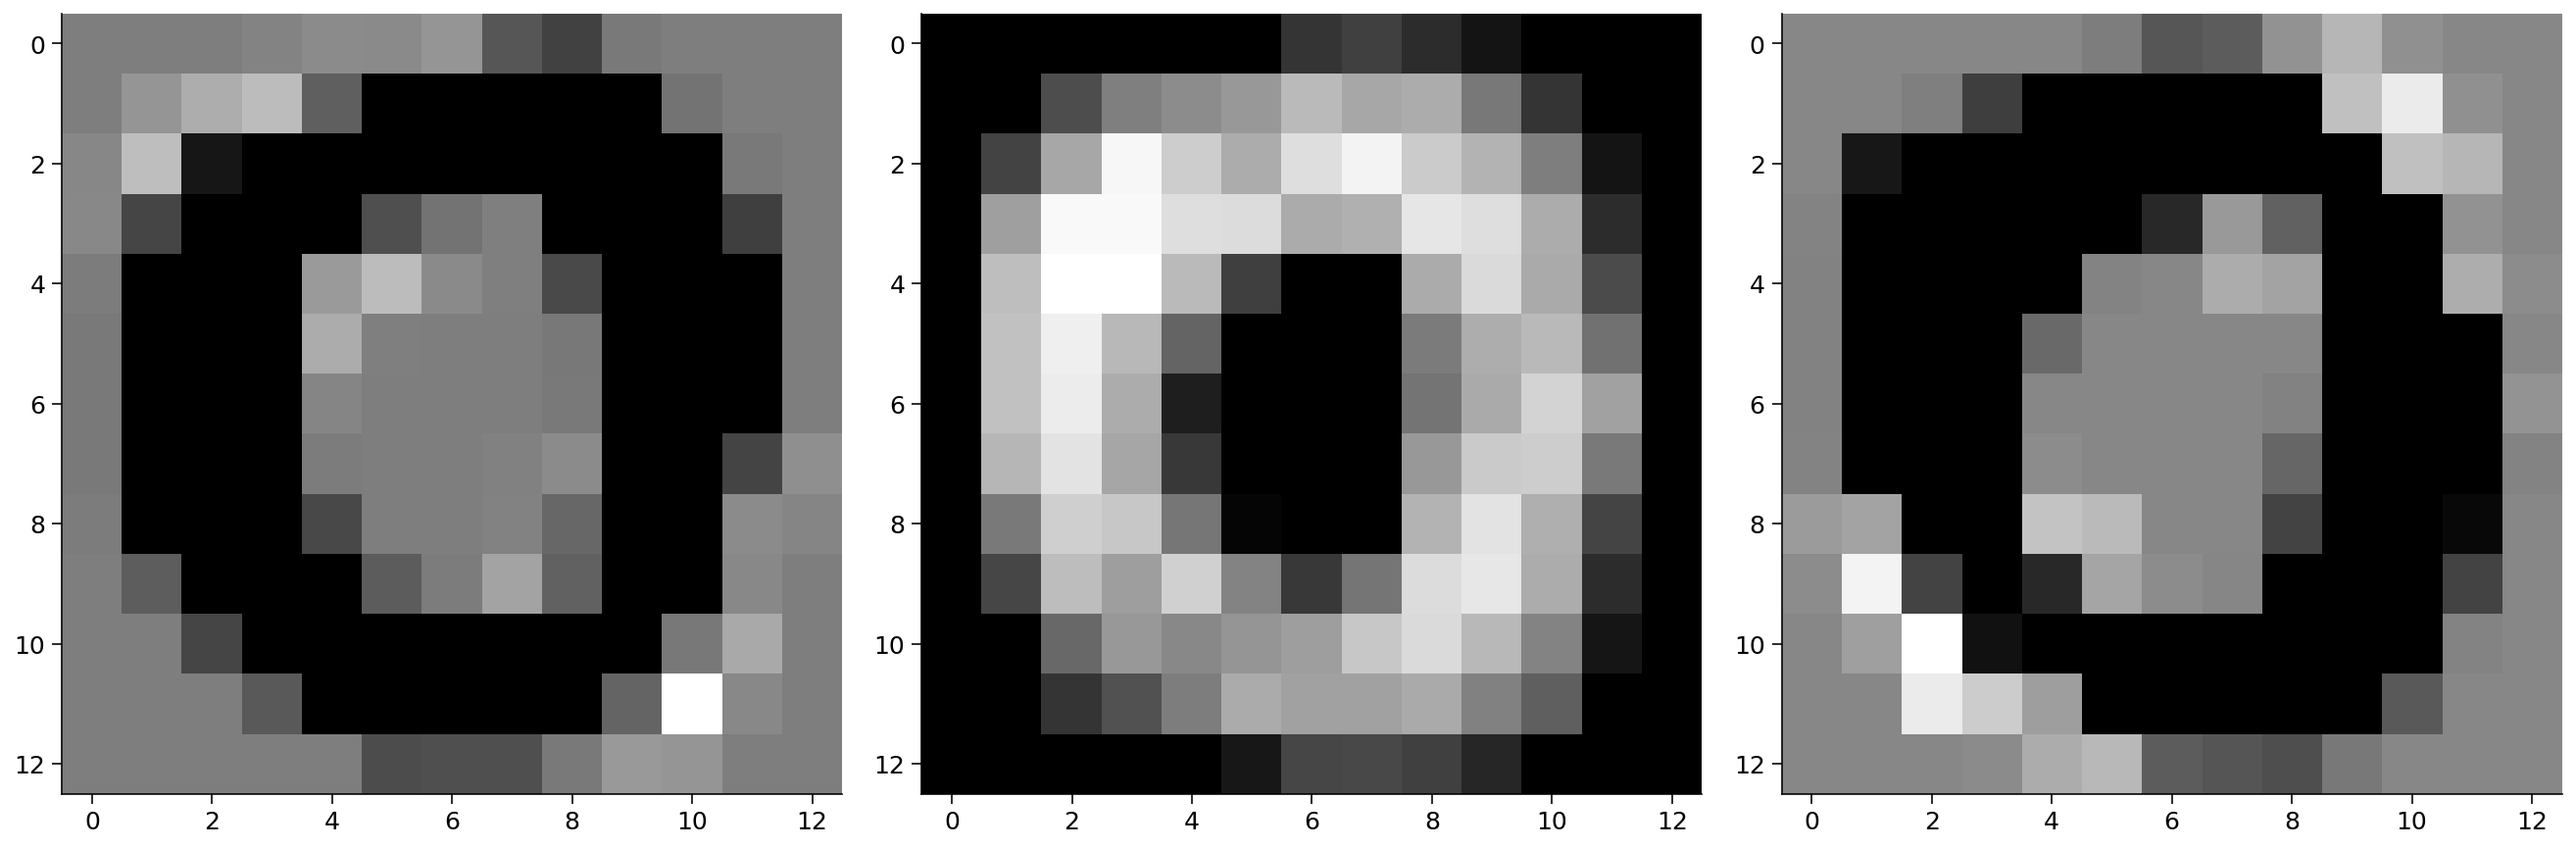

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

You should observe the size of the output as being half of what you saw after the ReLU section, which is due to the Maxpool layer. 

Despite the reduction in the size of the output, the important or high-level feature in the output still remains intact.

---
# Section 4: Putting it all together
*Estimated Completion Time: 125 minutes from start of the tutorial*



Video available at https://youtube.com/watch?v=MPa00KpNcEc


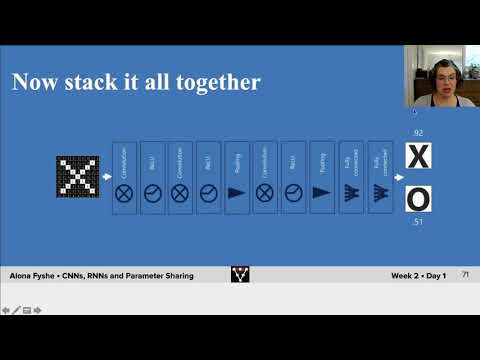

In [48]:
#@title Video 7: Reduction in Parameters to Learn Compared to Fully Connected Networks
import time
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="MPa00KpNcEc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Number of parameters in Convolutional vs Fully connected Models
Convolutional Networks encourage weight sharing by learning a single kernel that is repeated over the entire input image. In general, this kernel is just a few parameters compared to the huge number of parameters in a dense network. 

Let's use the animation below to calculate few-layer network parameters for image data of shape $32\times32$ using both Conv layers and dense layers. The Num_Dense in this exercise is the number of dense layers we use in the network, with each dense layer having the same input and output dimensions.  Num_Convs is the number of Convolutional blocks in the network, and each block containing a single kernel. The kernel size is the length and width of this kernel.

**Note:** you have to run the cell before you can use the sliders, and then run the cell again after you move the sliders to see the result.


<figure>
    <center><img src=https://raw.githubusercontent.com/fyshelab/course-content/main/tutorials/W06_ConvNets/static/img_params.png>
    <figcaption> Parameter comparison </figcaption>
    </center>    
</figure>

Time taken by Dense Layer 0.6538286209106445
Time taken by Conv Layer  0.363938570022583


<!DOCTYPE html>
 
 

 
 

 
 
 
 Code for Dense Network 
 input = torch.rand(100, 1, 96, 96)
model_dense = nn.Sequential(
 nn.Flatten(),
 nn.Linear(96*96*1, 96*96*1, bias=False),
 nn.Linear(96*96*1, 96*96*1, bias=False),
 nn.Linear(96*96*1, 10, bias=False)
)
result_dense = model_dense(sample_image)
 
 
 
 Code for Conv Network 
 input = torch.rand(100, 1, 96, 96)
model_conv = nn.Sequential(
 nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, padding=4, bias=False),
 nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, padding=4, bias=False),
 nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, padding=4, bias=False),
 nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, padding=4, bias=False),
 nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, padding=4, bias=False),
 nn.Flatten(),
 nn.Linear(9216, 10, bias=False),
)
result_conv = model_conv(sample_image)
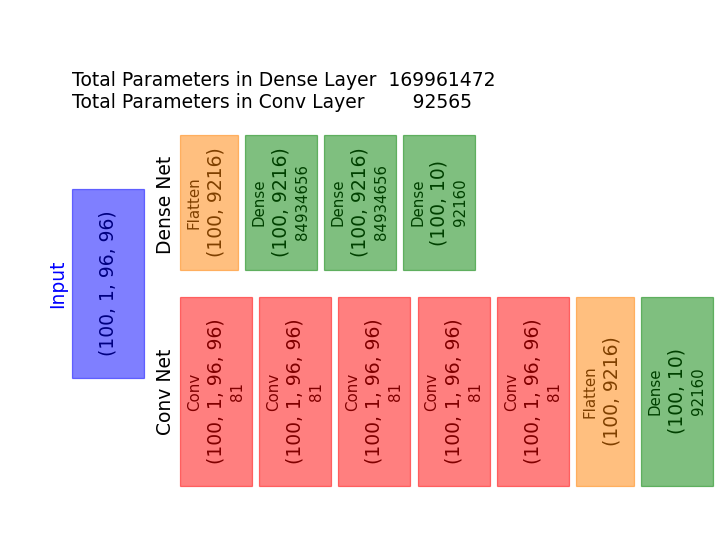

In [49]:
#@markdown ## Interactive Demo 4.1: Number of Parameters
import torch
import torch.nn as nn
import time

#@markdown **Input**: batch of 100 images of shape 'image_size'x'image_size'

image_size = 96 #@param {type:"slider", min:32, max:128, step:32}

#@markdown ## Dense Network Parameters

batch_size = 100 # @ param {type:"integer"}
sample_image = torch.rand(batch_size,1,image_size,image_size)
#print("Input Shape {}".format(sample_image.shape))

number_of_Linear = 2 #@param {type:"slider", min:1, max:3, step:1}

#@markdown ## Convolution Network Parameters

number_of_Conv2d = 5 #@param {type:"slider", min:1, max:5, step:1}

kernel_size = 9 #@param {type:"slider", min:3, max:21, step:2}

pooling = False #@param {type:"boolean"}

#@markdown ## Final Layer

Final_Layer = True #@param {type:"boolean"}

linear_layer = []
linear_nets = []
code_dense = ""
code_dense += f"input = torch.rand({batch_size}, 1, {image_size}, {image_size})\n"
code_dense += f"model_dense = nn.Sequential(\n"
code_dense += f"    nn.Flatten(),\n"
for i in range(number_of_Linear):
    linear_layer.append(nn.Linear(image_size*image_size*1,image_size*image_size*1,bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, {image_size}*{image_size}*1, bias=False),\n"
if Final_Layer is True:
    linear_layer.append(nn.Linear(image_size*image_size*1, 10, bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, 10, bias=False)\n"
code_dense += ")\n"
code_dense += "result_dense = model_dense(sample_image)\n"
linear_layer = nn.Sequential(*linear_layer)

conv_layer = []
conv_nets = []
code_conv = ""
code_conv += f"input = torch.rand({batch_size}, 1, {image_size}, {image_size})\n"
code_conv += f"model_conv = nn.Sequential(\n"
for i in range(number_of_Conv2d):
    conv_layer.append(nn.Conv2d(in_channels=1,out_channels=1,kernel_size=kernel_size,padding=kernel_size//2,bias=False))
    conv_nets.append(nn.Sequential(*conv_layer))
    code_conv += f"    nn.Conv2d(in_channels=1, out_channels=1, kernel_size={kernel_size}, padding={kernel_size//2}, bias=False),\n"
    if pooling > 0:
        conv_layer.append(nn.MaxPool2d(2, 2))
        code_conv += f"    nn.MaxPool2d(2, 2),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
if Final_Layer is True:
    conv_layer.append(nn.Flatten())
    code_conv += f"    nn.Flatten(),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
    shape_conv = conv_nets[-1](sample_image).shape
    conv_layer.append(nn.Linear(shape_conv[1], 10, bias=False))
    code_conv += f"    nn.Linear({shape_conv[1]}, 10, bias=False),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
conv_layer = nn.Sequential(*conv_layer)
code_conv += ")\n"
code_conv += "result_conv = model_conv(sample_image)\n"


t_1=time.time()
shape_linear = linear_layer(torch.flatten(sample_image,1)).shape
#print("\nOutput From Linear {}".format(shape_linear))
t_2=time.time()
shape_conv = conv_layer(sample_image).shape
#print("Output From Conv Layer {}".format(shape_conv))
t_3=time.time()
#print("")
print("Time taken by Dense Layer {}".format(t_2-t_1))
print("Time taken by Conv Layer  {}".format(t_3-t_2))

#print("")
#print("-------------------------------------------")
#print("Total Parameters in Linear Layer {:10d}".format(sum(p.numel() for p in linear_layer.parameters())))
#print("Total Parameters in Conv Layer   {:10d}".format(sum(p.numel() for p in conv_layer.parameters())))
#print("-------------------------------------------")

import matplotlib.pyplot as plt
ax = plt.axes((0, 0, 1, 1))
ax.spines["left"].set_visible(False)
plt.yticks([])
ax.spines["bottom"].set_visible(False)
plt.xticks([])
p1 = sum(p.numel() for p in linear_layer.parameters())
nl = '\n'
p2 = sum(p.numel() for p in conv_layer.parameters())
plt.text(0.1, 0.8, f"Total Parameters in Dense Layer {p1:10d}{nl}Total Parameters in Conv Layer   {p2:10d}")

plt.text(0.23,0.62, "Dense Net", rotation=90, color='k', ha="center", va="center")

def addBox(x, y, w, h, color, text1, text2, text3):
    ax.add_patch(plt.Rectangle((x,y),w,h,
                                    fill=True, color=color, alpha=0.5, zorder=1000, clip_on=False
                                    ))
    plt.text(x + 0.02, y+h/2, text1, rotation=90, va="center", ha="center", size=12)
    plt.text(x + 0.05, y+h/2, text2, rotation=90, va="center", ha="center")
    plt.text(x + 0.08, y+h/2, text3, rotation=90, va="center", ha="center", size=12)

x = 0.25
if 1:
    addBox(x,0.5, 0.08, 0.25, [1, 0.5, 0],
           "Flatten",
           tuple(torch.flatten(sample_image,1).shape),
           ""
           )
    x += 0.08+0.01

for i in range(number_of_Linear):
    addBox(x,0.5, 0.1, 0.25, "g",
           "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image,1)).shape),
           list(linear_layer.parameters())[i].numel()
           )
    x += 0.11
    
if Final_Layer is True:
    i = number_of_Linear
    addBox(x,0.5, 0.1, 0.25, "g",
           "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image,1)).shape),
           list(linear_layer.parameters())[i].numel()
           )

plt.text(0.23,0.1+0.35/2, "Conv Net", rotation=90, color='k', ha="center", va="center")
x = 0.25
for i in range(number_of_Conv2d):
    addBox(x,0.1, 0.1, 0.35, "r",
           "Conv",
           tuple(conv_nets[i*2](sample_image).shape),
           list(conv_nets[i*2].parameters())[-1].numel()
           )
    x += 0.11
    if pooling > 0:
        addBox(x,0.1, 0.08, 0.35, [0, 0.5, 1],
           "Pooling",
           tuple(conv_nets[i*2+1](sample_image).shape),
           ""
           )
        x += 0.08+0.01
    
if Final_Layer is True:
    i = number_of_Conv2d
    addBox(x,0.1, 0.08, 0.35, [1, 0.5, 0],
           "Flatten",
           tuple(conv_nets[i*2](sample_image).shape),
           ""
           )
    x += 0.08+0.01
    addBox(x,0.1, 0.1, 0.35, "g",
           "Dense",
           tuple(conv_nets[i*2+1](sample_image).shape),
           list(conv_nets[i*2+1].parameters())[-1].numel()
           )
    x += 0.11

plt.text(0.08,0.3+0.35/2, "Input", rotation=90, color='b', ha="center", va="center")
ax.add_patch(plt.Rectangle((0.1,0.3),0.1,0.35,
                                    fill=True, color='b', alpha=0.5, zorder=1000,
                                    clip_on=False))
plt.text(0.1+0.1/2,0.3+0.35/2, tuple(sample_image.shape), rotation=90, va="center", ha="center")    
#plt.xlim(0.8, 1)
#plt.ylim(0.05, 0.8)
import io, base64
plt.gcf().set_tight_layout(False)
my_stringIObytes = io.BytesIO()
plt.savefig(my_stringIObytes, format='png', dpi=90)
my_stringIObytes.seek(0)
my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
del linear_layer,conv_layer
plt.close()
from IPython.display import display_html
display_html("""
 <!DOCTYPE html>
<html>
<head>
<style>
* {
    box-sizing: border-box;
}

.column {
    float: left;
    width: 33.33%;
    padding: 5px;
}

/* Clearfix (clear floats) */
.row::after {
    content: "";
    clear: both;
    display: table;
}
</style>
</head>
<body>

    <img src="data:image/png;base64,"""+str(my_base64_jpgData)[2:-1]+"""" alt="Graph">
<div class="row">
    <div class="column" style="overflow-x: scroll;">
    <h2>Code for Dense Network</h2>
  <pre>"""+code_dense+"""</pre>
  </div>
    <div class="column" style="overflow-x: scroll;">
        <h2>Code for Conv Network</h2>
  <pre>"""+code_conv+"""</pre>
  </div>
</div>
</body>
</html>
""", raw=True)

The difference in parameters is huge and continues to increase as the input image size increases.  Larger images require that the linear layer use a matrix that can be directly multiplied with the input pixels.

<br>

While pooling does not reduce the number of parameters for a subsequent convolutional layer, it does decreases the image size. Therefore, later dense layers will need fewer parameters.

<br>

The CNN parameter size, however, is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images. <br>The reduced parameter set not only brings down memory usage by huge chunks but also allows the model to generalize better.


Video available at https://youtu.be/MNf2f4Xi_jM


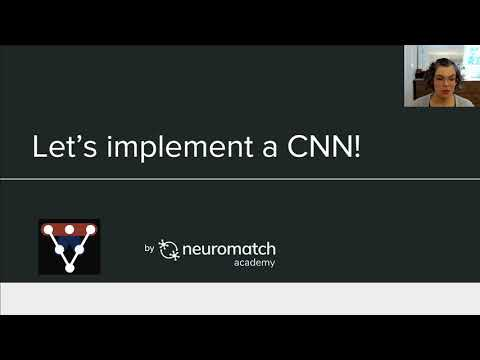

In [50]:
#@title Video 8: Implement your own CNN
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="MNf2f4Xi_jM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Coding Exercise 4.2: Implement your own CNN.

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: As discussed in the video, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape [BatchSize, Channels, Height, Width] to [BatchSize, Channels\\*Height\\*Width], which in this case would be from [32, 64, 12, 12] (output of second convolution layer) to [32, 64\*12\*12] = [32, 9216].
<br> Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The 1 means it flattens dimensions starting with dimensions 1, to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be 12x12. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to 26x26 and the second `Conv2d` reduces it to 24x24. Finally, the `MaxPool2d` operation reduces the output size by half to 12x12.

Also, don't forget the ReLUs (use e.g. `F.ReLU`)! No need to add a ReLU after the final fully connected layer.

*Estimated Completion Time: 140 minutes from start of the tutorial*



In [51]:
#@title Train/Test Functions (Run Me)

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from time import sleep

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the dataset 
def get_Xvs0_dataset():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    emnist_train = datasets.EMNIST(root='./data', split='letters', download=True, train=True, transform=transform)
    emnist_test = datasets.EMNIST(root='./data', split='letters', download=True, train=False, transform=transform)

    # only want O (15) and X (24) labels 
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]  

    # convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test

def get_data_loaders(train_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    
    return train_loader, test_loader

emnist_train, emnist_test = get_Xvs0_dataset()
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test)

# index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0


def train(model, device, train_loader, epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01)
    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                sleep(0.1)

def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [52]:
class EMNIST_Net(nn.Module):
  def __init__(self):
    super(EMNIST_Net, self).__init__()

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the required layers")
    ####################################################################
    self.conv1 = nn.Conv2d(...)
    self.conv2 = nn.Conv2d(...)
    self.fc1 = nn.Linear(...)
    self.fc2 = nn.Linear(...)
    self.pool = nn.MaxPool2d(...)

  def forward(self, x):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: Do not forget to flatten the image as it goes from Convolution Layers to Linear Layers!
    raise NotImplementedError("Define forward pass for any input x")
    ####################################################################
    # use e.g. 
    # x = self.conv1(x) for a convulution
    # x = F.relu(x) for a relu activation
    # x = torch.flatten(x, 1) to flatten the current tensor
    x = ...
    return x


### Uncomment the lines below to train your network   
# emnist_net = EMNIST_Net().to(device)
# train(emnist_net, device, train_loader, 1)

In [53]:
# to_remove solution
class EMNIST_Net(nn.Module):
  def __init__(self):
    super(EMNIST_Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 2)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)        
    x = self.fc2(x)
    return x


emnist_net = EMNIST_Net().to(device)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, device, train_loader, 1)

Total Parameters in Network    1198850


Now, let's run the network on the test data!

In [54]:
test(emnist_net, device, test_loader)

99.25

You should have been able to get a test accuracy of around $99%$!

NOTE: We are using a softmax function here which converts a real value to a value between 0 and 1, which can be interpreted as a probability.

Input:


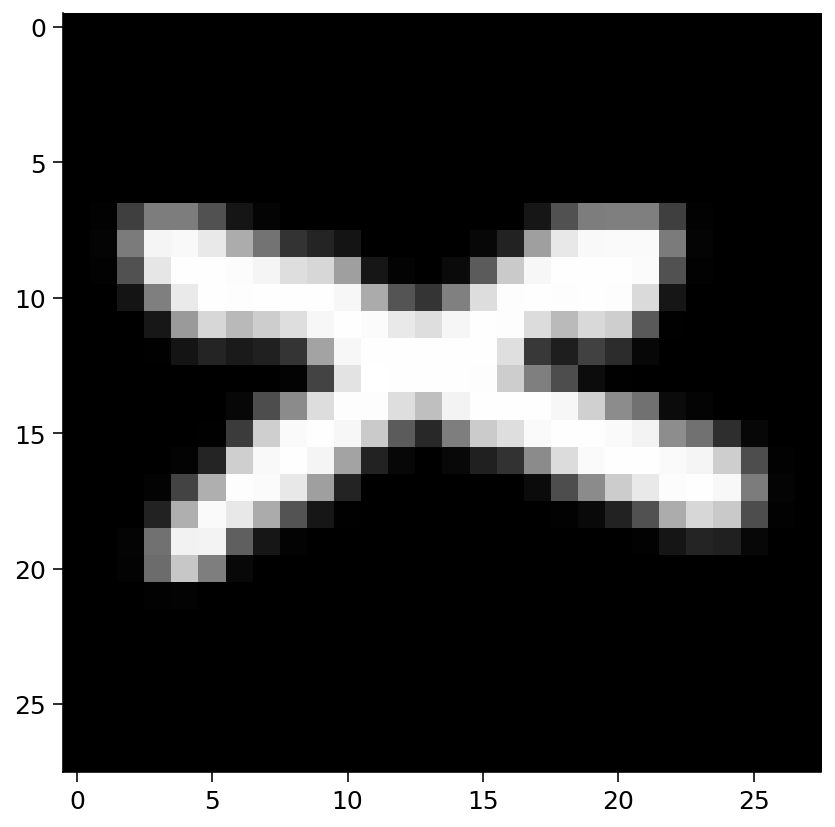


Result: tensor([[0.0013, 0.9987]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Confidence of image being an 'O': 0.0013389576924964786
Confidence of image being an 'X': 0.9986610412597656


In [55]:
print("Input:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

The network is quite confident that this image is an $X$ ! <br>Note that this is evident from the Softmax Output, which shows the probabilities of the image belonging to each of the classes. A higher probability of belonging to class 1 i.e., class $X$. <br><br>Let us also test the network against an $O$ image. 

Input:


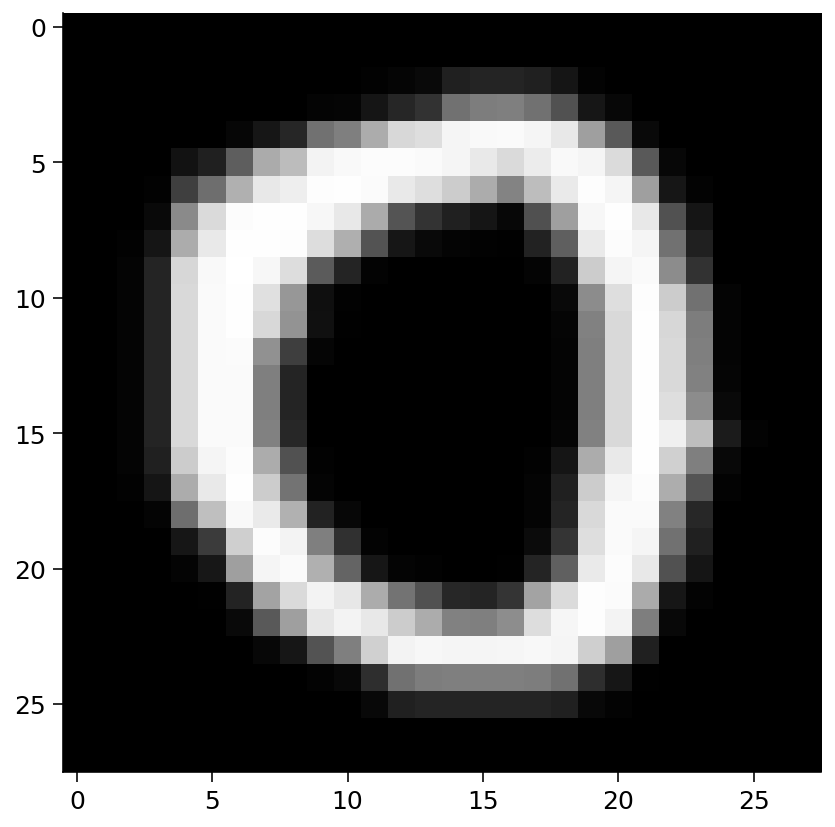


Result: tensor([[9.9966e-01, 3.3836e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Confidence of image being an 'O': 0.9996616840362549
Confidence of image being an 'X': 0.0003383588627912104


In [56]:
print("Input:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

---
#Section 5: Training a CNN

In the last section we coded up a CNN, but trained it with some predefined functions.  In this section, we will walk through an example of training loop for a convolution net. In this section, we will train a CNN using convolution layers and maxpool and then observe what the training and validation curves look like. In Section 6, we will add regularization and data augmentation to see what effects they have on the curves and why it is important to incorporate them while training our network.
<br>
*Estimated Completion Time: 85 mins from start of the session*

Video available at https://youtu.be/ePEx1qpNOsw


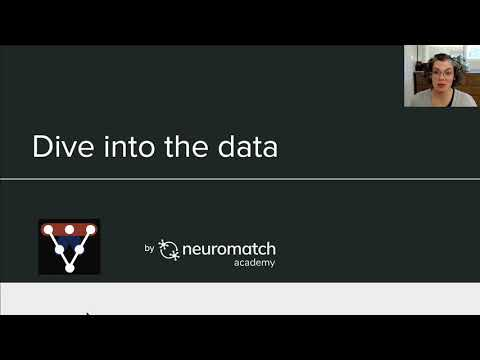

In [57]:
#@title Video 9: Dive into the Data
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ePEx1qpNOsw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Understand the Dataset

The dataset we are going to use for this task is called Fashion-MNIST. It consists of a training set of 60,000 examples and a test set of 10,000 examples. We further divide the test set into a validation set and a test set (8000 and 2000 resp). Each example is a 28*28 gray scale image, associated with a label from 10 classes. Following are the labels of the dataset:

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover <br>
3 Dress <br>
4 Coat <br> 
5 Sandal <br>
6 Shirt <br> 
7 Sneaker <br> 
8 Bag <br> 
9 Ankle boot <br> 

**NOTE:** we will reduce the dataset to just the two categories T-shirt/top and Shirt to reduce the training time from about 10min to 2min. We later provide pretrained results to give you an idea how the results would look on the whole dataset.

In [58]:
# @title Utils

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from time import sleep
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
# @title Getting Fashion-Mnist Data

def get_fashion_mnist_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)

    test_data = datasets.FashionMNIST(root='./data',  download=True, train=False, transform=transform)

    validation_data, test_data = torch.utils.data.random_split(test_data, [int(0.8*len(test_data)), int(0.2*len(test_data))])

    return train_data, validation_data, test_data

num_classes = 10
train_data, validation_data, test_data = get_fashion_mnist_dataset()


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [60]:
# @title Reducing Fashion-Mnist Data (to two categories)
# @markdown NOTE: if you want to train on the whole dataset, just run the cell above
# @markdown and do not execute this cell.
# need to split into train, validation, test 
def reduce_classes(data):
    # only want T-Shirts (0) and Shirts (6) labels 
    train_idx = (data.targets == 0) | (data.targets == 6)
    data.targets = data.targets[train_idx]
    data.data = data.data[train_idx]  

    # convert Xs predictions to 1, Os predictions to 0
    data.targets[data.targets == 6] = 1

    return data

def get_fashion_mnist_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
    train_data = reduce_classes(train_data)

    test_data = datasets.FashionMNIST(root='./data',  download=True, train=False, transform=transform)
    test_data = reduce_classes(test_data)

    validation_data, test_data = torch.utils.data.random_split(test_data, [int(0.8*len(test_data)), int(0.2*len(test_data))])

    return train_data, validation_data, test_data

num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset()

Here's some code to visualize the dataset.

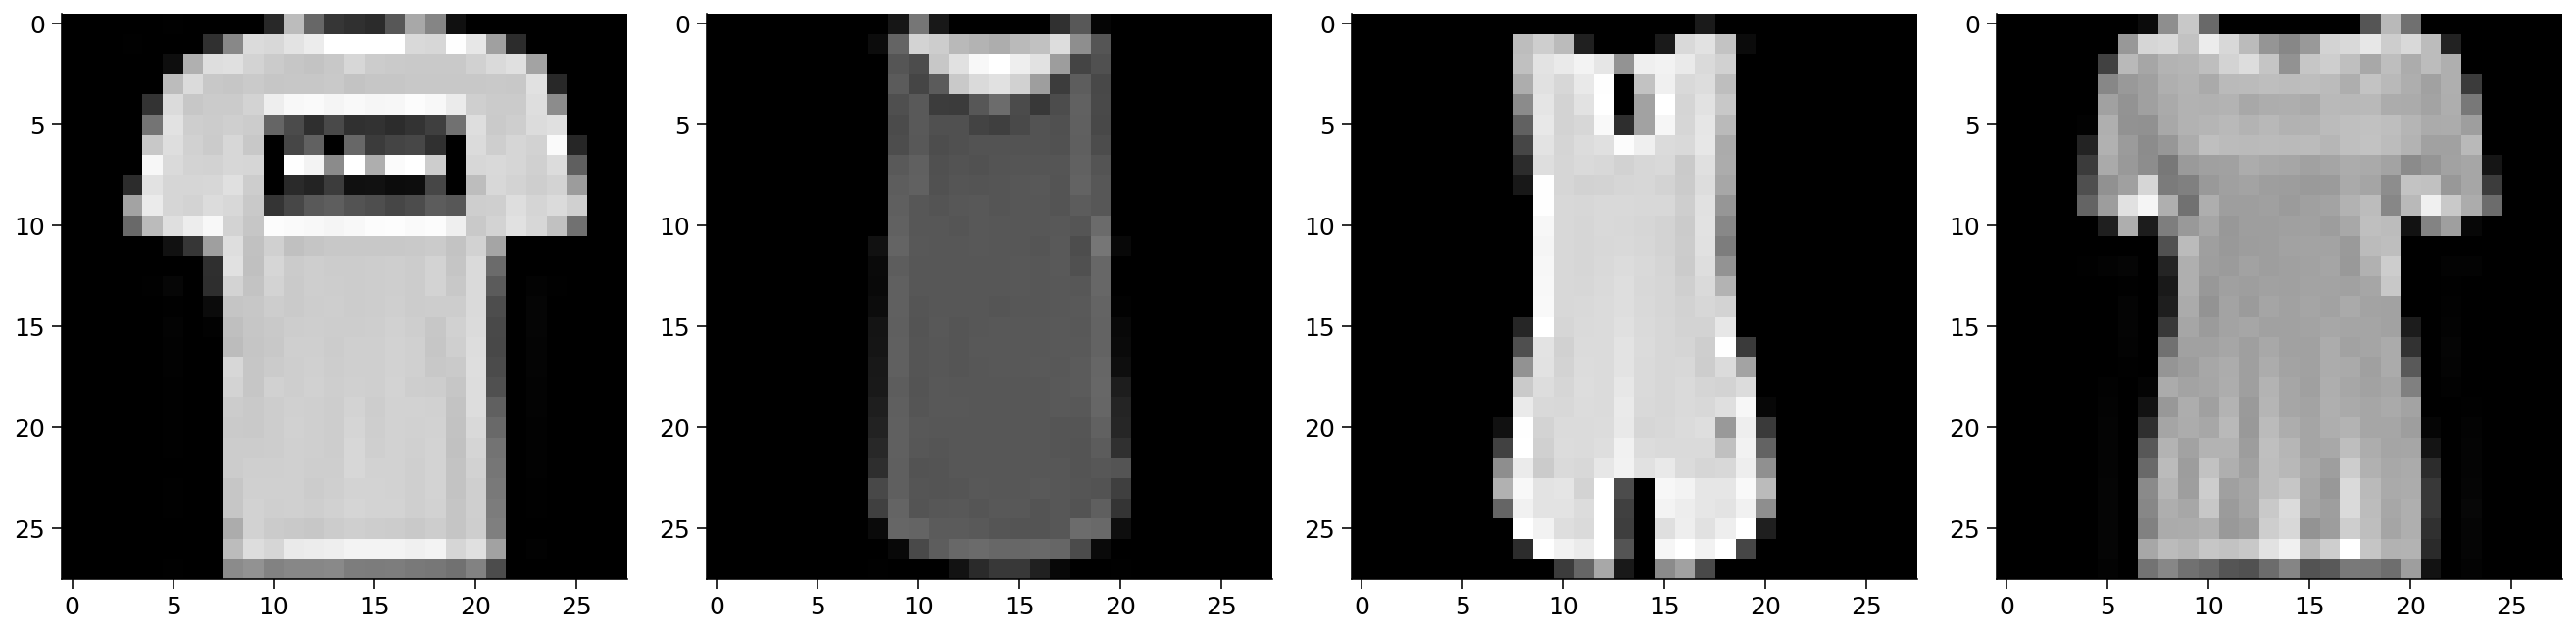

In [61]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Take a minute with your pod and talk about which classes you think would be most confusable.  How hard will it be to differentiate t-shirt/tops from shirts?

Video available at https://youtube.com/watch?v=C3HNBcYa8yo


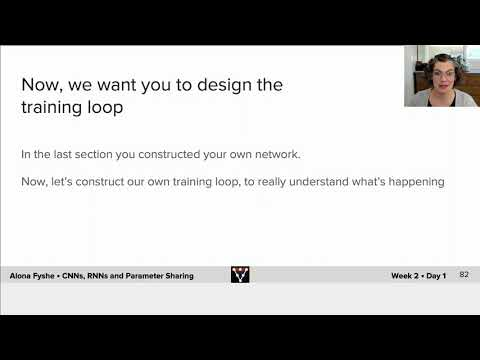

In [62]:
#@title Video 10: Training Loop
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="C3HNBcYa8yo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Reminder: Backpropagation

_Feel free to skip if you've got a good handle on Backpropagation_

We know that we multiply the input data/tensors with weight matrices to obtain some output. Initially, we don't know what the actual weight matrices is so we initialize them with some random values. These random weight matrices when applied as a transformation on the input gives us some output. At first the outputs/predictions will match the true labels only by chance. 

To improve performance, we need to change the weight matrices so that the predicted outputs are similar to the true outputs (labels). We first calculate how far away the predicted outputs are to the true outputs using a loss function. Based on the loss function, we change the values of our weight matrices using the gradients of the error with respect to the weight matrices. 

Since we are using PyTorch throughout the course, we will use the built-in functions to update the weights. We call the `backward()` method on our 'loss' variable to calculate the gradients/derivatives with respect to all the weight matrices and biases. And then we call the `step()` method on the optimizer variable to apply the gradient updates to our weight matrices.






Here's an animation of backpropagation works.


<figure>
    <center><img src=https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif>
    <figcaption> Stride Two </figcaption>
    </center>    
</figure>

[This](https://machinelearningknowledge.ai/animated-explanation-of-feed-forward-neural-network-architecture/) article has more animations.



_____
## Coding Exercise 5.1: Code the training loop

Let's first see a sample training loop. First, we create the network and load a dataset. Then we look at the training loop.

In [63]:
#@title Create a sample network
import torch.nn as nn
import torch
import torch.nn.functional as F

class emnist_net(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 256) 
        self.fc2 = nn.Linear(256, 26)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        
        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # Fully connected layer 1.
        x = x.view(-1, 7*7*64)  # You have to first flatten the ourput from the previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)       
        
        # Fully connected layer 2.
        x = self.fc2(x)
        # x = F.softmax(x)
        
        return x



In [64]:
#@title Load a sample dataset
# Load the data
from torchvision import datasets, transforms
mnist_train = datasets.EMNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True, split='letters')
mnist_test = datasets.EMNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True, split='letters')

# labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# create data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)


Extracting ./datasets/EMNIST/raw/gzip.zip to ./datasets/EMNIST/raw


In [65]:
## Training
# Instantiate model 
model = emnist_net().to(device)  # Puts the Model on the GPU (Select runtime-type as GPU from the 'Runtime->Change Runtime type' option).

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

# Iterate through train set minibatchs 
for epoch in trange(3):  # <---- change here
    for images, labels in tqdm(train_loader):
        
        # Zero out the gradients
        optimizer.zero_grad() # Fill this out.

        # Forward pass
        x = images
        x, labs = x.to(device), labels.to(device) # Move the data to GPU for faster execution.
        y = model(x)
        
        # Calculate loss.
        loss = criterion(y, labs) 

        # Backpropagation and gradient update.
        loss.backward() # Calculate gradients.
        optimizer.step() # Apply gradient udpate.


## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images  
         # Move the data to GPU for faster execution.
        x, labs = x.to(device), labels.to(device)
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labs).float())

print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9304326772689819


You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN. 
- Choose the correct criterion 
- Code up the training part (calculating gradients, loss, stepping forward)
- Keep a track of the running loss i.e for each epoch we want to to know the average loss of the batch size. We have already done the same for accuracy for you. 



In [66]:
# @title Running model on Test Data Helper Function (run me)

# just returns accuracy on test data
def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [67]:
# @title Plotting Helper Function (run me)

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

# Now Let us train on the actual Fashion-MNIST dataset.

In [68]:
# @title Getting the DataLoaders (Run Me)
def get_data_loaders(train_dataset, validation_dataset, test_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    
    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = get_data_loaders(train_data, validation_data, test_data)

In [69]:
# This cell contains the code for the CNN we will be using in this section.
class FMNIST_Net1(nn.Module):
    def __init__(self):
        super(FMNIST_Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return x

Now try coding the training loop.

You should first have a `criterion` defined (you can use `CrossEntropyLoss` here, which you learned about last week) so that you can calculate the loss. Next, you should to to put everything together. Start the training process by first obtaining the model output, calculating the loss, and finally updating the weights.

*Don't forget to zero out the gradients.*

In [70]:
def train(model, device, train_loader, validation_loader, epochs):
    
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the loss function")
    ####################################################################
    criterion = ...
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keeps track of the running loss
            running_loss = 0.

            correct, total = 0, 0 
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # COMPLETE CODE FOR TRAINING LOOP by following these steps
                # 1. Get the model output (call the model with the data from this batch)
                # 2. Zero the gradients out (i.e. reset the gradient that the optimizer has collected so far with optimizer.zero_grad())
                # 3. Get the Loss (call the loss criterion with the model's output and the target values)
                # 4. Calculate the gradients (do the pass backwards from the loss with loss.backward())
                # 5. Update the weights (using the training step of the optimizer, optimizer.step())
                
                ####################################################################
                # Fill in missing code below (...),
                # then remove or comment the line below to test your function
                raise NotImplementedError("Update the set_postfix function")
                ####################################################################

                
                # set loss to whatever you end up naming your variable when 
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepoch.set_postfix(loss=...)
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            
            ####################################################################
            # Fill in missing code below (...),
            # then remove or comment the line below to test your function
            raise NotImplementedError("Append the train_loss")
            ####################################################################
            train_loss.append(...)  # append the loss for this epoch
            train_acc.append(correct/total)
                    
            # evaluate on validation data
            
            model.eval()
            running_loss = 0.
            correct, total = 0, 0 
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 

In [71]:
# to_remove solution
def train(model, device, train_loader, validation_loader, epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0 
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # COMPLETE CODE FOR TRAINING LOOP
                # 1. Get the model output (call the model with the data from this batch)
                output = model(data)
                # 2. Zero the gradients out (i.e. reset the gradient that the optimizer has collected so far with optimizer.zero_grad())
                optimizer.zero_grad()
                # 3. Get the Loss (call the loss criterion with the model's output and the target values)
                loss = criterion(output, target)
                # 4. Calculate the gradients (do the pass backwards from the loss with loss.backward())
                loss.backward()
                # 5. Update the weights (using the training step of the optimizer, optimizer.step())
                optimizer.step()

                # set loss to whatever you end up naming your variable when 
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            
            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)
                    
            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0 
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 

The next cell contains the code for the CNN we will be using in this section.

In [72]:
net = FMNIST_Net1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, validation_loader, 20)

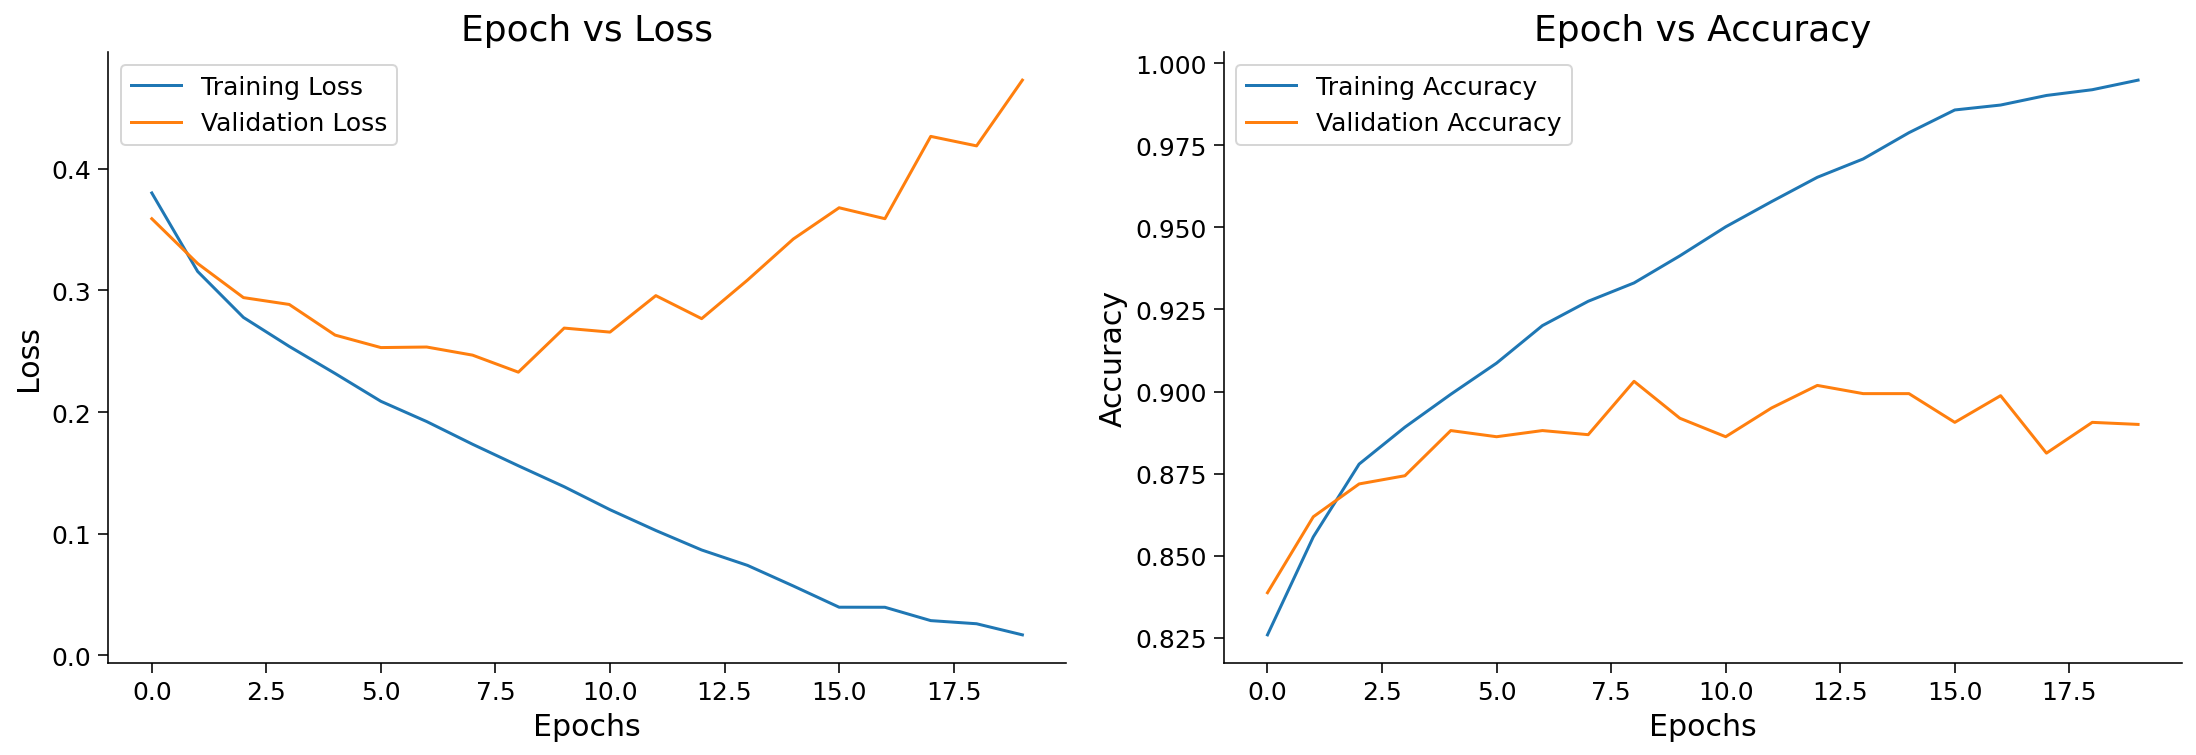

In [73]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W06_ConvNets/solutions/W6_Tutorial2_Solution_Ex21.py)

*Example output:*  

<img alt='Solution hint 2.1' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W06_ConvNets/static/W6_Tutorial2_Solution_Ex21.png />



Run the next cell to get the accuracy on the data!

In [74]:
test(net, device, test_loader)

92.5

In [75]:
#@markdown Q. Do you think this network is overfitting? What can you do to combat this?
overfitting = '' #@param {type:"string"}

__________
# Section 6: Overfitting - symptoms and cures

 

Video available at https://youtube.com/watch?v=_YtOH3_wecg


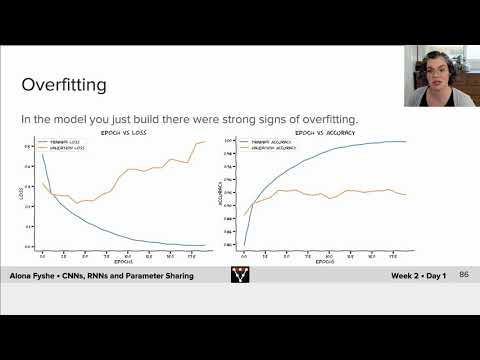

In [76]:
#@title Video 11: Dropout
try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="_YtOH3_wecg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

So you spent some time last week learning about regularization techniques. Below is a copy of the CNN model we used previously.  Now we want you to add some dropout regularization, and check if that helps reduce overfitting. If you're up for a challenge, you can try methods other than dropout as well.

## Coding Exercise 6.1: Adding Regularization

In [77]:
# add various regularization methods, feel free to add any and play around! 
class FMNIST_Net2(nn.Module):
    def __init__(self):
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Add regularization layers")
        ####################################################################
        self.dropout1 = ...
        self.dropout2 = ...
        self.batch_norm1 = ...
        self.batch_norm2 = ...

    def forward(self, x):
        ####################################################################
        # Now add the layers in your forward pass in appropriate order
        # then remove or comment the line below to test your function
        raise NotImplementedError("Add regularization in the forward pass")
        ####################################################################
        x = self.conv1(x)
        x = ...
       
        return x

In [78]:
# to_remove solution
class FMNIST_Net2(nn.Module):
    def __init__(self):
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [79]:
net2 = FMNIST_Net2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net2, device, train_loader, validation_loader, 20)

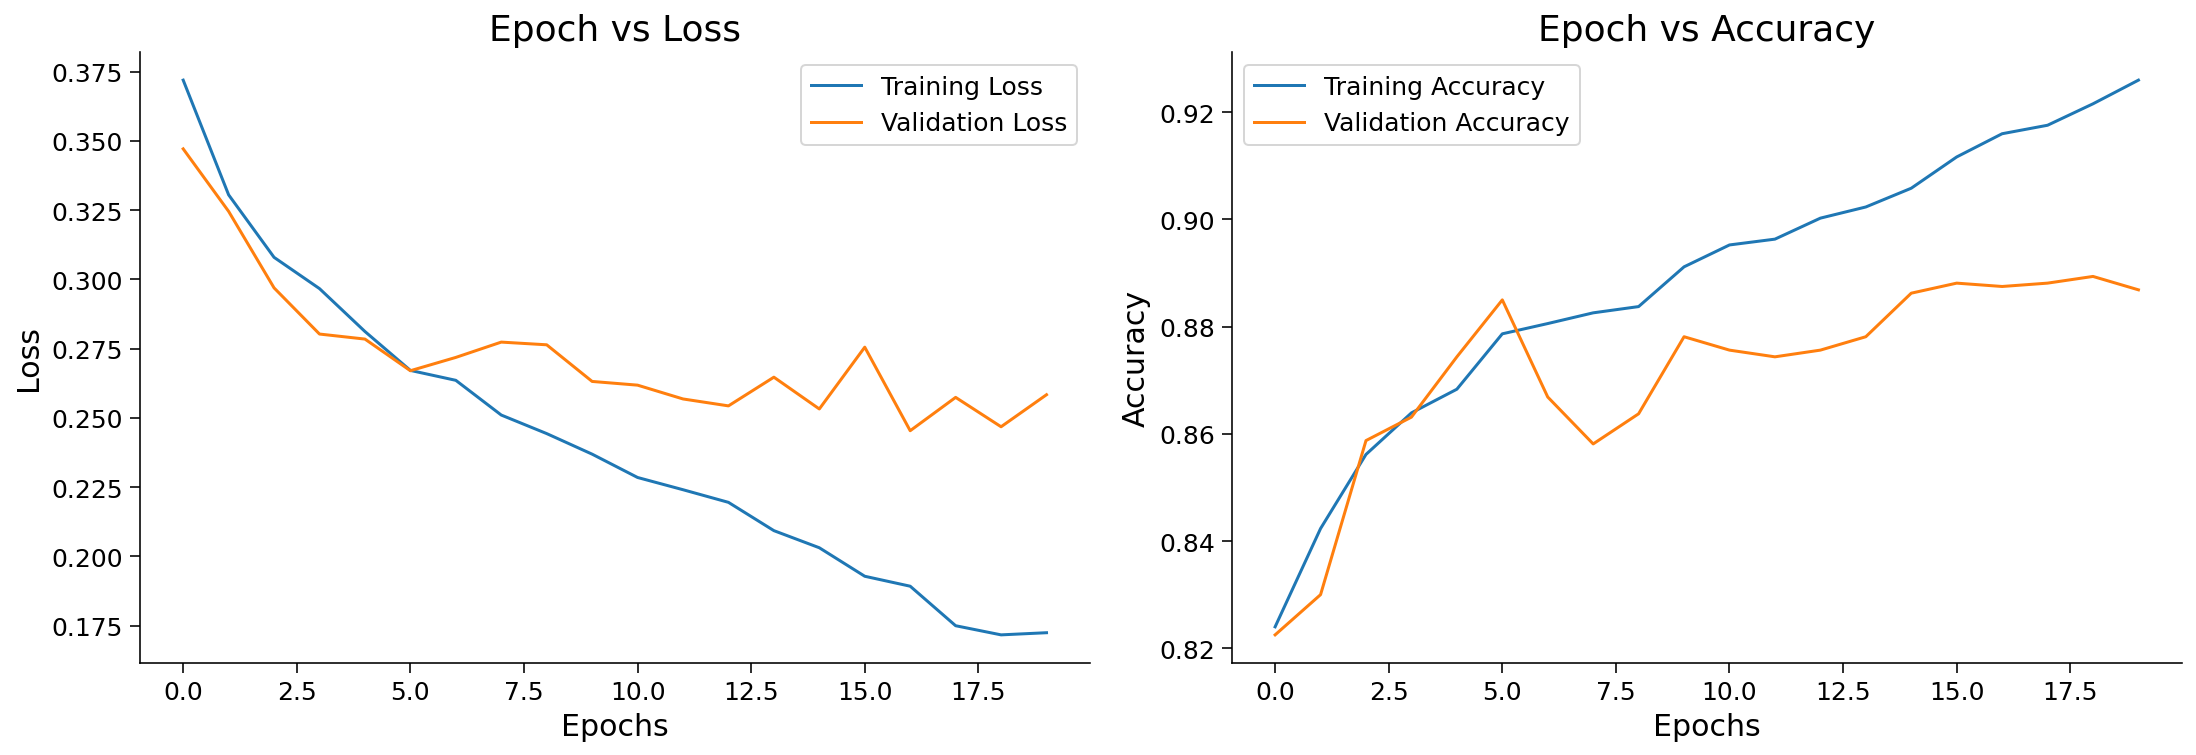

In [80]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W06_ConvNets/solutions/W6_Tutorial2_Solution_Ex22.py)

*Example output:*  

<img alt='Solution hint 2.2' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W06_ConvNets/static/W6_Tutorial2_Solution_Ex22.png />


In [81]:
test(net2, device, test_loader)

89.75

In [82]:
#@markdown Is the training accuracy slightly reduced from before adding regularization? What accuracy were you able to reduce it to?
regularize_1 = '' #@param {type:"string"}

In [83]:
#@markdown Why does the validation accuracy start higher than training accuracy?
regularize_2 = '' #@param {type:"string"}

0.25 0.75


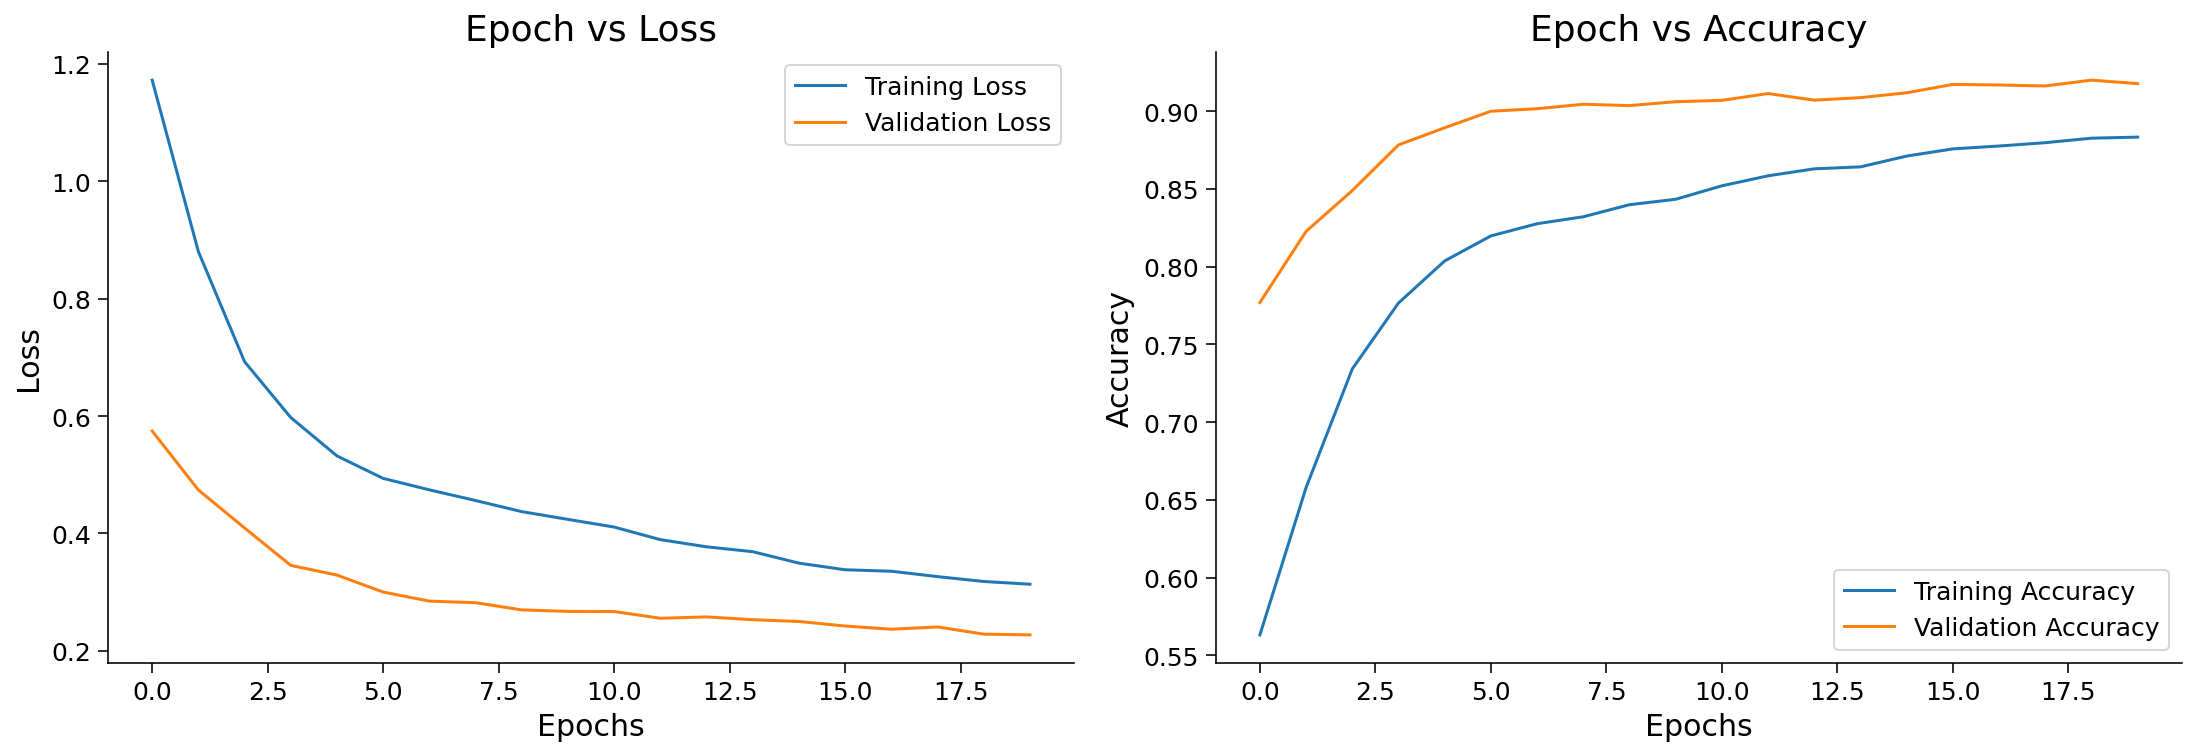

In [84]:
#@markdown If you want to try out more dropout parameter combinations, but do not 
#@markdown have the time to run them, we have here precalculated some combinations
#@markdown you can use the sliders to explore them.
data = [[0, 0, [0.3495898238046372, 0.2901147632522786, 0.2504794800931469, 0.23571575765914105, 0.21297093365896255, 0.19087818914905508, 0.186408187797729, 0.19487689035211472, 0.16774938120803934, 0.1548648244958926, 0.1390149021382503, 0.10919439224922593, 0.10054351237820501, 0.09900783193594914, 0.08370604479507088, 0.07831853718318521, 0.06859792241866285, 0.06152600247383197, 0.046342475851873885, 0.055123823092992796], [0.83475, 0.8659166666666667, 0.8874166666666666, 0.8913333333333333, 0.8998333333333334, 0.9140833333333334, 0.9178333333333333, 0.9138333333333334, 0.9251666666666667, 0.92975, 0.939, 0.9525833333333333, 0.9548333333333333, 0.9585833333333333, 0.9655833333333333, 0.9661666666666666, 0.9704166666666667, 0.9743333333333334, 0.9808333333333333, 0.9775], [0.334623601436615, 0.2977438402175903, 0.2655304968357086, 0.25506321132183074, 0.2588835284113884, 0.2336345863342285, 0.3029863876104355, 0.240766831189394, 0.2719801160693169, 0.25231350839138034, 0.2500132185220718, 0.26699506521224975, 0.2934862145781517, 0.361227530837059, 0.33196919202804565, 0.36985905408859254, 0.4042587959766388, 0.3716402840614319, 0.3707024946808815, 0.4652537405490875], [0.866875, 0.851875, 0.8775, 0.889375, 0.881875, 0.900625, 0.85, 0.898125, 0.885625, 0.876875, 0.899375, 0.90625, 0.89875, 0.87, 0.898125, 0.884375, 0.874375, 0.89375, 0.903125, 0.890625]], [0, 0.25, [0.35404509995528993, 0.30616586227366266, 0.2872369573946963, 0.27564131199045383, 0.25969504263806853, 0.24728168408445855, 0.23505379509260046, 0.21552803914280647, 0.209761732277718, 0.19977611067526518, 0.19632092922767427, 0.18672360206379535, 0.16564940239124476, 0.1654047035671612, 0.1684555298985636, 0.1627526102349796, 0.13878319327263755, 0.12881529055773577, 0.12628930977525862, 0.11346105090837846], [0.8324166666666667, 0.8604166666666667, 0.8680833333333333, 0.8728333333333333, 0.8829166666666667, 0.88625, 0.89425, 0.90125, 0.9015833333333333, 0.90925, 0.9114166666666667, 0.917, 0.9268333333333333, 0.92475, 0.921, 0.9255833333333333, 0.9385, 0.9428333333333333, 0.9424166666666667, 0.9484166666666667], [0.3533937376737595, 0.29569859683513644, 0.27531551957130435, 0.2576177391409874, 0.26947550356388095, 0.25361743807792664, 0.2527468180656433, 0.24179009914398195, 0.28664454460144045, 0.23347773611545564, 0.24672816634178163, 0.27822364538908007, 0.2380720081925392, 0.24426509588956832, 0.2443918392062187, 0.24207917481660843, 0.2519641682505608, 0.3075403380393982, 0.2798181238770485, 0.26709021866321564], [0.826875, 0.87, 0.870625, 0.8875, 0.883125, 0.88625, 0.891875, 0.891875, 0.890625, 0.903125, 0.89375, 0.885625, 0.903125, 0.888125, 0.899375, 0.898125, 0.905, 0.905625, 0.898125, 0.901875]], [0, 0.5, [0.39775496332886373, 0.33771887778284704, 0.321900939132939, 0.3079229625774191, 0.304149763301966, 0.28249239723416086, 0.2861261191044716, 0.27356165798103554, 0.2654648520686525, 0.2697350280557541, 0.25354846321204877, 0.24612889034633942, 0.23482802549892284, 0.2389904112416379, 0.23742155821875055, 0.232423192127905, 0.22337309338469455, 0.2141852991932884, 0.20677659985549907, 0.19355326712607068], [0.8155, 0.83625, 0.8481666666666666, 0.8530833333333333, 0.8571666666666666, 0.86775, 0.8623333333333333, 0.8711666666666666, 0.8748333333333334, 0.8685833333333334, 0.8785, 0.8804166666666666, 0.8835833333333334, 0.8840833333333333, 0.88875, 0.8919166666666667, 0.8946666666666667, 0.8960833333333333, 0.906, 0.9063333333333333], [0.3430288594961166, 0.4062050700187683, 0.29745822548866274, 0.27728439271450045, 0.28092808067798614, 0.2577864158153534, 0.2651400637626648, 0.25632822573184966, 0.3082498562335968, 0.2812121778726578, 0.26345942318439486, 0.2577408078312874, 0.25757989794015884, 0.26434457510709763, 0.24917411386966706, 0.27261342853307724, 0.2445397639274597, 0.26001051396131514, 0.24147838801145555, 0.2471102523803711], [0.82875, 0.795625, 0.87, 0.87375, 0.865625, 0.8825, 0.8825, 0.87625, 0.848125, 0.87875, 0.8675, 0.889375, 0.8925, 0.866875, 0.87375, 0.87125, 0.895625, 0.90375, 0.90125, 0.88625]], [0, 0.75, [0.4454924576777093, 0.43416607585993217, 0.42200265769311723, 0.40520024616667566, 0.41137005166804536, 0.404100904280835, 0.40118067664034823, 0.40139733080534223, 0.3797615355158106, 0.3596332479030528, 0.3600061919460905, 0.3554147962242999, 0.34480382890460337, 0.3329520877054397, 0.33164913056695716, 0.31860941466181836, 0.30702565340919696, 0.30605297186907304, 0.2953788426486736, 0.2877389984403519], [0.7788333333333334, 0.7825, 0.7854166666666667, 0.7916666666666666, 0.7885, 0.7833333333333333, 0.7923333333333333, 0.79525, 0.805, 0.81475, 0.8161666666666667, 0.8188333333333333, 0.817, 0.8266666666666667, 0.82225, 0.8360833333333333, 0.8456666666666667, 0.8430833333333333, 0.8491666666666666, 0.8486666666666667], [0.3507828885316849, 0.3337512403726578, 0.34320746660232543, 0.3476085543632507, 0.3326113569736481, 0.33033264458179473, 0.32014619171619413, 0.3182142299413681, 0.30076164126396177, 0.3263852882385254, 0.27597591280937195, 0.29062016785144806, 0.2765174686908722, 0.269492534995079, 0.2679423809051514, 0.2691828978061676, 0.2726386785507202, 0.2541181230545044, 0.2580208206176758, 0.26315389811992645], [0.839375, 0.843125, 0.823125, 0.821875, 0.81875, 0.819375, 0.8225, 0.826875, 0.835625, 0.865, 0.868125, 0.855625, 0.868125, 0.884375, 0.883125, 0.875, 0.87375, 0.883125, 0.8975, 0.885]], [0.25, 0, [0.34561181647029326, 0.2834314257699124, 0.2583787844298368, 0.23892096465730922, 0.23207981773513428, 0.20245029634617745, 0.183908417583146, 0.17489413774393975, 0.17696723581707857, 0.15615438255778652, 0.14469048382833283, 0.12424647461305907, 0.11314761043189371, 0.11249036608422373, 0.10725672634199579, 0.09081190969160896, 0.0942245383271353, 0.08525650047677312, 0.06622548752583246, 0.06039895973307021], [0.8356666666666667, 0.8675833333333334, 0.88175, 0.8933333333333333, 0.8975833333333333, 0.91175, 0.91825, 0.9249166666666667, 0.9238333333333333, 0.9305, 0.938, 0.9465833333333333, 0.9525833333333333, 0.9539166666666666, 0.9555, 0.9615, 0.9606666666666667, 0.96275, 0.9725, 0.9764166666666667], [0.31630186855792997, 0.2702121251821518, 0.2915778249502182, 0.26050266206264494, 0.27837209939956664, 0.24276352763175965, 0.3567117482423782, 0.2752074319124222, 0.2423130339384079, 0.2565067422389984, 0.28710135877132414, 0.266545415520668, 0.31818037331104276, 0.28757534325122835, 0.2777567034959793, 0.2998969575762749, 0.3292293107509613, 0.30775387287139894, 0.32681577146053314, 0.44882203072309496], [0.85375, 0.879375, 0.875625, 0.89, 0.86125, 0.884375, 0.851875, 0.8875, 0.89625, 0.875625, 0.8675, 0.895, 0.888125, 0.89125, 0.889375, 0.880625, 0.87875, 0.8875, 0.894375, 0.891875]], [0.25, 0.25, [0.35970850011452715, 0.31336131549261986, 0.2881505932421126, 0.2732012960267194, 0.26232245425753137, 0.2490472443639598, 0.24866499093935845, 0.22930880945096624, 0.21745950407645803, 0.20700296882460725, 0.197304340356842, 0.20665066804182022, 0.19864868348900308, 0.184807124210799, 0.1684703354703936, 0.17377675851767369, 0.16638460063791655, 0.15944768343754906, 0.14876513817208878, 0.1388207479835825], [0.83375, 0.85175, 0.86725, 0.8719166666666667, 0.8761666666666666, 0.8865833333333333, 0.88275, 0.8956666666666667, 0.8995833333333333, 0.9034166666666666, 0.90825, 0.9043333333333333, 0.9093333333333333, 0.9145, 0.9196666666666666, 0.9196666666666666, 0.9216666666666666, 0.9273333333333333, 0.9299166666666666, 0.93675], [0.3166788029670715, 0.28422485530376435, 0.38055971562862395, 0.2586472672224045, 0.2588653892278671, 0.27983254253864287, 0.25693483114242555, 0.26412731170654297, 0.2733065390586853, 0.24399636536836625, 0.24481021404266357, 0.2689305514097214, 0.2527604129910469, 0.24829535871744157, 0.2654112687706947, 0.23074268400669098, 0.24625462979078294, 0.26423920392990113, 0.25540480852127073, 0.25536185175180437], [0.856875, 0.86625, 0.815, 0.8825, 0.88125, 0.875625, 0.89, 0.8775, 0.870625, 0.895, 0.8975, 0.87375, 0.88625, 0.89125, 0.903125, 0.9, 0.893125, 0.89, 0.8925, 0.899375]], [0.25, 0.5, [0.3975753842040579, 0.34884724409339274, 0.3296900932142075, 0.3150389680361494, 0.31285368667003954, 0.30415422033439293, 0.29553352716438314, 0.289314468094009, 0.2806722329969102, 0.2724469883486311, 0.26634286379719035, 0.2645016222241077, 0.2619251853766594, 0.2551752221473354, 0.26411766035759704, 0.24515971153023394, 0.2390686312412962, 0.23573122312255362, 0.221005061562074, 0.22358600648635246], [0.8106666666666666, 0.8286666666666667, 0.844, 0.8513333333333334, 0.84975, 0.8570833333333333, 0.8624166666666667, 0.8626666666666667, 0.866, 0.8706666666666667, 0.8738333333333334, 0.8748333333333334, 0.8778333333333334, 0.8798333333333334, 0.87375, 0.8865, 0.8898333333333334, 0.8885833333333333, 0.8991666666666667, 0.8968333333333334], [0.3597823417186737, 0.31115993797779085, 0.29929635107517244, 0.2986589139699936, 0.2938830828666687, 0.28118040919303894, 0.2711684626340866, 0.2844697123765945, 0.26613601863384245, 0.2783134698867798, 0.2540236383676529, 0.25821100890636445, 0.2618845862150192, 0.2554920208454132, 0.26543013513088226, 0.24074569433927537, 0.26475649774074556, 0.25578504264354707, 0.2648500043153763, 0.25700133621692656], [0.825, 0.8375, 0.85875, 0.855625, 0.861875, 0.868125, 0.875, 0.85375, 0.886875, 0.86375, 0.88375, 0.885625, 0.875625, 0.87375, 0.8875, 0.895, 0.874375, 0.89125, 0.88625, 0.895625]], [0.25, 0.75, [0.4584837538447786, 0.4506375778545725, 0.4378386567089152, 0.4066803843734112, 0.3897064097542712, 0.3855383962868376, 0.39160584618753574, 0.3731403942120836, 0.37915910170116324, 0.36966170814443144, 0.35735995298687445, 0.35630573094525236, 0.346426092167484, 0.34040802899510303, 0.32829743726773464, 0.3284692421872565, 0.3186114077713895, 0.32295761503120685, 0.3201326223764014, 0.30581602454185486], [0.7803333333333333, 0.7709166666666667, 0.7723333333333333, 0.7850833333333334, 0.7885, 0.7903333333333333, 0.7986666666666666, 0.805, 0.8011666666666667, 0.8068333333333333, 0.8095833333333333, 0.8226666666666667, 0.8285, 0.83125, 0.8369166666666666, 0.8395, 0.8441666666666666, 0.8393333333333334, 0.8490833333333333, 0.8546666666666667], [0.43526833415031435, 0.3598956459760666, 0.3492005372047424, 0.33501910269260404, 0.31689528703689573, 0.3113307124376297, 0.32388085544109346, 0.3084335786104202, 0.3013568025827408, 0.28992725372314454, 0.28726822674274444, 0.26945948660373686, 0.276592333316803, 0.27462401330471037, 0.27574350595474245, 0.2710308712720871, 0.2702724140882492, 0.27323003828525544, 0.25551479041576386, 0.26488787233829497], [0.808125, 0.81625, 0.805, 0.8325, 0.846875, 0.835625, 0.850625, 0.838125, 0.836875, 0.861875, 0.85375, 0.866875, 0.858125, 0.8825, 0.879375, 0.874375, 0.874375, 0.886875, 0.883125, 0.86875]], [0.5, 0, [0.3579516930783049, 0.29596046564426826, 0.2779693031247626, 0.2563994538356015, 0.24771526356802342, 0.2324555875693864, 0.2139121579362991, 0.20474095547452886, 0.19138856208387842, 0.18883306279461434, 0.1763652620757831, 0.1698919345248253, 0.16033914366221808, 0.1557997044651432, 0.1432509447467771, 0.13817814606776896, 0.12609625801919622, 0.11830132696381275, 0.11182412960903441, 0.112559904720872], [0.8314166666666667, 0.8611666666666666, 0.8736666666666667, 0.8800833333333333, 0.885, 0.8944166666666666, 0.9036666666666666, 0.9090833333333334, 0.9193333333333333, 0.9161666666666667, 0.92225, 0.9255, 0.93075, 0.93225, 0.939, 0.9414166666666667, 0.94375, 0.9485833333333333, 0.9535833333333333, 0.9524166666666667], [0.30677567660808563, 0.32954772651195524, 0.25747098088264464, 0.2736126834154129, 0.2561805549263954, 0.23671718776226044, 0.24553639352321624, 0.2338863667845726, 0.24586652517318724, 0.23423030972480774, 0.26579618513584136, 0.2781539523601532, 0.27084136098623274, 0.23948652744293214, 0.26023868829011915, 0.2419952344894409, 0.2511997854709625, 0.23935708701610564, 0.2701922015845776, 0.27307246536016466], [0.870625, 0.855625, 0.886875, 0.875625, 0.878125, 0.8925, 0.885, 0.890625, 0.876875, 0.896875, 0.881875, 0.8875, 0.89, 0.898125, 0.896875, 0.89, 0.89875, 0.904375, 0.906875, 0.894375]], [0.5, 0.25, [0.3712943946903056, 0.3198322071594761, 0.29978102302931725, 0.295274139798068, 0.2861913934032968, 0.27165328782606635, 0.25972246442069397, 0.2543164194819141, 0.24795781916126292, 0.24630710007028378, 0.23296909834793272, 0.23382153587931015, 0.2239028559799524, 0.21443849290780564, 0.2149274461367663, 0.20642021417300752, 0.19801520536396097, 0.1978839404009124, 0.19118623847657062, 0.18144798041024107], [0.8235833333333333, 0.8538333333333333, 0.8604166666666667, 0.86075, 0.8664166666666666, 0.8754166666666666, 0.8799166666666667, 0.8815833333333334, 0.88725, 0.8848333333333334, 0.8936666666666667, 0.8935, 0.895, 0.8995, 0.89625, 0.9068333333333334, 0.9098333333333334, 0.9120833333333334, 0.91375, 0.9175833333333333], [0.3184810388088226, 0.2948088157176971, 0.29438531696796416, 0.27669853866100313, 0.2634278678894043, 0.25847582578659056, 0.2500907778739929, 0.2538330048322678, 0.25127841770648957, 0.2519759064912796, 0.2455715072154999, 0.2437664610147476, 0.259639236330986, 0.24515749186277389, 0.2553828465938568, 0.2324645048379898, 0.24492083072662355, 0.24482838332653045, 0.23327024638652802, 0.2520161652565002], [0.855, 0.865, 0.8525, 0.856875, 0.876875, 0.88125, 0.8825, 0.8875, 0.8925, 0.8925, 0.88875, 0.889375, 0.87375, 0.895, 0.889375, 0.90625, 0.883125, 0.895, 0.899375, 0.901875]], [0.5, 0.5, [0.40442772225496615, 0.36662670541951, 0.355034276367502, 0.3396551510755052, 0.3378269396563794, 0.32084332002287214, 0.31314464951766297, 0.2982726935693558, 0.2885229691387491, 0.2888992782285873, 0.2893476904706752, 0.281817957996688, 0.2771622718490185, 0.2693793097550565, 0.2617615883416952, 0.2657115764995205, 0.25631817549150043, 0.24793559907281654, 0.2538738044652533, 0.23912971732305718], [0.8093333333333333, 0.82825, 0.8341666666666666, 0.84525, 0.84525, 0.8515, 0.8583333333333333, 0.8626666666666667, 0.8688333333333333, 0.8685, 0.8689166666666667, 0.8693333333333333, 0.8711666666666666, 0.8766666666666667, 0.88275, 0.88175, 0.8839166666666667, 0.8866666666666667, 0.8839166666666667, 0.8929166666666667], [0.38392188608646394, 0.3653419762849808, 0.3050421380996704, 0.30614266455173494, 0.2937217426300049, 0.30008585572242735, 0.2794034606218338, 0.27541795969009397, 0.31378355383872986, 0.2670704126358032, 0.26745485186576845, 0.2471194839477539, 0.26509816259145735, 0.25458798944950106, 0.2481587851047516, 0.25591064751148224, 0.2596563971042633, 0.2569611769914627, 0.2435744071006775, 0.2507249677181244], [0.820625, 0.846875, 0.856875, 0.868125, 0.860625, 0.87125, 0.86625, 0.87375, 0.865625, 0.87875, 0.878125, 0.889375, 0.87875, 0.886875, 0.89125, 0.89, 0.87375, 0.884375, 0.88875, 0.89375]], [0.5, 0.75, [0.46106574311852455, 0.4519433615372536, 0.4446939624687459, 0.4284856241751224, 0.4527993325857406, 0.4220876024758562, 0.40969764266876463, 0.39233948219012704, 0.42498463344700793, 0.3869199570506177, 0.38021832910623954, 0.3855376149270129, 0.3721433773319772, 0.3662295250340979, 0.3629763710530514, 0.358500304691335, 0.3490118366131123, 0.34879197790584665, 0.33399240054348683, 0.3347948451149971], [0.7866666666666666, 0.7865, 0.784, 0.79375, 0.7755833333333333, 0.79125, 0.7973333333333333, 0.8085833333333333, 0.7913333333333333, 0.8125833333333333, 0.81675, 0.812, 0.8173333333333334, 0.8235833333333333, 0.831, 0.8306666666666667, 0.8353333333333334, 0.8320833333333333, 0.84375, 0.8410833333333333], [0.35159709095954894, 0.3579048192501068, 0.3501501774787903, 0.33594816565513613, 0.3741619431972504, 0.34183687329292295, 0.3353554099798203, 0.32617265462875367, 0.3640907108783722, 0.33187183618545535, 0.32401839792728426, 0.30536725163459777, 0.31303414940834046, 0.2893040508031845, 0.3063929396867752, 0.2909839802980423, 0.2858921372890472, 0.2850045281648636, 0.28049838364124297, 0.2873564797639847], [0.816875, 0.793125, 0.810625, 0.821875, 0.8175, 0.82, 0.816875, 0.814375, 0.828125, 0.83875, 0.818125, 0.843125, 0.834375, 0.85875, 0.874375, 0.85375, 0.870625, 0.85375, 0.883125, 0.848125]], [0.75, 0, [0.37716902824158366, 0.3260373148195287, 0.3128290904012132, 0.2998493126732238, 0.29384377892030045, 0.2759418967873492, 0.26431119905665834, 0.2577077782455277, 0.25772295725789474, 0.24954422610871335, 0.24065862928933285, 0.23703582263848882, 0.23237684028262787, 0.2200249534575863, 0.22110319957929722, 0.21804759631607126, 0.21419822757548473, 0.19927451733816812, 0.19864692467641323, 0.18966749441274938], [0.8215833333333333, 0.848, 0.8526666666666667, 0.8585, 0.8639166666666667, 0.8716666666666667, 0.8783333333333333, 0.8849166666666667, 0.88325, 0.88325, 0.8918333333333334, 0.8913333333333333, 0.896, 0.9010833333333333, 0.8996666666666666, 0.9016666666666666, 0.902, 0.9120833333333334, 0.9105833333333333, 0.9160833333333334], [0.3255926352739334, 0.3397491586208343, 0.3148202610015869, 0.30447013437747955, 0.27427292466163633, 0.2607581865787506, 0.2583494257926941, 0.24150457441806794, 0.24839721441268922, 0.24157819360494615, 0.24594406485557557, 0.2547012311220169, 0.24132476687431337, 0.2433958488702774, 0.2358475297689438, 0.24675665378570558, 0.23343635857105255, 0.22841362684965133, 0.2247604575753212, 0.24281086921691894], [0.85125, 0.85125, 0.853125, 0.851875, 0.876875, 0.87875, 0.883125, 0.888125, 0.89, 0.888125, 0.88375, 0.86625, 0.88375, 0.888125, 0.898125, 0.88875, 0.896875, 0.894375, 0.899375, 0.88625]], [0.75, 0.25, [0.3795942336796446, 0.33614943612446174, 0.3235826115024851, 0.3267444484728448, 0.30353531146303137, 0.29750882636042353, 0.2964640334248543, 0.28714796314214136, 0.2744278162717819, 0.27310871372514584, 0.2624819800257683, 0.2579742945889209, 0.25963644726954876, 0.25635017161356644, 0.2501001837960583, 0.24249463702769988, 0.23696896695393196, 0.23254455582417072, 0.22419108628751117, 0.22851746232110134], [0.8204166666666667, 0.839, 0.847, 0.8506666666666667, 0.8571666666666666, 0.8635, 0.8639166666666667, 0.8711666666666666, 0.8711666666666666, 0.87475, 0.87875, 0.87925, 0.8805833333333334, 0.8845, 0.88675, 0.8908333333333334, 0.8926666666666667, 0.89525, 0.8985, 0.8955833333333333], [0.3383863967657089, 0.31120560944080355, 0.32110977828502657, 0.3080899566411972, 0.2866462391614914, 0.27701647162437437, 0.29040718913078306, 0.2702513742446899, 0.2590403389930725, 0.26199558019638064, 0.26484714448451996, 0.2940529054403305, 0.2654808533191681, 0.25154681205749513, 0.26637687146663663, 0.24435366928577423, 0.24174826145172118, 0.2444209086894989, 0.247626873254776, 0.24192263156175614], [0.843125, 0.8575, 0.86, 0.86375, 0.87, 0.875625, 0.865, 0.88, 0.879375, 0.885, 0.888125, 0.85625, 0.87625, 0.88375, 0.879375, 0.888125, 0.8875, 0.886875, 0.8825, 0.8925]], [0.75, 0.5, [0.41032169133107715, 0.37122817583223605, 0.35897897873470125, 0.3438001747064768, 0.33858899811797954, 0.3389760729797343, 0.32536247420184156, 0.3152934226425404, 0.30936657058748795, 0.3078679118226183, 0.30974164977669716, 0.30031369174731537, 0.29489042173991814, 0.28921707251921613, 0.28369594476324445, 0.2849519875772456, 0.27076949349584734, 0.26930386248104116, 0.26349931491657774, 0.26431971300948176], [0.8086666666666666, 0.82875, 0.8284166666666667, 0.8381666666666666, 0.837, 0.8389166666666666, 0.8490833333333333, 0.8488333333333333, 0.8533333333333334, 0.8551666666666666, 0.8509166666666667, 0.8615, 0.8628333333333333, 0.86225, 0.8715, 0.86775, 0.8748333333333334, 0.8719166666666667, 0.8814166666666666, 0.8835], [0.3464747530221939, 0.3193131250143051, 0.3464068531990051, 0.3129056388139725, 0.3131117367744446, 0.30689118325710296, 0.2929005026817322, 0.3131696957349777, 0.302835636138916, 0.27934255003929137, 0.300513002872467, 0.26962003886699676, 0.2676294481754303, 0.26430738389492037, 0.2525753951072693, 0.2508367341756821, 0.25303518533706665, 0.24774718701839446, 0.24518848478794097, 0.26084545016288757], [0.8225, 0.85375, 0.849375, 0.853125, 0.85875, 0.848125, 0.856875, 0.8575, 0.87, 0.869375, 0.863125, 0.886875, 0.8725, 0.878125, 0.894375, 0.888125, 0.8875, 0.89125, 0.88875, 0.86875]], [0.75, 0.75, [0.4765880586619073, 0.4503744399928032, 0.4249279998401378, 0.42333967214886176, 0.4236916420941657, 0.4269233151002133, 0.4192506206479478, 0.41413671872083174, 0.41084911515738104, 0.389948022413127, 0.39566395788433706, 0.3741930383951106, 0.3794517093040842, 0.3692300356131919, 0.3640432547223061, 0.3608953575504587, 0.3419572095129084, 0.34907091543712515, 0.33601277535583113, 0.3408893179544743], [0.77625, 0.7823333333333333, 0.7916666666666666, 0.80075, 0.7973333333333333, 0.7810833333333334, 0.7928333333333333, 0.7930833333333334, 0.7951666666666667, 0.8015833333333333, 0.8000833333333334, 0.8126666666666666, 0.811, 0.81775, 0.8236666666666667, 0.8215, 0.8305833333333333, 0.8251666666666667, 0.8299166666666666, 0.836], [0.3674533206224442, 0.36733597874641416, 0.35894496202468873, 0.3514183223247528, 0.35345671892166136, 0.36494161546230314, 0.35217500329017637, 0.3447349113225937, 0.34697150766849516, 0.36931039452552794, 0.3350031852722168, 0.3416145300865173, 0.32389605045318604, 0.3109715062379837, 0.3322615468502045, 0.327584428191185, 0.31910278856754304, 0.311815539598465, 0.2950947880744934, 0.2948034608364105], [0.808125, 0.789375, 0.826875, 0.821875, 0.81375, 0.804375, 0.80625, 0.83, 0.820625, 0.848125, 0.816875, 0.8125, 0.83, 0.84625, 0.824375, 0.828125, 0.825625, 0.840625, 0.8475, 0.844375]]]
data = [[0, 0, [0.400307985173582, 0.2597426520640662, 0.20706942731312025, 0.17091670006251475, 0.13984850759524653, 0.11444453444522518, 0.0929887340481538, 0.07584588486117436, 0.06030314570384176, 0.04997897459031356, 0.037156337104278056, 0.02793900864590992, 0.02030197833807442, 0.01789472087045391, 0.0175876492686666, 0.019220354652448274, 0.013543135874294319, 0.006956856955481477, 0.0024507183060002227, 0.00206579088377317], [0.8547833333333333, 0.9049, 0.9241666666666667, 0.9360166666666667, 0.94695, 0.9585833333333333, 0.9658666666666667, 0.9723166666666667, 0.9780333333333333, 0.9820166666666666, 0.9868, 0.9906666666666667, 0.9936833333333334, 0.9941333333333333, 0.99405, 0.9932833333333333, 0.9960666666666667, 0.9979666666666667, 0.9996666666666667, 0.9995666666666667], [0.36797549843788147, 0.2586278670430183, 0.24208260095119477, 0.24353929474949837, 0.24164094921946525, 0.2638056704550982, 0.2579395814836025, 0.27675500786304474, 0.2851512663513422, 0.30380481338500975, 0.3235128371268511, 0.3284085538983345, 0.3443841063082218, 0.41086878085136413, 0.457796107493341, 0.4356938077956438, 0.4109785168170929, 0.4433729724138975, 0.4688420155197382, 0.4773445381522179], [0.87, 0.908375, 0.91475, 0.915125, 0.91525, 0.91725, 0.924875, 0.91975, 0.922375, 0.92025, 0.920375, 0.924875, 0.9235, 0.918125, 0.91525, 0.918875, 0.923625, 0.9235, 0.92625, 0.925]], [0, 0.25, [0.4710115425463424, 0.3166707545550647, 0.25890692547440275, 0.22350736999753187, 0.19296910860009794, 0.17304379170113154, 0.15315235079105285, 0.13728606270383925, 0.12178339355929034, 0.10961619754736898, 0.10074329449495337, 0.08793247367408294, 0.07651288138686625, 0.06934997136779089, 0.06243234033510685, 0.056774082654433795, 0.05116950291028218, 0.04961718403588313, 0.04289388027836952, 0.040430180404756245], [0.8289666666666666, 0.8851833333333333, 0.9045166666666666, 0.9167666666666666, 0.9294166666666667, 0.93545, 0.94275, 0.9486666666666667, 0.95365, 0.95855, 0.9618833333333333, 0.9667, 0.9717666666666667, 0.9745833333333334, 0.9765833333333334, 0.9793, 0.9809833333333333, 0.9820333333333333, 0.9839166666666667, 0.9849166666666667], [0.3629846270084381, 0.31240448981523516, 0.24729759228229523, 0.2697310926616192, 0.24718070650100707, 0.23403583562374114, 0.2295891786813736, 0.22117181441187858, 0.2475375788807869, 0.23771390727162361, 0.2562992911040783, 0.25533875498175623, 0.27057862806320193, 0.2820998176634312, 0.29471745146811007, 0.2795617451965809, 0.3008101430237293, 0.28815430629253386, 0.31814645100384953, 0.3106237706840038], [0.874125, 0.88875, 0.908875, 0.9045, 0.9145, 0.918125, 0.919375, 0.9245, 0.91975, 0.926, 0.923625, 0.925875, 0.92475, 0.926375, 0.925125, 0.92525, 0.924625, 0.930875, 0.924875, 0.926625]], [0, 0.5, [0.6091368444629316, 0.40709905083309106, 0.33330900164873106, 0.29541655938063605, 0.26824146830864043, 0.24633059249535552, 0.22803501166832219, 0.21262132842689435, 0.20038021789160745, 0.18430457027680647, 0.1744787511763288, 0.165271017740149, 0.15522625095554507, 0.1432937567076608, 0.13617747858651222, 0.12876031456241158, 0.12141566201230325, 0.11405601029369686, 0.11116664642408522, 0.10308189516060992], [0.7803833333333333, 0.8559166666666667, 0.8823, 0.89505, 0.9027333333333334, 0.9099166666666667, 0.9162333333333333, 0.9224833333333333, 0.9243166666666667, 0.9321, 0.9345833333333333, 0.9375333333333333, 0.9418833333333333, 0.9456666666666667, 0.9482333333333334, 0.9513666666666667, 0.9527333333333333, 0.9559, 0.9576166666666667, 0.9611], [0.36491659212112426, 0.29200539910793305, 0.2840233483910561, 0.2591339669823646, 0.24114771646261215, 0.2436459481716156, 0.2374294084906578, 0.24284198743104934, 0.22679156363010405, 0.2229055170416832, 0.21932773572206496, 0.23045065227150918, 0.23631879675388337, 0.22048399156332016, 0.2563135535418987, 0.2494968646839261, 0.24099056956171988, 0.23974315640330315, 0.24684958010911942, 0.25887142738699914], [0.8665, 0.8925, 0.897, 0.907375, 0.914125, 0.9125, 0.913875, 0.911875, 0.921125, 0.922625, 0.923375, 0.924125, 0.922625, 0.926, 0.915625, 0.926125, 0.932625, 0.927875, 0.93, 0.92525]], [0, 0.75, [1.187068938827718, 0.9080034740316842, 0.6863665148329887, 0.5706229420867301, 0.5069490017921432, 0.46316734996876485, 0.42913920047885573, 0.4107565824855874, 0.3908677859061054, 0.37283689377785745, 0.3606657798388111, 0.353545261082301, 0.34009441143986, 0.3239413740506559, 0.3193119444620253, 0.31045137204404577, 0.3003838519091164, 0.29092520530194615, 0.28635713599447504, 0.2760026559138349], [0.5551333333333334, 0.6467, 0.7338666666666667, 0.7841333333333333, 0.8128, 0.82845, 0.8430833333333333, 0.8501666666666666, 0.8580833333333333, 0.8646166666666667, 0.8667666666666667, 0.8709833333333333, 0.8766166666666667, 0.8816666666666667, 0.8812, 0.88465, 0.8898833333333334, 0.8934666666666666, 0.8940833333333333, 0.8977666666666667], [0.6463955206871033, 0.5193838343620301, 0.4155286856889725, 0.3316091845035553, 0.3148408111333847, 0.29354524302482604, 0.2875490103960037, 0.26903486740589144, 0.27737221759557723, 0.262776792883873, 0.25498255288600924, 0.2390553195178509, 0.24918611392378806, 0.23830307483673097, 0.23538302001357078, 0.24996423116326333, 0.2464654156267643, 0.24081429636478424, 0.23204647853970528, 0.23771219885349273], [0.763875, 0.81925, 0.8685, 0.8885, 0.8895, 0.895625, 0.902, 0.904125, 0.906125, 0.908, 0.909375, 0.9145, 0.916125, 0.9175, 0.91875, 0.91425, 0.915375, 0.918875, 0.91975, 0.91825]], [0.25, 0, [0.4140813298491654, 0.27481235485118843, 0.22397600941614174, 0.1890777693286951, 0.16538111197112848, 0.1448796250478132, 0.12440053254032313, 0.10817898457734855, 0.09634132136696025, 0.08548538653410352, 0.07339220296349257, 0.06470446296305314, 0.060030178171393875, 0.053294485403614034, 0.04429284706704323, 0.04014099264770115, 0.03974721442450951, 0.03304463665041803, 0.02955428938137994, 0.026940144761875052], [0.8496666666666667, 0.8982666666666667, 0.9162166666666667, 0.9292166666666667, 0.93805, 0.9457666666666666, 0.9534333333333334, 0.9596, 0.9645833333333333, 0.9679, 0.9726166666666667, 0.9761666666666666, 0.9775, 0.9800166666666666, 0.9842, 0.9855333333333334, 0.9857, 0.98805, 0.9895666666666667, 0.9905833333333334], [0.3327465409040451, 0.27738857254385946, 0.23834018683433533, 0.24359044748544692, 0.23630736249685289, 0.26239568686485293, 0.23089197066426276, 0.23183160039782524, 0.2287161501646042, 0.23795067170262338, 0.2680365410447121, 0.28079107534885406, 0.2745736412107945, 0.27641161236166956, 0.2967236565724015, 0.29836027943715454, 0.28526886811852453, 0.3188628684282303, 0.3159900237545371, 0.33990017675608397], [0.876875, 0.899875, 0.918125, 0.9105, 0.918125, 0.91, 0.92075, 0.922625, 0.924, 0.921, 0.920875, 0.921, 0.9285, 0.927625, 0.9265, 0.927375, 0.925875, 0.927, 0.92575, 0.925875]], [0.25, 0.25, [0.48859380523978013, 0.3269256727337075, 0.275135099903734, 0.24039912359244914, 0.21368402032566858, 0.19328243048317523, 0.17890911489359732, 0.16624130663682402, 0.15215728174088827, 0.1416037013468299, 0.13273427299440288, 0.12227611260405227, 0.11463099068699917, 0.10616964906720179, 0.09988978996809357, 0.09424899211093815, 0.08670466838887077, 0.0835973875783781, 0.0778748192367698, 0.07327510508696741], [0.82055, 0.8806666666666667, 0.9004333333333333, 0.9117333333333333, 0.9206333333333333, 0.92785, 0.9333, 0.9384166666666667, 0.9430333333333333, 0.9471833333333334, 0.95055, 0.9540166666666666, 0.9568833333333333, 0.9601666666666666, 0.9620333333333333, 0.9652, 0.9676833333333333, 0.9682666666666667, 0.9706, 0.9724333333333334], [0.34025013536214826, 0.29788709819316866, 0.2680273652672768, 0.2463292105793953, 0.23471139985322953, 0.22580294385552407, 0.21676637730002404, 0.20925517010688782, 0.23552959233522416, 0.21975916308164598, 0.23494828915596008, 0.21611644634604454, 0.22251244640350343, 0.22066593673825263, 0.2214409472346306, 0.22849382662773132, 0.24493269926309585, 0.2397777333110571, 0.23578458192944526, 0.2563280282020569], [0.870875, 0.8875, 0.900375, 0.906625, 0.9145, 0.921125, 0.92125, 0.92425, 0.916, 0.923125, 0.920375, 0.92675, 0.92575, 0.924875, 0.925, 0.924875, 0.922875, 0.931125, 0.932375, 0.929]], [0.25, 0.5, [0.6104797730917362, 0.42115319246994154, 0.3527538229359874, 0.3136731511446586, 0.2857721160565104, 0.26646374052426197, 0.24732486170523965, 0.23057452346613286, 0.21953405395769743, 0.20952929538100767, 0.19584925043811677, 0.18926965880162044, 0.18003955145856973, 0.17379174885878176, 0.16635702809354644, 0.15807223409366633, 0.1509416516620054, 0.1477138751140758, 0.14028569269798266, 0.13906246528172417], [0.7786833333333333, 0.8482166666666666, 0.8730833333333333, 0.888, 0.8978, 0.9033666666666667, 0.9089166666666667, 0.9147666666666666, 0.91955, 0.9221833333333334, 0.92715, 0.9309666666666667, 0.9334, 0.93495, 0.9376833333333333, 0.9402666666666667, 0.94405, 0.9439166666666666, 0.9466833333333333, 0.9464833333333333], [0.3859497320652008, 0.3124091213941574, 0.28177140313386917, 0.2564259949326515, 0.24969424712657928, 0.23137387067079543, 0.22758139592409135, 0.22978509336709976, 0.2293499847650528, 0.22430640310049058, 0.21563700905442237, 0.21529569518566133, 0.22171301135420798, 0.2105387990772724, 0.21190602815151213, 0.21494245541095733, 0.21312989933788776, 0.20670134457945824, 0.2146600303351879, 0.21474341893941165], [0.86, 0.888, 0.89625, 0.907, 0.908, 0.915, 0.917875, 0.92, 0.921125, 0.917625, 0.924, 0.921875, 0.925875, 0.92575, 0.928125, 0.92775, 0.928625, 0.93075, 0.92975, 0.930375]], [0.25, 0.75, [1.1724896589194789, 0.8803599189911315, 0.692622532690766, 0.5974764075837156, 0.5319996399920124, 0.49373906012028773, 0.4741932853007876, 0.45601858158927483, 0.43706520244892216, 0.4238534729236733, 0.41077356216813454, 0.38932509837882606, 0.3771154705856019, 0.3687882057305719, 0.34927689276937485, 0.3379922736602933, 0.33547254843212393, 0.3263144160448107, 0.31800466419251233, 0.3133781185822446], [0.5631833333333334, 0.6579333333333334, 0.7342166666666666, 0.7765833333333333, 0.8036333333333333, 0.8197166666666666, 0.82755, 0.8320166666666666, 0.8397833333333333, 0.8432666666666667, 0.8519333333333333, 0.85835, 0.86285, 0.8641, 0.87105, 0.8756666666666667, 0.8775166666666666, 0.87965, 0.88255, 0.8832333333333333], [0.5745115535259246, 0.4740168128013611, 0.4092038922309876, 0.345498643040657, 0.32894178831577303, 0.2999964846372604, 0.28456189918518066, 0.28186965006589887, 0.26958267349004744, 0.26703972268104553, 0.2667745503783226, 0.2553461962342262, 0.25764305877685545, 0.2528705199956894, 0.24987997275590895, 0.24210182267427444, 0.2366510547697544, 0.24053962442278862, 0.22825994032621383, 0.2270425768494606], [0.776875, 0.822625, 0.848875, 0.87825, 0.88925, 0.899875, 0.9015, 0.904375, 0.9035, 0.906, 0.906875, 0.91125, 0.907, 0.908625, 0.91175, 0.917125, 0.91675, 0.916125, 0.919875, 0.917625]], [0.5, 0, [0.43062501005145276, 0.29807482149078646, 0.2541527441585623, 0.21918726423338278, 0.1950343672964555, 0.17517360023010387, 0.16213757058244144, 0.14869415854364, 0.13477844860392815, 0.12352272007129848, 0.11392300839184412, 0.10589898744228679, 0.09751250602896692, 0.089864786467088, 0.08516462990539526, 0.07973235945548934, 0.07441158362824137, 0.07053931183896578, 0.06258528833356954, 0.06177985634201014], [0.8429, 0.88905, 0.9052166666666667, 0.9182166666666667, 0.92755, 0.9337666666666666, 0.93835, 0.944, 0.9489333333333333, 0.95365, 0.9565333333333333, 0.9599166666666666, 0.9637833333333333, 0.9659666666666666, 0.9685666666666667, 0.9705, 0.9713666666666667, 0.9738, 0.9770166666666666, 0.9769833333333333], [0.32814766228199005, 0.29447353577613833, 0.25052148789167406, 0.22761481428146363, 0.23280890756845474, 0.23155913531780242, 0.21984874603152274, 0.2166314404308796, 0.2202563073039055, 0.22508277136087418, 0.2237191815972328, 0.2246915928721428, 0.22815296687185765, 0.2254556802213192, 0.2337513281852007, 0.2381753808259964, 0.24798179551959038, 0.24766947883367538, 0.24877363580465317, 0.2518915164768696], [0.879625, 0.89025, 0.907875, 0.916625, 0.91625, 0.91825, 0.920875, 0.923625, 0.922625, 0.923, 0.92575, 0.927125, 0.928625, 0.92625, 0.925375, 0.925625, 0.926375, 0.92475, 0.9255, 0.92675]], [0.5, 0.25, [0.5022556754285847, 0.3545388207554436, 0.2965180559564374, 0.2689443711818917, 0.24340009927622544, 0.22504497168144819, 0.21177587015574167, 0.19926073912507308, 0.18498492261557692, 0.1792394390810273, 0.16716771742809555, 0.16088557891500022, 0.15540826101420022, 0.1471743908549931, 0.14383414784458273, 0.1351151093741311, 0.1312572255915305, 0.12904865093140014, 0.12332957751079918, 0.11934908895072208], [0.8186333333333333, 0.8711666666666666, 0.8905666666666666, 0.9020666666666667, 0.9106333333333333, 0.9169333333333334, 0.9227, 0.9258166666666666, 0.9317, 0.9329666666666667, 0.9384833333333333, 0.9394333333333333, 0.94185, 0.9447666666666666, 0.9449833333333333, 0.9489, 0.9506, 0.9520333333333333, 0.95295, 0.9556833333333333], [0.37072600054740906, 0.2894986196160316, 0.2896255247592926, 0.2553737629055977, 0.2347450014948845, 0.23144772934913635, 0.22532679361104965, 0.2152210614681244, 0.21610748746991157, 0.22872606116533278, 0.22058768355846406, 0.20230921444296837, 0.2118315652012825, 0.20028054055571556, 0.20844366964697839, 0.20884322375059128, 0.21231223946809769, 0.19875787001848222, 0.2072589308321476, 0.22480831852555275], [0.862, 0.894, 0.892375, 0.906375, 0.912625, 0.91375, 0.916875, 0.918875, 0.92125, 0.9185, 0.920375, 0.92825, 0.9255, 0.92925, 0.926875, 0.9285, 0.926375, 0.93075, 0.931125, 0.922875]], [0.5, 0.5, [0.6208003907124879, 0.4341448332582201, 0.3655890760454796, 0.3245583019102179, 0.3000562671722888, 0.2840681741280215, 0.2686156402947679, 0.25843519997844566, 0.24892204790227196, 0.23988707410469493, 0.22968693327770304, 0.22323107979953416, 0.21376596502403714, 0.21353628940340172, 0.208721635311143, 0.20283085862393063, 0.19862186088204892, 0.1939613972542319, 0.18833921627917968, 0.18451892669552933], [0.7769666666666667, 0.8453333333333334, 0.86965, 0.88425, 0.8911, 0.8957666666666667, 0.90125, 0.9056666666666666, 0.9083833333333333, 0.9122666666666667, 0.91455, 0.9176833333333333, 0.92035, 0.9217, 0.9232333333333334, 0.9238333333333333, 0.9270333333333334, 0.9283, 0.93035, 0.9312333333333334], [0.390482270359993, 0.3140819278359413, 0.286346542596817, 0.26530489122867584, 0.25648517191410064, 0.25534764647483826, 0.24066219604015351, 0.22813884472846985, 0.22091108289361, 0.22591463786363603, 0.22548504903912545, 0.21807716876268388, 0.23463654381036758, 0.21917386519908905, 0.2077158398628235, 0.2112607652246952, 0.205703763961792, 0.21748955991864205, 0.20092388433218003, 0.20742826372385026], [0.859125, 0.884375, 0.89225, 0.9035, 0.9045, 0.904875, 0.907875, 0.915375, 0.914875, 0.915375, 0.916375, 0.92075, 0.91575, 0.91825, 0.92375, 0.924, 0.924875, 0.917125, 0.926875, 0.920875]], [0.5, 0.75, [1.1608194957918196, 0.8736483463918222, 0.7270457689632485, 0.6118623841482439, 0.5539627463769302, 0.5169604117872872, 0.4843029365547176, 0.4664089765979537, 0.449539397952399, 0.4308713404481599, 0.4170197155842903, 0.4104185118508746, 0.3983522486299086, 0.3890672579232945, 0.38423672571047535, 0.38125834129512437, 0.36963055836461756, 0.36898326972273116, 0.3608236700328174, 0.35822524538617145], [0.56785, 0.6591833333333333, 0.71765, 0.7660333333333333, 0.7931666666666667, 0.8079666666666667, 0.8198833333333333, 0.8275166666666667, 0.8349833333333333, 0.8422, 0.8473666666666667, 0.8486833333333333, 0.85425, 0.85675, 0.8578666666666667, 0.8603333333333333, 0.8643333333333333, 0.8637833333333333, 0.8684333333333333, 0.8680166666666667], [0.5984484012126923, 0.5152713191509247, 0.42289899206161496, 0.3746640253067017, 0.3369040569067001, 0.32359291434288023, 0.2978636801838875, 0.2998174095153809, 0.2883352539539337, 0.2839300352931023, 0.2775397801399231, 0.2616970262527466, 0.259125192284584, 0.25470315623283385, 0.2535187450051308, 0.2600560383200645, 0.25031394577026367, 0.2547155976295471, 0.23950587111711502, 0.24401323813199996], [0.750875, 0.78025, 0.86225, 0.869875, 0.884875, 0.891625, 0.898875, 0.89275, 0.901875, 0.9005, 0.899875, 0.908375, 0.91125, 0.910375, 0.910375, 0.907, 0.9135, 0.910375, 0.914125, 0.911625]], [0.75, 0, [0.5018121279410716, 0.3649225841834347, 0.31199926770985253, 0.2825479824850554, 0.25993211727057186, 0.2431308363737074, 0.22870161555913973, 0.22126636312587428, 0.2113911879540824, 0.20279224649834227, 0.19300907663603836, 0.18686007729360163, 0.1815741605866057, 0.1759802805684777, 0.17041425832084564, 0.16513840764014323, 0.15892388751861383, 0.1548161118118557, 0.1498002242614656, 0.14744469122107284], [0.8158, 0.8648, 0.8846833333333334, 0.8954666666666666, 0.9035333333333333, 0.9097666666666666, 0.9142666666666667, 0.91615, 0.9219166666666667, 0.9239333333333334, 0.9268166666666666, 0.9287666666666666, 0.9304833333333333, 0.9327333333333333, 0.9365, 0.9368666666666666, 0.9395333333333333, 0.9418833333333333, 0.9445, 0.9450166666666666], [0.35916801404953, 0.30038927191495896, 0.2824265750646591, 0.28094157111644746, 0.2402345055937767, 0.24779821130633353, 0.2263277245759964, 0.22270147562026976, 0.22010754531621932, 0.20850908517837524, 0.21723379525542258, 0.20454896742105483, 0.2065480750799179, 0.20593296563625335, 0.21030707907676696, 0.2015896993279457, 0.19770563289523124, 0.19552358242869378, 0.197759574085474, 0.19900305101275445], [0.867125, 0.890875, 0.896875, 0.896, 0.912125, 0.90875, 0.9185, 0.916875, 0.920375, 0.925125, 0.919375, 0.92675, 0.927125, 0.924625, 0.924125, 0.9275, 0.928, 0.928875, 0.93325, 0.930125]], [0.75, 0.25, [0.564780301424359, 0.41836969141385705, 0.3581543931924204, 0.3251280398018706, 0.30215959723538427, 0.28700008430778345, 0.27507679125488693, 0.26540731782439164, 0.25373875692105496, 0.24964979071734048, 0.24098571216357922, 0.23604591902512223, 0.2270722362135392, 0.2229606584985373, 0.22031292727570545, 0.21439386613126885, 0.21020108821200156, 0.2042837777872012, 0.20376247368149283, 0.20021205727082453], [0.7927, 0.8474166666666667, 0.8672166666666666, 0.8811833333333333, 0.8883, 0.8952833333333333, 0.89795, 0.9011333333333333, 0.9055833333333333, 0.9071166666666667, 0.9100333333333334, 0.911, 0.91515, 0.9162166666666667, 0.91775, 0.9197833333333333, 0.9218666666666666, 0.9239, 0.9236833333333333, 0.92455], [0.39558523416519165, 0.3187315353155136, 0.30105597496032716, 0.2717038299441338, 0.25286867189407347, 0.24664685553312302, 0.24286985045671464, 0.23643679201602935, 0.23006864881515504, 0.2277349520921707, 0.22591854375600814, 0.2165311907827854, 0.21385486593842506, 0.21402871897816658, 0.2096972267627716, 0.21242560443282127, 0.2098898750245571, 0.2062524998188019, 0.19932547932863234, 0.20170186588168143], [0.850625, 0.88125, 0.8845, 0.897125, 0.9065, 0.9085, 0.907625, 0.91275, 0.917125, 0.9135, 0.91825, 0.922625, 0.91925, 0.921125, 0.923625, 0.92225, 0.923375, 0.922875, 0.925625, 0.92775]], [0.75, 0.5, [0.6916971901205303, 0.4947840944567977, 0.41710148827988963, 0.38678343986460906, 0.36429949198513906, 0.34339441834831796, 0.33055868282564665, 0.3199633415272114, 0.31550557391920575, 0.3022628513289921, 0.2959158662110885, 0.2941135993993867, 0.28555906579089063, 0.27903660322462065, 0.2769482293601102, 0.27154609372716215, 0.26548120195963487, 0.26188135733291795, 0.2588035051009929, 0.2574938320115939], [0.7497333333333334, 0.8236833333333333, 0.8482333333333333, 0.8618666666666667, 0.8703666666666666, 0.8772166666666666, 0.8803333333333333, 0.8829166666666667, 0.88525, 0.88945, 0.89275, 0.8937166666666667, 0.8969, 0.8977666666666667, 0.9, 0.90175, 0.9041666666666667, 0.9035, 0.9049, 0.9046166666666666], [0.41916924858093263, 0.3380992366075516, 0.31549062132835387, 0.2921286026239395, 0.2786481494307518, 0.28516836106777194, 0.25556409001350405, 0.2538892236948013, 0.24726227968931197, 0.24262803781032563, 0.24080126863718032, 0.24242325466871262, 0.23416680485010147, 0.22847312396764755, 0.22423979061841964, 0.2311997367441654, 0.22794704174995423, 0.21943940049409866, 0.21820387506484987, 0.21150743806362152], [0.8435, 0.87725, 0.88425, 0.890375, 0.898125, 0.89275, 0.905625, 0.906125, 0.911, 0.910625, 0.911, 0.909875, 0.914875, 0.915375, 0.917875, 0.915, 0.91475, 0.919625, 0.923875, 0.92425]], [0.75, 0.75, [1.162218615571573, 0.8284856370453642, 0.7309887468624217, 0.6590983641744931, 0.6089096262510906, 0.5663433943285363, 0.5383681068733048, 0.5242803116787725, 0.49926126579930785, 0.48940120944018556, 0.4789252862779062, 0.46633604049746163, 0.4596060775458686, 0.4464966354847971, 0.4418302221593064, 0.43759817490254893, 0.42892070028827645, 0.4226101264516428, 0.418694807601763, 0.4110745745840103], [0.58005, 0.6824666666666667, 0.7223333333333334, 0.7464333333333333, 0.7711333333333333, 0.7891833333333333, 0.8012333333333334, 0.80635, 0.8172666666666667, 0.82225, 0.8271833333333334, 0.831, 0.8335833333333333, 0.8371833333333333, 0.8412166666666666, 0.84265, 0.8458833333333333, 0.8471166666666666, 0.8497666666666667, 0.8522833333333333], [0.5945872340202332, 0.518519122838974, 0.4681703653335571, 0.42978407418727876, 0.40349935555458066, 0.37377681517601014, 0.35234942865371705, 0.3359788683652878, 0.3217720929384232, 0.3279728285074234, 0.3114012089371681, 0.3060767319202423, 0.2949701727628708, 0.2981588536500931, 0.2855641575455666, 0.28112928783893587, 0.28212732630968096, 0.27846804082393645, 0.27372796374559405, 0.27415593349933626], [0.78525, 0.8215, 0.820125, 0.844375, 0.86375, 0.875125, 0.876625, 0.882, 0.887875, 0.884625, 0.890375, 0.892125, 0.897125, 0.894125, 0.902625, 0.89975, 0.89975, 0.90125, 0.902, 0.90075]]]
Dropout1 = 0.25 #@param {type:"slider", min:0, max:0.75, step:0.25}
Dropout2 = 0.75 #@param {type:"slider", min:0, max:0.75, step:0.25}


d1, d2, train_loss, train_acc, validation_loss, validation_acc = data[int(Dropout1*4)*4+int(Dropout2*4)]
print(d1, d2)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


Video available at https://youtube.com/watch?v=M9-9QCehves


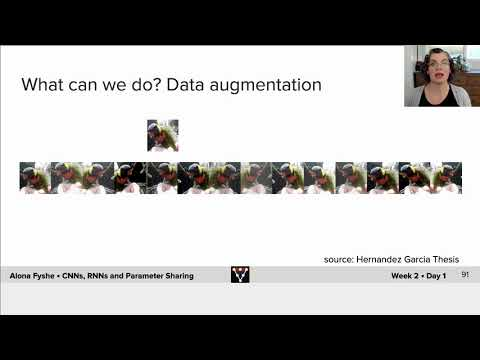

In [85]:
#@title Video 12: Data Augmentation
try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="M9-9QCehves", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Coding Exercise: 6.2 How much does augmentation help?

Last week you also learned how data augmentation can  regularize a network. Let's add data augmentation to our model via transforms and see if that helps our model to better generalize! In the following cell, add the transforms you want in the list `augmentation_transforms`. We will then run the same network you created in the above exercise (with regularization) and then plot the loss and accuracies.

Here's the link to the list of transforms available in pytorch: https://pytorch.org/vision/stable/transforms.html


In [86]:
def get_augmentation_transforms():
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add Transforms")
    ####################################################################
    augmentation_transforms = [...]

    return augmentation_transforms 

In [87]:
# to_remove solution
def get_augmentation_transforms():
   
    augmentation_transforms = [transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]

    return augmentation_transforms 

In [88]:
# basic preprocessing
preprocessing_transforms = [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]
# add the augmentation transforms to the preprocessing
train_transform = transforms.Compose(get_augmentation_transforms() + preprocessing_transforms)
# load the FashonMNIST dataset with the transforms
train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
# reduce to our two classes to speed up training
train_data = reduce_classes(train_data)
# get the data loader instances for the dataset
train_loader, validation_loader, test_loader = get_data_loaders(train_data, validation_data, test_data)

# get the network
net3 = FMNIST_Net2().to(device)
# and train it!
train_loss, train_acc, validation_loss, validation_acc = train(net3, device, train_loader, validation_loader, 20)

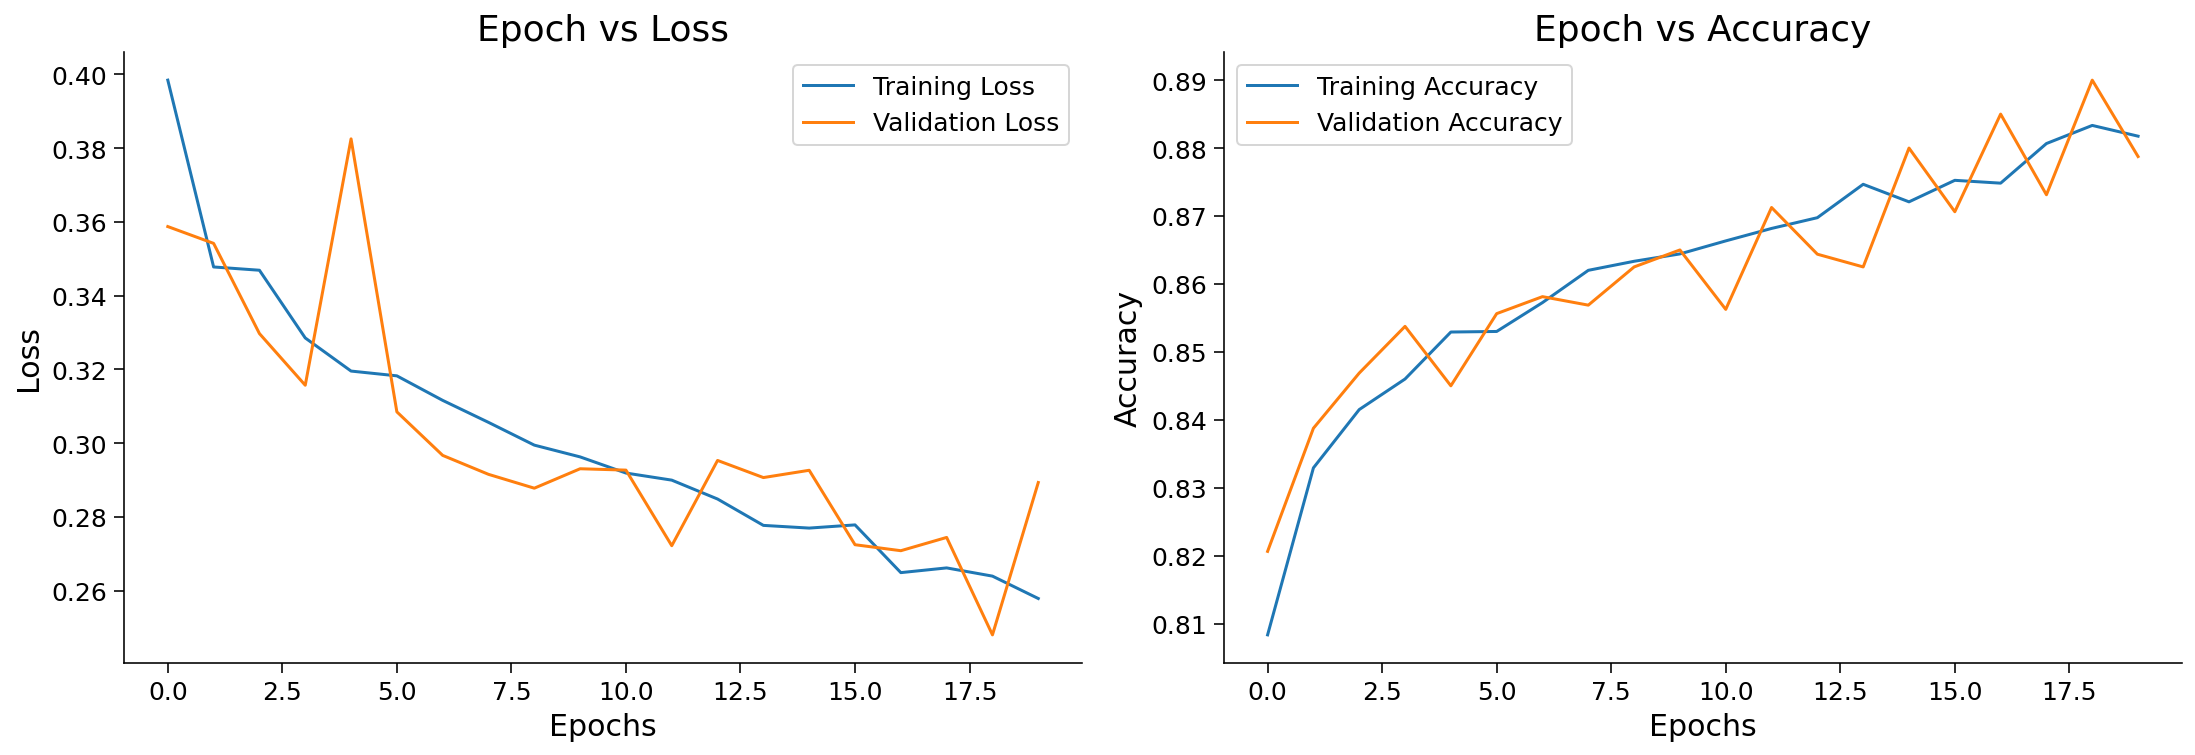

In [89]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W06_ConvNets/solutions/W6_Tutorial2_Solution_Ex23.py)

*Example output:*  

<img alt='Solution hint 2.3' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W06_ConvNets/static/W6_Tutorial2_Solution_Ex23.png />


In [90]:
test(net3, device, test_loader)

88.0

In [91]:
#@markdown Did the training accuracy reduce further? Is the model still overfitting?
augmentation = '' #@param {type:"string"}

Great! In this section you trained what may have been your very first CNN. You added regularization and data augmentation in order to get a model that generalizes well. All the pieces are beginning to fit together!

Next we will talk about RNNs, which parameter share over time.

# Section 7: Recurrent Neural Networks (RNNs)

Video available at https://youtu.be/0Majex-aF0E


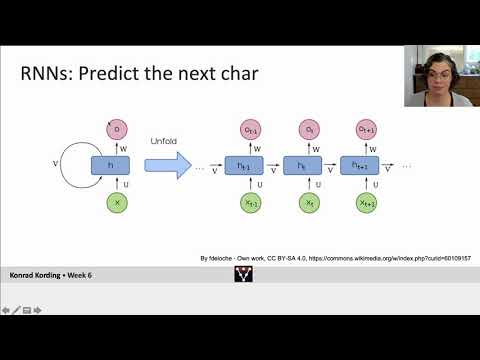

In [92]:
#@title Video 13: Intro to RNNs
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="0Majex-aF0E", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

RNNs are compact models that operate over timeseries, and have the ability to remember past input. They also save parameters by using the same weights at every time step.  If you've heard of Transformers, those models dont' have this kind of temporal weight sharing, and so they are *much* larger.

The code below is adapted from https://github.com/spro/char-rnn.pytorch

In [93]:
#@title RNN framework (run me)

!pip install unidecode

!wget --output-document=/content/sample_data/twain.txt https://github.com/amfyshe/amfyshe.github.io/blob/master/twain.txt

# https://github.com/spro/char-rnn.pytorch

import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif self.model == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))






     |████████████████████████████████| 245kB 25.5MB/s 
--2021-06-18 19:36:43--  https://github.com/amfyshe/amfyshe.github.io/blob/master/twain.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/sample_data/twain.txt’

/content/sample_dat     [ <=>                ] 106.45K  --.-KB/s    in 0.005s  

2021-06-18 19:36:43 (19.4 MB/s) - ‘/content/sample_data/twain.txt’ saved [109009]



In [94]:
#@title Helpers (run me)
# https://github.com/spro/char-rnn.pytorch

import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted



In [98]:

# https://github.com/spro/char-rnn.pytorch
!ls
!pwd
import torch
import torch.nn as nn
from torch.autograd import Variable

from tqdm import tqdm

batch_size = 50
chunk_len = 200
model = "rnn" # other options: lstm, gru

#hyperparams
n_layers = 2
hidden_size = 200
n_epochs = 2000
learning_rate = 0.01
print_every = 25

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / chunk_len

file, file_len = read_file('/content/sample_data/twain.txt')

def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adagrad(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1), position=0, leave=True):
    loss = train(*random_training_set(chunk_len, batch_size))
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(decoder, 'Wh', 100), '\n')





data  datasets	images	sample_data
/content


  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  1%|▏         | 25/2000 [00:10<14:22,  2.29it/s]

 10s (25 1%) 2.2993]
Wh5 1.6criidej"orys&quot;ex dgtaxd-cass="tontiks="s-taritn-bontatser;: /link              <.hinnter="c 



  2%|▎         | 50/2000 [00:21<14:30,  2.24it/s]

 21s (50 2%) 2.0324]
Wht-arid="H/amfbide" cons" nonder">
            <avee inader-link-lex="jarig="hx-6" v                  



  4%|▍         | 75/2000 [00:32<14:00,  2.29it/s]

 32s (75 3%) 1.8048]
Whe/div>Cot--camp-menu-tiop-ole-clase="giticon-item n hrta.github.githul.ck" data-dedpo11019462825.25. 



  5%|▌         | 100/2000 [00:43<14:20,  2.21it/s]

 43s (100 5%) 1.7438]
Wh1.75 .5a1.091.5 0 10 16" class="entron-cen" data-click-.githubass="Zdatarghtref="p( crist-w class="1 



  6%|▋         | 125/2000 [00:54<13:57,  2.24it/s]

 54s (125 6%) 1.5287]
Whtopy&quot; hubunmed-wrape fy" class="ary rel="butte" class="idun path-f0e1" htex-reposity="js-cump-t 



  8%|▊         | 150/2000 [01:05<13:46,  2.24it/s]

 5s (150 7%) 1.4172]
Whttg>
    <meta prijs">
             </ument" class="flex="Jations">
             href=</a><licon="1. 



  9%|▉         | 175/2000 [01:16<13:32,  2.25it/s]

 16s (175 8%) 1.4358]
Whta+s" data-lite-hei.ts Tele="erplot flex-selectarg_tous
             <suaner_c="https://githubasset/ 



 10%|█         | 200/2000 [01:28<13:46,  2.18it/s]

 28s (200 10%) 1.2511]
WhtM3">
    <a flex-mdex="octicon-inues-srcas-repo_cwide">
                                            



 11%|█▏        | 225/2000 [01:39<13:27,  2.20it/s]

 39s (225 11%) 1.1265]
Whtader="/medtiancata-sederline&quot;: &quot;hes&quot;experiment inge-tole-inline">
      <span class= 



 12%|█▎        | 250/2000 [01:50<13:33,  2.15it/s]

 50s (250 12%) 1.0556]
WhxVByAx="gmontent="16" class="octicon octicon-octicon octicon-5 ja-heddentIds&quot;: &quot;key&quot;: 



 14%|█▍        | 275/2000 [02:01<12:45,  2.25it/s]

 1s (275 13%) 1.0274]
Whttpx://amfyshe.github.io/width="16" clasr="defer="defer" integrity="shamfyshe/amfyshe.github.io/arch 



 15%|█▌        | 300/2000 [02:12<12:42,  2.23it/s]

 12s (300 15%) 1.0486]
Whtyph://links="Heake_inuess="wittMenu-idte="true"
          <li class="edge-item-list-stroundedule="e 



 16%|█▋        | 325/2000 [02:23<12:54,  2.16it/s]

 23s (325 16%) 1.0170]
Whttp-item-fix"><a href="/amfyshe/amfyshe.githubassets/chunk-loader-search" version="1.1" role="octico 



 18%|█▊        | 350/2000 [02:35<12:34,  2.19it/s]

 35s (350 17%) 1.0685]
Whtats css-td-bot;experilect ano-mflex-srong" text-selestarcl: content="wictWgry" aria-hidden_ing_loan 



 19%|█▉        | 375/2000 [02:45<11:44,  2.31it/s]

 45s (375 18%) 1.0625]
WhtymeE%2F5hx="js-thunchtyphex_ited cersion="1.1" data-tabnose" hrif="https://github.com/ssurstarticon 



 20%|██        | 400/2000 [02:56<12:20,  2.16it/s]

 56s (400 20%) 0.9176]
WhTGZZZCrC5rIYbQuXM3aQayZpDJ19LzmlS816f7f7a9c4a1796f06Oe97i5d02e3f8x0c8abb9d9b30b96ec219c02033642c3083 



 21%|██▏       | 425/2000 [03:07<11:48,  2.22it/s]

 7s (425 21%) 1.0119]
Whtyprorg_tygin="anonymous" text-nata>
                    </a>
                                       



 22%|██▎       | 450/2000 [03:18<11:34,  2.23it/s]

 18s (450 22%) 1.0337]
WhtV2h3HuxJdcfNznsGUUVZU3Bp49xCfAbLR=GLi+mS9s3ZwGJnIuHF8cx="Flobptyles.js" data-gati-bVwran tab Color- 



 24%|██▍       | 475/2000 [03:29<11:27,  2.22it/s]

 29s (475 23%) 0.8828]
WhtypogUtsXmassets.com/assets/chunk-container"
          </ul>
              
                    <svg 



 25%|██▌       | 500/2000 [03:40<11:13,  2.23it/s]

 40s (500 25%) 0.7520]
Whtutor</a>
                                                                          <meta name="borg 



 26%|██▋       | 525/2000 [03:51<11:07,  2.21it/s]

 51s (525 26%) 0.9021]
WhttusQ="16" class="octicon octicon-prage: 0"            <a dreations" data-hoverVary repository
    < 



 28%|██▊       | 550/2000 [04:02<10:59,  2.20it/s]

 2s (550 27%) 0.7566]
Whtypy="ENut">
      <a data-ga-click="(Logged out) Header, go to erch">
    <a class="bolder,umm btan 



 29%|██▉       | 575/2000 [04:13<10:25,  2.28it/s]

 13s (575 28%) 0.9041]
WhONBF+TWXot+dg2CxC74Au+qvory;refolw">
                        </twagn tab" data-view-component="true" 



 30%|███       | 600/2000 [04:24<10:46,  2.17it/s]

 24s (600 30%) 0.7153]
Whtku0/QsztUq_orM+mb998824966320z408" clop.nititor-ecusite,"> aria-hidden="true" class="mr-3 mr-lg-0"> 



 31%|███▏      | 625/2000 [04:35<10:05,  2.27it/s]

 35s (625 31%) 0.7078]
Whtyprot=="6h012-3_064259bef65a01786aceM1dsfjexp>Kog;:witheCtion-stab-item="iggter-item">
          <d 



 32%|███▎      | 650/2000 [04:46<10:22,  2.17it/s]

 46s (650 32%) 0.8116]
WhtIdsvgrath="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M1.71 3.001-.58-1.06.42. 



 34%|███▍      | 675/2000 [04:57<09:58,  2.21it/s]

 57s (675 33%) 0.7270]
Whttps://github.githubassets.com/assets/chunk-rocull-cun.or flex-shrink-0 js-aump to line" class="Bump 



 35%|███▌      | 700/2000 [05:08<09:50,  2.20it/s]

 8s (700 35%) 0.7063]
WhtFbli0Jks">/ass="rorment-0jehtid5h-4V7zmeO8ZcVmc7bwrymoOY2AfCWFz/M3BbDmcWUywR+NMBKMKRsJd==" type="ap 



 36%|███▋      | 725/2000 [05:19<09:21,  2.27it/s]

 19s (725 36%) 0.7588]
WhtimX==" aria-label="Team" role="bmm-0 tooltiut-input-dencopded, &quot;id&quot;: &quot;scteser_ord&qu 



 38%|███▊      | 750/2000 [05:30<09:31,  2.19it/s]

 30s (750 37%) 0.8220]
WhtZwlAs==" aria-label="Repository, on flex-auto" content="application/javascript" class="flex-item="i 



 39%|███▉      | 775/2000 [05:41<09:16,  2.20it/s]

 41s (775 38%) 0.7875]
Whavigation-lg-5">
  </li>
          <li class="d-block no-purce" data-view-component="true" height="1 



 40%|████      | 800/2000 [05:52<08:48,  2.27it/s]

 52s (800 40%) 0.7428]
WhtM2>
</a></path>
</svg>
                <div class="SelectMenu-tab" data-module-id="./chunk-header-l 



 41%|████▏     | 825/2000 [06:03<08:32,  2.29it/s]

 2s (825 41%) 0.8714]
Whtyplow pr0:2a4"
                        <div rel="list ot:Lige-search-unter">
                </ul>
 



 42%|████▎     | 850/2000 [06:13<08:35,  2.23it/s]

 13s (850 42%) 0.7650]
WhtMZW225Hrjj8AvZlQKiZ5zptyEPDAPH64c+WLYMe1fnspatg-headerMenu-1.jum.io%5.25 0 0l-.75zm1.5 1.5 0 00.116 



 44%|████▍     | 875/2000 [06:24<08:17,  2.26it/s]

 24s (875 43%) 0.7238]
Wht.github.com/amfyshe/amfyshe.github.io defer="defer" integrity_repositor"></span>
        <li class= 



 45%|████▌     | 900/2000 [06:35<08:19,  2.20it/s]

 35s (900 45%) 0.7016]
Why_urmentIds&quot;: [], &quot;id&quot;: &quot;20131706479&quot;, &quot;key&quot;: &quot;click.org_ong 



 46%|████▋     | 925/2000 [06:46<07:57,  2.25it/s]

 46s (925 46%) 0.6472]
Whodkloress-id="./chunk-nodife position-result="" aria-label="in all">
  

    <meta hransient" aria-l 



 48%|████▊     | 950/2000 [06:57<07:37,  2.30it/s]

 57s (950 47%) 0.7287]
WhowBox_orgendiviewHeader>
          <a role-tow-lick-smale">
          <span class="dy-2" href="/amfy 



 49%|████▉     | 975/2000 [07:08<07:43,  2.21it/s]

 8s (975 48%) 0.6656]
WhtaUDPG="Foot;}}" class="UnderlineNav-avatar-ergiticond" content="https://github.githubassets.com/rif 



 50%|█████     | 1000/2000 [07:19<07:25,  2.25it/s]

 19s (1000 50%) 0.7640]
Wht.github.com">
            <a role="menuitem">
    <meta name="google-site-verification" viewBox="0  



 51%|█████▏    | 1025/2000 [07:30<07:08,  2.28it/s]

 30s (1025 51%) 0.7042]
Whodd%3
        <a href="/amfyshe/amfyshe.github.io/page-colob-soriarie></a>
          <span data-hove 



 52%|█████▎    | 1050/2000 [07:40<06:54,  2.29it/s]

 40s (1050 52%) 0.7477]
Whty%5A2.js"></script>
    <script crossorigin="anonywoine="5a8a17.jup.tith autembratwork="fodm">
  <s 



 54%|█████▍    | 1075/2000 [07:51<06:55,  2.22it/s]

 51s (1075 53%) 0.7816]
Whti5 1ac==" type="application/javascript" data-module-id="./chunk-menu-idenun-pange">
                



 55%|█████▌    | 1100/2000 [08:02<06:40,  2.25it/s]

 2s (1100 55%) 0.6888]
WhtMQaythx/MeZAc23e255107fe11ca1eb6Cunkelempx" content="py-2 mr-3 pr-3">&llg--unter d-none flex-shrink 



 56%|█████▋    | 1125/2000 [08:13<06:15,  2.33it/s]

 13s (1125 56%) 0.7814]
WhtIds&quot;: [], &quot;id&quot;: &quot;18570330302&quot;, &quot;key&quot;: &quot;hreftext:sepository, 



 57%|█████▊    | 1150/2000 [08:23<06:08,  2.31it/s]

 23s (1150 57%) 0.6254]
Whtag2">




  <meta name="true" class="d-uldin inpo d-flex flex-coltor border-bottom aria-hidden="tru 



 59%|█████▉    | 1175/2000 [08:34<06:03,  2.27it/s]

 34s (1175 58%) 0.6833]
WhtIds&quot;: [], &quot;id&quot;: &quot;20182913028&quot;, &quot;key&quot;: &quot;click.classroom_sele 



 60%|██████    | 1200/2000 [08:45<06:20,  2.10it/s]

 45s (1200 60%) 0.6488]
WhzA4IPqQiNCIMeFpRsOzTgyPU/dAVrJu3QGAVUzVACbXAh8K2U1VLLdyZlzpty="0-1" href="/amfyshe/amfyshe.github.io 



 61%|██████▏   | 1225/2000 [08:56<05:40,  2.27it/s]

 56s (1225 61%) 0.6328]
WhtCuiThyORQ/KdYr26fHew.js">
              <li class="edge-item-fix"><a href="/amfyshe/amfyshe.github. 



 62%|██████▎   | 1250/2000 [09:07<05:27,  2.29it/s]

 7s (1250 62%) 0.6066]
Whok5A5.H8ca.25.25 0 00.4.2l1.4.25.75.75 0 012.197.013.06 1.06 0z"></path>
</av>



  <inclade" class= 



 64%|██████▍   | 1275/2000 [09:18<05:19,  2.27it/s]

 18s (1275 63%) 0.6257]
WhontIdhovicinFiator-pjax-container"
              <a class="details-overlay details-reset position-na 



 65%|██████▌   | 1300/2000 [09:29<05:03,  2.31it/s]

 29s (1300 65%) 0.6667]
Wht:pydolncno-trunl color-text-white show-overrment-0coment_page&quot;}, {&quot;experimentIds&quot;: [ 



 66%|██████▋   | 1325/2000 [09:40<05:18,  2.12it/s]

 40s (1325 66%) 0.6141]
Whod5vi4anyJesJlh3Cfijs-tagiL/>Farch></stark-container-lg-2ole--menu px-0 py-2 lh-condensed-ultra d-bl 



 68%|██████▊   | 1350/2000 [09:51<04:44,  2.28it/s]

 51s (1350 67%) 0.5216]
Whodt+g00:2a1170&quot;, &quot;key&quot;: &quot;click.classroom_project ull py-2 lh-condensed-ultra d-b 



 69%|██████▉   | 1375/2000 [10:01<04:31,  2.30it/s]

 1s (1375 68%) 0.6494]
Wht/ty="">
    </div>
</form>
               <li class="edge-item-fix"><a href="/amfyshe/amfyshe.githu 



 70%|███████   | 1400/2000 [10:12<04:24,  2.27it/s]

 12s (1400 70%) 0.6524]
WhodDo1729d2942eebbed3e25ef328756e5376a4d68c82d5c0425d50330Dc9d5mdG8S9DocAl66d6ee3bbd89f97307673775519 



 71%|███████▏  | 1425/2000 [10:23<04:11,  2.29it/s]

 23s (1425 71%) 0.6341]
WhoC="8Z0A1500QXqu6RXSInEMcrLSv68jehZWHmjMMULCEMEqHNxOTb_vFciThNAzhGqyF3lcs4hovAavicot.github.com/amfy 



 72%|███████▎  | 1450/2000 [10:34<04:05,  2.24it/s]

 34s (1450 72%) 0.5788]
WhodTpmbon seader-loader" href="https://github.com/security" class="Underlinenav-item no-wrap js-respo 



 74%|███████▍  | 1475/2000 [10:45<03:53,  2.25it/s]

 45s (1475 73%) 0.5236]
Whodk btaboly"
                            <span class="Bump-link-selected-link css-truncate css-trunc 



 75%|███████▌  | 1500/2000 [10:55<03:36,  2.31it/s]

 55s (1500 75%) 0.5919]
WhGU+FNUTEFqRPUTIavghzmVx-12">
  <a href="/amfyshe/amfyshe.github.io/refel="in header-type="bute">
  < 



 76%|███████▋  | 1525/2000 [11:06<03:24,  2.32it/s]

 6s (1525 76%) 0.6664]
Who%5>

                    <span class="Bump-link-symbol type="branch">
    </details-dialog">
       



 78%|███████▊  | 1550/2000 [11:17<03:14,  2.31it/s]

 17s (1550 77%) 0.5956]
Who%5Ash;//amfyshe.github.io/alog" content="py-2 lh-condensed-ultra d-block no-underline d-flex flex-a 



 79%|███████▉  | 1575/2000 [11:28<03:01,  2.34it/s]

 27s (1575 78%) 0.5323]
Whokp;Cod="0-0 f5Hda.jax mastertiary pr-3">&rarr;</span></a></li>
                  </ul>
</div>

     



 80%|████████  | 1600/2000 [11:38<02:55,  2.28it/s]

 38s (1600 80%) 0.4802]
Who%2 py-grav-item no-wrap css-truncate data-tab-item="i6proj-component="true" height="16" width="16"  



 81%|████████▏ | 1625/2000 [11:49<02:46,  2.25it/s]

 49s (1625 81%) 0.5768]
WhodOpYtendiv_repository,">{{ arch.com/nstations&quot;: &quot;1992374&quot;, &quot;key&quot;: &quot;cl 



 82%|████████▎ | 1650/2000 [12:00<02:33,  2.27it/s]

 0s (1650 82%) 0.5734]
WhoAuth+dyIqfownXOmQ==" type="application/javascript" src="https://github.com/amfyshe/amfyshe.github.i 



 84%|████████▍ | 1675/2000 [12:11<02:33,  2.12it/s]

 11s (1675 83%) 0.4228]
Whodtor-event="16" aria-hidden="true"><meta property="og:/usitp-s">
  <div id-node-mene project or wal 



 85%|████████▌ | 1700/2000 [12:22<02:15,  2.22it/s]

 22s (1700 85%) 0.5964]
Whow&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20236439236683750545b5a5abdd010cbaa 



 86%|████████▋ | 1725/2000 [12:33<01:57,  2.33it/s]

 33s (1725 86%) 0.6170]
Whov16h52.580a21585198a96865350794&quot;, &quot;key&quot;: &quot;click.disput.scues-stares-blicing"><a 



 88%|████████▊ | 1750/2000 [12:43<01:49,  2.29it/s]

 43s (1750 87%) 0.5643]
WhokEA2FylxyDEMTRLgxJ1jY/MQ/INcGToZUH2XRNeqISV7V3ceH6a2b7d991107719abd996437945f69 9d.25a.25.25 0 00-. 



 89%|████████▉ | 1775/2000 [12:54<01:41,  2.21it/s]

 54s (1775 88%) 0.4861]
Whovpris">Input rou data-target="ref-selector.list_repo_commit tooltipped tooltipped-span>
</bottor
   



 90%|█████████ | 1800/2000 [13:05<01:33,  2.15it/s]

 5s (1800 90%) 0.4876]
Whod+lugg:av-item no-wrap js-responsive-underlinenav-id="bdd-inline-block ml-1 v-align-midder-lg-focus 



 91%|█████████▏| 1825/2000 [13:16<01:17,  2.27it/s]

 16s (1825 91%) 0.5337]
Whod="110 113.48 8l3.22 3.22a.75.75 0 01-1.072 1.05A2.455 7.499 0 11-5.08 0 01.072-.27-1.598.094.436-4 



 92%|█████████▎| 1850/2000 [13:27<01:07,  2.23it/s]

 27s (1850 92%) 0.4569]
Whx_sugg://sitle;:&quot;: [], &quot;id&quot;: &quot;2022743070&quot;, &quot;key&quot;: &quot;click.upg 



 94%|█████████▍| 1875/2000 [13:37<00:55,  2.27it/s]

 37s (1875 93%) 0.5269]
WhozMXg2FlocAUet/mosiowient="true" height="16" width="16" class="octicon octicon-blob p-0 role="bottom 



 95%|█████████▌| 1900/2000 [13:48<00:43,  2.28it/s]

 48s (1900 95%) 0.5001]
Whokug, button&quot;,&quot;repository_id&quot;:{&quot;location_in_page&quot;:&quot;status, no-wodd" da 



 96%|█████████▋| 1925/2000 [13:59<00:35,  2.13it/s]

 59s (1925 96%) 0.4965]
Whowfox="0 0 16 16" version="1.1" data-view-component="true" class="repository" viewBox="0 0 14 8a4.25 



 98%|█████████▊| 1950/2000 [14:10<00:22,  2.24it/s]

 10s (1950 97%) 0.4991]
Whoducltsr" data-module-id="./chunk-revor="class-tprimi" contedtions-path-selected-links=" /amfyshe/am 



 99%|█████████▉| 1975/2000 [14:21<00:10,  2.32it/s]

 21s (1975 98%) 0.5383]
WhoDk.js"></script>
    <svg aria-hidden="true" class="d-flex flex-column d-none" alt="" aria-label="F 



100%|██████████| 2000/2000 [14:32<00:00,  2.29it/s]

 32s (2000 100%) 0.4782]
WhoAk mr-2 flex-shrink-0 color-bg-tertiary px-1 color-text-tertiary pr-3">&rarr;</span></a></li>
      



#Section 8: Power consumption in Deep Learning

Training NN models can be incredibly costly, both in actual money but also in power consumption. 

In [ ]:
#@title Video 14: Carbon Footprint of AI
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2upwdK3bcXU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Take a few moments to chat with your pod about the following points:
* Which societal costs of training do you find most compelling?
* When is training an AI model worth the cost?  Who should make that decision?
* Should there be additional taxes on energy costs for compute centers? 

# Section 9: Wrap up

What a day!  We've learned a lot!  The basics of CNNs and RNNs, and how changes to architecture that allow models to parameter share can greatly reduce the size of the model.  We learned about convoliution and pooling, as well as the basic idea behind RNNs.  To wrap up we thought about the impact of training large NN models.

In [ ]:
#@title Video 15: Wrap-up
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ikb4hwR4pU0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video